In [34]:
import pandas as pd
import re, sys, os, csv

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
import numpy as np
from io import StringIO

In [35]:
df = pd.read_csv('text_emotion.csv')
df.head()

tweet_id   sentiment       author  \
0  1956967341       empty   xoshayzers   
1  1956967666     sadness    wannamama   
2  1956967696     sadness    coolfunky   
3  1956967789  enthusiasm  czareaquino   
4  1956968416     neutral    xkilljoyx   

                                             content  
0  @tiffanylue i know  i was listenin to bad habi...  
1  Layin n bed with a headache  ughhhh...waitin o...  
2                Funeral ceremony...gloomy friday...  
3               wants to hang out with friends SOON!  
4  @dannycastillo We want to trade with someone w...

In [36]:
df = df[pd.notnull(df['content'])]

In [37]:
col=['sentiment','content']
df=df[col]

In [38]:
df.columns

Index(['sentiment', 'content'], dtype='object')

In [39]:
df.columns=['sentiment','content']

In [40]:
df['sentiment_id']=df['sentiment'].factorize()[0]
sentiment_id_df = df[['sentiment', 'sentiment_id']].drop_duplicates().sort_values('sentiment_id')
print(sentiment_id_df)
sentiment_to_id = dict(sentiment_id_df.values)
id_to_sentiment = dict(sentiment_id_df[['sentiment_id', 'sentiment']].values)

      sentiment  sentiment_id
0         empty             0
1       sadness             1
3    enthusiasm             2
4       neutral             3
5         worry             4
14     surprise             5
16         love             6
21          fun             7
30         hate             8
40    happiness             9
112     boredom            10
147      relief            11
494       anger            12


In [41]:
df.head()

sentiment                                            content  sentiment_id
0       empty  @tiffanylue i know  i was listenin to bad habi...             0
1     sadness  Layin n bed with a headache  ughhhh...waitin o...             1
2     sadness                Funeral ceremony...gloomy friday...             1
3  enthusiasm               wants to hang out with friends SOON!             2
4     neutral  @dannycastillo We want to trade with someone w...             3

In [42]:
stop=stopwords.words('english')
# df['content'].apply(lambda x: [word for word in x if word not in stop])
for i in stop :
    df['content'] = df['content'].replace(to_replace=r'\b%s\b'%i, value="",regex=True)
df['content']=df['content'].str.replace(r'\s+', ' ')
df['content']=df['content'].str.lower()
print(df.head())


    sentiment                                            content  sentiment_id
0       empty  @tiffanylue know listenin bad habit earlier st...             0
1     sadness       layin n bed headache ughhhh...waitin call...             1
2     sadness                funeral ceremony...gloomy friday...             1
3  enthusiasm                           wants hang friends soon!             2
4     neutral  @dannycastillo we want trade someone houston t...             3


In [27]:
# df_=df['content']
# df_ = df_.str.lower().split()
# regex_pat = re.compile(r'[^a-zA-Z\s]', flags=re.IGNORECASE)
# df_ = df_.str.replace(regex_pat, '')
# df_.str.join("")
def clean_tweet(tweet):
    '''
    Utility function to clean the text in a tweet by removing 
    links and special characters using regex.
    '''
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())

df['content'] = np.array([ clean_tweet(tweet) for tweet in df['content'] ])
print(df.head(10))


    sentiment                                            content  sentiment_id
0       empty  know listenin bad habit earlier started freaki...             0
1     sadness            layin n bed headache ughhhh waitin call             1
2     sadness                     funeral ceremony gloomy friday             1
3  enthusiasm                            wants hang friends soon             2
4     neutral          we want trade someone houston tickets one             3
5       worry              re pinging go prom bc bf like friends             4
6     sadness  i sleep im thinking old friend i want married ...             1
7       worry                                               hmmm             4
8     sadness                               charlene love i miss             1
9     sadness                               i sorry least friday             1


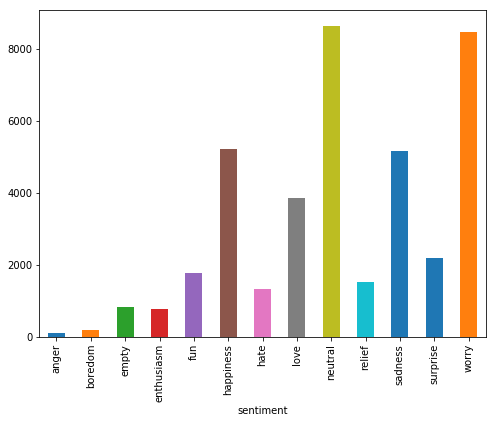

In [43]:

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('sentiment').count()['content'].plot.bar(ylim=0)
plt.show()

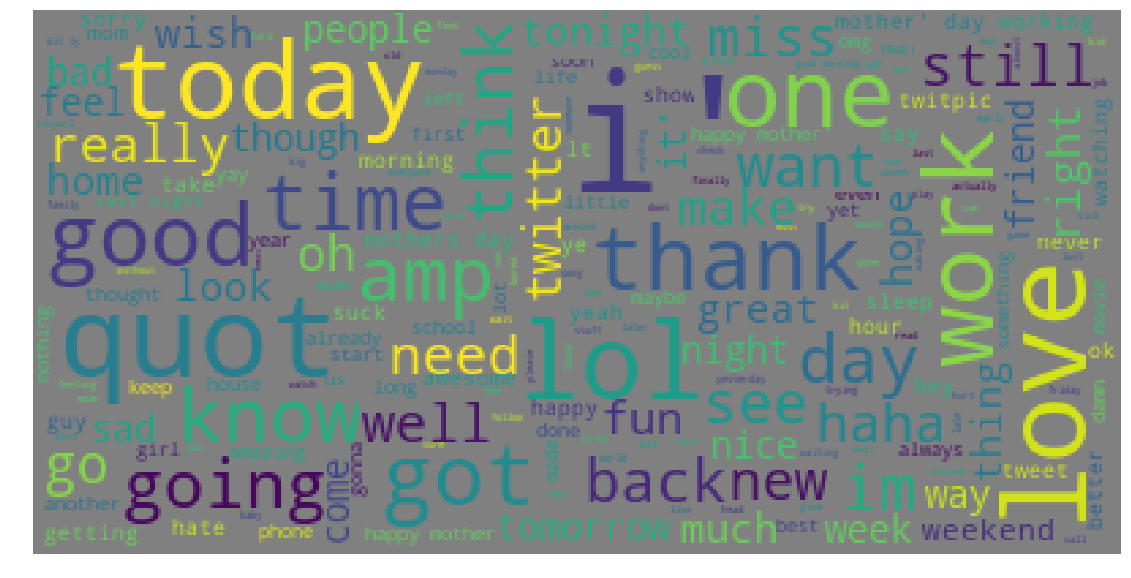

In [78]:
import wordcloud
cloud = wordcloud.WordCloud(background_color='gray', max_font_size=60, 
                                relative_scaling=1).generate(' '.join(df.content))

fig = plt.figure(figsize=(20, 10))
plt.axis('off')
plt.imshow(cloud);


In [44]:

from  sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

features = tfidf.fit_transform(df.content).toarray()
labels = df.sentiment_id
features.shape

(40000, 8104)

In [45]:
from sklearn.feature_selection import chi2
N = 2
for sentiment, sentiment_id in sorted(sentiment_to_id.items()):
  features_chi2 = chi2(features, labels == sentiment_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(sentiment))
  print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:])))

# 'anger':
  . Most correlated unigrams:
       . filthy
       . damned
  . Most correlated bigrams:
       . slow today
       . people work
# 'boredom':
  . Most correlated unigrams:
       . sooooooo
       . bored
  . Most correlated bigrams:
       . really bored
       . im bored
# 'empty':
  . Most correlated unigrams:
       . labor
       . bored
  . Most correlated bigrams:
       . ok ok
       . goodnight world
# 'enthusiasm':
  . Most correlated unigrams:
       . sings
       . grape
  . Most correlated bigrams:
       . wait start
       . weekend long
# 'fun':
  . Most correlated unigrams:
       . lol
       . fun
  . Most correlated bigrams:
       . need followers
       . good fun
# 'happiness':
  . Most correlated unigrams:
       . thanks
       . great
  . Most correlated bigrams:
       . happy star
       . good morning
# 'hate':
  . Most correlated unigrams:
       . sucks
       . hate
  . Most correlated bigrams:
       . hate rain
       . ugh hate
# 'love

In [71]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(df['content'], df['sentiment'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)


clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [72]:
print(clf.predict(count_vect.transform(["I cannot sleep."])))

['worry']


In [79]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

from sklearn.model_selection import cross_val_score


models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

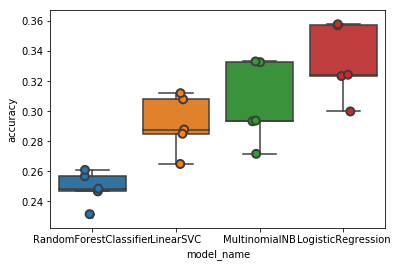

In [80]:
import seaborn as sns

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [81]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.291604
LogisticRegression        0.332605
MultinomialNB             0.304980
RandomForestClassifier    0.248922
Name: accuracy, dtype: float64

In [82]:
from sklearn.model_selection import train_test_split

model = LinearSVC()

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

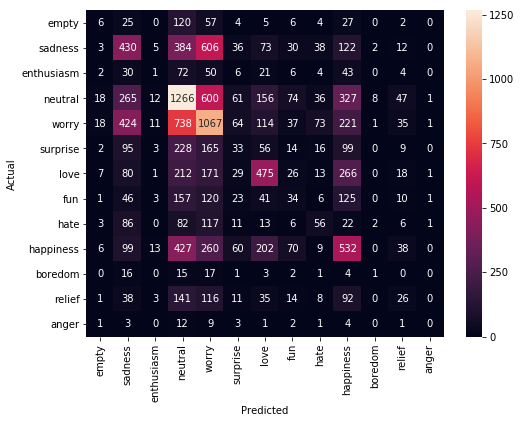

In [84]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=sentiment_id_df.sentiment.values, yticklabels=sentiment_id_df.sentiment.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [85]:
from IPython.display import display

for predicted in sentiment_id_df.sentiment_id:
  for actual in sentiment_id_df.sentiment_id:
    if predicted != actual and conf_mat[actual, predicted] >= 6:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_sentiment[actual], id_to_sentiment[predicted], conf_mat[actual, predicted]))
      display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['sentiment', 'content']])
      print('')

'neutral' predicted as 'empty' : 18 examples.


sentiment                                            content
20809   neutral           @mariedancerr songs tays vid katy perry.
28144   neutral                       @sween whom yu wanna kill ??
35960   neutral  i' trying decide i want go camping memorial da...
25750   neutral                                          so bored.
27127   neutral  @gfalcone601 salt vinegar, cheese onion make b...
1218    neutral               @toddh3284 t, im sooooo bored right 
6038    neutral                       eating halls cuz sour throte
33986   neutral    anybody else think #win7 pretty much vista sp2?
25074   neutral  @dfapam / ..../ and response 20,000 tweets wee...
21428   neutral                 tired tired tired ! freefest today
13240   neutral              thanks timmy. turns strep high fever.
21731   neutral                              @nathanryder i asked 
31165   neutral          @albo60s must ask cubs fans. i ' fathom .
9953    neutral       ninja sushi lunch dominicks sour gummy worms
20723   neutral                               @ameliafell realise 
10116   neutral  my teratoma cavity experiencing male-pattern b...
4501    neutral  whahhh!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! noo...
5711    neutral                                       i sooo tired


'worry' predicted as 'empty' : 18 examples.


sentiment                                            content
18626     worry  just found anne' brother died unexpectedly - 4...
37863     worry   predicting heavyweight battle lakers clevelan...
5488      worry      sooo confused days but glad back lillestrï¿½m
27742     worry  &quot;puke in my mouth&quot; brilliant respons...
27535     worry  @gfalcone601 cheese onion! vinegar taste weird...
22598     worry                                    im complaining.
16290     worry  @bowwow614 hey bow yu comin baxx 2 thaa 614 mi...
29339     worry  @mattmoreno i really like miller park bad cubs...
20575     worry              http://twitpic.com/4j9eo looks nights
888       worry  steam punlk fashion show anime north first yea...
15658     worry  yay jack . downer ' remembered friday meaning ...
7362      worry               this joke surely? http://prune./weat
11380     worry            omg searching, still ' find i looking .
10844     worry                                            i bored
11925     worry  yes four gas leaks house 3 yrs lived - ' u get...
1187      worry  insomniaaaaaaa..... night trying get sleep... ...
19982     worry               @emperorliu dick feels smaller look 
12583     worry  walking back 2 wk. its beautiful day. 2 njoy b...


'love' predicted as 'empty' : 7 examples.


sentiment                                            content
10048      love  my stomach trying eat . is time lunch yet? *lo...
22642      love                haappy bank holiday 2 weeeeks. aah!
7520       love                              thinking - katy perry
28735      love  @mde glad hear made , i hear place used ' coun...
36079      love                               made coffee cake mom
30196      love                                 @amberchase gifts 
35625      love  @verma awesome talk find true watching ruby co...


'happiness' predicted as 'empty' : 6 examples.


sentiment                                            content
17353  happiness  @ramesrock rompes mis ilusiones con lo de thra...
36692  happiness  @demiswissfan yer hope competition doesnt end ...
2673   happiness  @hilsatlvsonline thanks tip! unfortunately maj...
21775  happiness                         monday blues? not today, .
23189  happiness        capones island 2 days!!! summer starting...
27693  happiness  @gfalcone601 def cheese onion however back sta...


'empty' predicted as 'sadness' : 25 examples.


sentiment                                            content
8198      empty                    @shooz1 ok ok mam ... jus angry
21563     empty           @cyrandorman ok just thought occured ...
2895      empty  i fall asleep didnt get see jonas brothers web...
22437     empty  @dexterouslady next best thing bored bored abl...
8551      empty   off meeting lincoln square, bummer, free parking
23401     empty  http://twitpic.com/4jco5 - the result working ...
2749      empty  @apdiggles he' mother' favorite. it hard telli...
9666      empty                  i wish i could go e3. oh well....
5899      empty         ahh hate bbrush teeth hard make gums bleed
12116     empty  the little wormy labyrinth sadly passed away t...
1678      empty  i want wednesday already i hurry go new zealan...
18376     empty                           ...nomore adventure time
11024     empty  @cassieventura i know feel cassie cat went mis...
28951     empty               @sunflowerygirl especially ' vampire
23064     empty  @se7en. cï¿½m anh ko chiu noi ~ nhï¿½ tifa roi...
13912     empty                                       more sunburn
8423      empty                                      i' bored work
38900     empty  back , i busy xd wirting stars loves, almos 40...
10642     empty                      i dont wanna im spanish today
15649     empty                                  ugh. kinda bored.
19207     empty                                  ugh boring friday
17385     empty                                       falling nick
19640     empty  a bunny eating moms plants. naturally, started...
5511      empty    bored bored bored. nothing today besides work 5
16912     empty   wtf crap 5 mins marked closed...faz cost 4 grand


'enthusiasm' predicted as 'sadness' : 30 examples.


sentiment                                            content
937    enthusiasm                         boring. wanna go taekwando
12471  enthusiasm           last day work ... everyone making great!
22026  enthusiasm  @textualoffender good luck.. mine 3rd day today !
36581  enthusiasm  @beati3 moving rod justin, even persuaded sons...
10259  enthusiasm            leaving dont miss much tweetbeaks &lt;3
3991   enthusiasm  duuuude, tim said ' making red vs blue animate...
19974  enthusiasm  @albertposis congratulations ! guys finish mon...
33945  enthusiasm  @n0s4a2 wowie wooie someone updated twitter wi...
2191   enthusiasm  ' tell thrilled i nosebleed. first time ages. ...
7574   enthusiasm                                 @tinabojo wish i !
26570  enthusiasm                          @bball4life florida nice.
32189  enthusiasm  @skotot oh, said, sellout fluke. it turns proj...
1078   enthusiasm  good morning sexy twitter ' yall ??? i' gd ' l...
12209  enthusiasm  nice seeing partner crime/gossip drama queen p...
24045  enthusiasm  schoool time. much week. 20 days school ' time...
9897   enthusiasm  @mrexclusive1 i' jealous... need 2 escape 2, lol.
10299  enthusiasm           i' sick sick. the weekend i' ready party
15762  enthusiasm                     really wanted go surfers today
19977  enthusiasm  double rainbow organs. pretty, ' take edge $46...
33955  enthusiasm                 working climb season 2 episode 5!!
26309  enthusiasm   way nanny school starts tomorrow! one step cl...
15656  enthusiasm  greg pritchard got threw final britains got ta...
21874  enthusiasm                        i beat 3 bosses castelvania
10067  enthusiasm  @the_wockeez i wanna go! but i ' i' sure show ...
23732  enthusiasm  @danabingham i know exactly mean. my treats 'a...
13968  enthusiasm                    i wanna talk mitchel mussoooooo
13395  enthusiasm  its friday... i can't wait to be done with wor...
33783  enthusiasm                    @sondra_ guess wait &amp; see..
16740  enthusiasm  is cold mind i sat outside 30 mins waiting lif...
12008  enthusiasm  @mrskerrykatona glad 2hear kerry!!! didnt know...


'neutral' predicted as 'sadness' : 265 examples.


sentiment                                            content
38881   neutral  @_ado i ' think ' still one i' one six years t...
38992   neutral                       reconnecting amadeus friends
2407    neutral                                   i wish i company
2464    neutral                                        super tired
27400   neutral          @vickielam better getting mad using floor
19482   neutral  @lopchelle @marchie1 chicago 8:20 ... landed xoxo
10507   neutral                                            workin.
15302   neutral  @kristianinicole i left @ home http://myloc./21cn
9855    neutral                 @divarina21 tell hasnt? miss boge.
11637   neutral                    disappointed ' win teh glassez.
1668    neutral  @brandillio would ideal. however... i dont see...
17612   neutral             @davejmatthews @slessard wanna tonight
28508   neutral                                   about clock work
13531   neutral                            i want iphone &lt;33333
32704   neutral                                watching ugly betty
30870   neutral                                         with matt.
29661   neutral          @notsafeforwork vote per day per computer
12452   neutral      @cristnabls i totally agree! and ' way avoid 
2698    neutral  @alisonmyra it' called ripstick. when i job i ...
22854   neutral    got lot things hehe daya sa mga walang ginagawa
10769   neutral  @michaeltao got one , usb key without fancy pa...
2379    neutral  @ac07 lol. academy-ish. haha. i really really ...
8594    neutral             @babyblueonline awww thatss well sad x
1575    neutral                             shame i' gotto go work
17566   neutral                     @nessie_cullen10 i wish right 
18915   neutral                             sitting bed i weekend.
13738   neutral  there' only one thing i hate about friends and...
27751   neutral  har varit pï¿½ hannah montana movie // cool ht...
15441   neutral  got email @unitedairlines telling i could got ...
5757    neutral               @demetridadon well tomorrow? i miss 
...         ...                                                ...
8655    neutral                   lately ' waking sun face today..
34406   neutral  @nowoo giving oh well. it' counting, ' math we...
11419   neutral                         salad krogers... i hungry.
25063   neutral  @ajaymohanreddy it' time face truth - expat in...
9867    neutral                                   little miss ugly
19637   neutral  im bumbed though cuz ima miss da laker game |d...
39340   neutral  ....damn article, need creativity _isn' 16:20h...
20421   neutral                            best things life free x
1861    neutral                        hungry agaaaaaaiiiin maaaam
12651   neutral                              awww bless . made cry
2198    neutral  on train . i forgot charger means whoshere tod...
661     neutral                            @ccburns unfortunately 
32226   neutral              drinking smoking bad.--- im grown tho
17175   neutral            finished death du jour. school' . nerd.
36445   neutral  @diond408 ooooo i / using iphone version, i us...
11416   neutral                         working weekend looks like
19624   neutral  just quick 'hello' , 'goodbye' &amp; 'enjoy pa...
7153    neutral        weekend cuzzo vivi, i ' stand leave 3 weeks
12722   neutral                                   @simplecake bye.
18572   neutral                                way orlando raining
20169   neutral    @tessmorris fine! going big walk today 20 miles
35763   neutral   @sherirocks aww i know, used chat became cool ;)
24079   neutral   @jelnora nothing like alone time handheld device
15987   neutral                            anyone ?? bored work...
6894    neutral             it' friday... but friday morning. ugh.
20763   neutral                        wishing would get followers
7641    neutral  hey #socialmediatv - i' new - recorded show, v...
13556   neutral   get music start playing.. clicked &


'worry' predicted as 'sadness' : 424 examples.


sentiment                                            content
18247     worry  iphone &quot; opening downloaded apps&quot; th...
20968     worry                  i alreay feel hang . soooo worth 
12608     worry  i fat-fingered coke machine, i drinking diet p...
5049      worry          fuck. my arms feel like really sore jell-
24086     worry  neglecting boy, apparently... i' outro, real life
17316     worry   poolside. bowling toniht maybe?? back work to...
1244      worry  @nassrenj i miss u guys i prob ' b bk til augu...
16022     worry  actually, like almost everything job right . e...
27229     worry             @mitchelmusso ... ' mind.. like time..
9741      worry                    still ' sleep..missin' dobby...
11000     worry      wondering mother nature making life miserable
1897      worry              i ' go sleep tech support emails back
22294     worry          @player112345 good morrow! how fair morn?
18143     worry              @mitchelmusso ' hang fone getting hot
5063      worry                        work ... mercedez' last day
3413      worry        that ' i missed many leg sessions recently.
10823     worry  @saz_xox oh god, everyone' dying. but ' mainly...
39212     worry   14.5 miles peak last night, nice 5 mile run b...
8482      worry  ugh i missed potus @ my five guys!!!! 2 blocks...
16176     worry  @marshallsheldon probably good idea, hard twee...
4429      worry   think 90% irish population manchester come ho...
1278      worry  i honestly feel like i' healing getting better...
13791     worry                        @freyalynn ' friggin late .
14371     worry            found friend' dad passed away yesterday
8619      worry                                     yeah. it' sad.
11987     worry  @jen_walker21 sadly , i' going killumbus show....
5274      worry     woke felt sharp pain back leg. no school today
6619      worry         think ipod sick ' want connect wi-fi . . .
2177      worry  have sell car. it' costing much. can afford on...
25480     worry  @leannarenee hope sequel edits go well noteboo...
...         ...                                                ...
1081      worry  feels disappointed..mahirap talaga mag-supervi...
17853     worry  @mitchelmusso would love call live norway litt...
16052     worry  stuck awful traffic way wedding. ceremony supp...
12926     worry  feeling tempted high volume jeeps start &quot;...
15931     worry   lookbook craving everyones clothes want penci...
11433     worry  i bought leica m8, charger arrived doa. called...
29784     worry  @therealkyra awww ' matter, kyra? @ sugarloot ...
5766      worry       missing much. work ' spend time get paid lol
4300      worry  @laydown28 man i ' know... months actually alm...
20892     worry  @sonwright i' iphone owner, i ' really choice ...
5657      worry                        plan spend money going well
6799      worry  @tyleralyse sac ' offer fundamentals math 2 te...
7700      worry  ichigo good ping&amp;pooping outside used fact...
32763     worry  @djstunz hahahahahahhaaaa god randy, i miss ! ...
17821     worry                  going security already miss baby.
19831     worry  @brineandbastard what?? nooooooooo there goes ...
19546     worry  @elmoberry @ejc7 - miss you two!!! find random...
31597     worry  @studio8 --sorry running uncle terry, ' living...
9629      worry   seriously need live somewhere fabulously quee...
18873     worry                            so sad aki rest season!
9011      worry  just saw half rro staff walk ...sadly i ' see ...
5006      worry  congrats graduates! such beautiful thing &amp;...
6296      worry    @lamborghinibow u good replys u fallin sad face
19674     worry  you know fat someone points . ugh... aweful da...
5194      worry  @mandelin omg ' one year work permit! going ho...
12666     worry   sick, congested forehead ( possible) chest. a...
3367      worry                cannot go, cannot refused feel pain
16623     worry                         missing nate 


'surprise' predicted as 'sadness' : 95 examples.


sentiment                                            content
8316   surprise  @jerwjr yes. me . i ' understand . i mean, i k...
3015   surprise    getting dressed go granny',another day twitting
16790  surprise                   nothing.. looking car. im luck !
39095  surprise  @duskyblueskies i pretty sure ' sort tweeting ...
5920   surprise        @epiphanygirl when coming indianapolis !?!?
6765   surprise  @francecino alright babes &gt;&lt; boo. im gon...
6295   surprise  on way back dublin omg didnt hit bed 530 sleep...
32341  surprise           @greenatelier awww wish i ! have brew b!
34798  surprise                                        @esuh cried
32445  surprise  @alferretti uh, yeah. totally. but , i real li...
24269  surprise  @phomor someone' horsing . btw hubb feels twit...
4451   surprise                    gutted - handbag i wanted sold!
9259   surprise  @jamespenycate massive beer guardian. huuuge. ...
10117  surprise  @shadowingh i' allergic bunnies. are allergic ...
10685  surprise  @danger_skies i want dance i ' really listened...
36457  surprise                                   i somehow miss .
11337  surprise             @keytaj yeah... passed last week. sad!
34794  surprise  @sakka: what, ' really alcoholic? i am v. disa...
7332   surprise                             i ever delete twitter?
28538  surprise  @luckis i watched !!! i didnt want win, put go...
9665   surprise  hey dont feel so good,cuz got car accedent yes...
2570   surprise           lovely summery morning! shame i work!!!!
15671  surprise  @abramsandbettes sent one abrams surrounded we...
8771   surprise  i want go outside play sunshine, i sit front c...
11249  surprise                 @kaliboooo bucher' class?! cried !
15244  surprise  just woke . i dreamed i 9 new emails! sadly, d...
39208  surprise                           new friend called shame.
2005   surprise               yay ' friday... hold i work tomorrow
8915   surprise           :o can' believe hannahs dead hollyoaks!!
5911   surprise  @captaincarrott ' mean . you' gonna pizza toni...
...         ...                                                ...
15636  surprise  jumped train visit rescue mom. totally forgot ...
2603   surprise  ' believe wait till october see &quot;up!&quot...
20001  surprise                        please ignore cheesey music
12146  surprise  loll whats boyfriend #2 supposed mean ? @cathy...
11639  surprise  @cosrobperkins you' third person ask mon after...
9424   surprise  http://twitpic.com/672s3 - what i woke morning...
6693   surprise         @lovessunflowers oh ! dead muffins ... sad
5942   surprise                  off dollarama -- i wish i new job
26176  surprise  doneeee wheeee hahaaaaaaaa tired sleepy peter ...
5290   surprise  @yampolito that make things fair. my poor tige...
3718   surprise  @dexteraddict aw *hugs* sorry man. if i rich i...
23587  surprise  excited! double bio today. i ' straightener ha...
12056  surprise  oh ! fun weekend friends gone! mother made fam...
37728  surprise  @ebrown2112 lol ' last winter ( months ago dec...
13052  surprise           @cainandrews awwwh u stuck traffic booo!
23501  surprise                     @aanddfilms omg rated 10 stars
15414  surprise  sob! i ' believe i' ending work week chapter a...
1903   surprise  wow must tired. fell asleep @ exactly start 10...
8697   surprise                             watching hollyoaks omg
13247  surprise                             &quot;up&quot; sold !!
8999   surprise                     @abhorrentbm lame. said hello!
21739  surprise            rock pooling. can' believe i get paid !
21595  surprise  having write real looking paper letter. not do...
12941  surprise          absolutely nothing eat house... epic fail
5231   surprise               sometimes i wish i prototype mentor.
9877   surprise      my guitar ' herew yet?, feel like lost limb!.
16453  surprise  wishes call . blah. used easy move . wtf happe...
16517  surprise              i got overexcited pizza 


'love' predicted as 'sadness' : 80 examples.


sentiment                                            content
2411       love                           bummer tomorrow friday !
3336       love                                 @sexyskins miss !!
29613      love                            dinner fam... i missed 
3382       love  @truestepper other people glasgow ones, standi...
11753      love                       one wish would friend j work
15300      love  i wish i someone enjoy drink outside beautiful...
2154       love  im finally going home didnt get finish work il...
28317      love  @deeeniseee eh, ' really nice girl how ? miss ...
31705      love  saw lil girl big eyes hair like dora explorer....
2943       love   sad day! love maï¿½ (8 years ago!) miss much!!!!
30753      love  @sheasylvia sometimes i wish twitter facebook'...
31316      love  @erikarbautista ! he has a favourite! you' fav...
6102       love         realy wanted go cause nice everybodys busy
31882      love  @eatthecakenyc know mad late (sorry lol) thank...
7017       love  turns 26 june 22. youth shelton bday going sna...
27585      love  aaaah see prez obama holding hands wifey? sooo...
29238      love        this last time get right... hello loves....
12868      love  @madisonapril lol haha fresh death lol ha ha i...
795        love  @daveockun i hate , fleetwood favorite band......
36002      love  i tired phone. walkman works like charm, l nee...
39989      love  his snoring annoying n keeps sleeping (like ri...
3798       love   i miss @abhorredlife much i wish i enough money 
17642      love  just loaned set aerobars team mate tomorrow' t...
7973       love    @lewdogg i wish i could afford attend benefits.
31773      love  i still luv hawks! i aint fair weather fan! i'...
24733      love  @steph1985 bye btw, like simple plan, hoobasta...
7478       love  @cwpicketandco it' pretty warm ! i forgot k si...
1405       love  @lma_xo my daddy lives manchester, i love :-d ...
35015      love  read twilight new moon keen read eclipse break...
15390      love  @chicksnchickens @momtv creative vado' stock w...
...         ...                                                ...
21973      love  @debbas my mom nurse practitioner&amp;spent en...
29446      love          @honey3223 hey honey bunny big bunny hugs
13677      love  @mitchelmusso think tour england, dont got see...
31479      love  @cortnee4christ made many new friends twitter ...
11207      love                @juicyfruits88 yeah i feel sad tho.
19838      love  finally chance show genuine love, dependent se...
3442       love                   @effyobie lol. dood, love miss .
16763      love  watching fashion show (bravotv). i ' know show...
18445      love  @honk4peace yes, love miss @chubbygayman other...
3818       love  @pleasurep just read message u stephanie' gree...
38959      love                        @dashkaaa always miss , ' ?
13318      love               laura' gone weekend, i miss already!
36738      love                   thinks aaron pretty darn awesome
34023      love  oh, last tweet spent half hour brushing teeth ...
30627      love  i need change ways, instead weak. i love @ddlo...
14078      love  i spent whole dream cooking delicious meal, i ...
32929      love  @robpattinson_ i want tell guys amazing, thank...
24148      love                 i love able run tongue along teeth
32128      love           @fabfatties thank ! one day time, right?
23956      love                                    @peircy oh kind
15843      love  my boy leaving summer, going stay grandparents...
5892       love     @kweenie are galbladia garden? that shit hard.
29125      love  @macsheikh @ghadalancer thanks ff i think i st...
15779      love  @bust_magazine thats dream , thats reality cs4...
6648       love  already feel like idiot phone makes worse bran...
16943      love                               @thechrisjulian awww
23404      love  @jeffsonstein me , monday end weekend. but, ca...
24636      love                          go last fina


'fun' predicted as 'sadness' : 46 examples.


sentiment                                            content
15109       fun                   giesal dayyyyyy. come join meee!
5212        fun  and figuring watch middlesbrough games next ye...
2682        fun  i' saying goodbye sydney days, hello rapeville...
16357       fun  going eat entourage, probably fat e' since ' c...
11311       fun  so tonights tv viewing, bgt hignfy reggie perr...
31691       fun  @rockndan dude... tried vegetarian thing laste...
19240       fun                                        got sold up
37274       fun  @pranaydewan thanku cooking simple law - u hve...
17812       fun  the hangover: that movie gonna hilarious. wish...
16216       fun  @yahyan yahyan: @supremacii iaaaaaaaaaaaaan, j...
38803       fun  @thesimshub i' going kill person went manchest...
22501       fun                     @wulffboy i' give u icecream ?
22289       fun  @midad this weekend? haha yeah i' free oh sati...
33748       fun  years ago neighbor told went school sharkboy i...
38112       fun  @shiraabel going tweets right , probably misse...
6732        fun       @sexxieluv i wanna go sexxieluv party though
22593       fun  @larasati uh?your us itms credit loaded friend...
6516        fun  @ashleytisdale fun!!!! dont school , wish coul...
5169        fun  @briancash yum...wish could today. i cold ' wa...
27527       fun  @peacesignpamfod david -- nice know feels comf...
28626       fun           well sucked except company i . go kelly.
32899       fun  @jholden23 ' test theory right arm strum . got...
7950        fun  such busy day today!! banbury fair fashion sho...
10191       fun  @melissapan aww yeah, ' fun revising others ge...
19326       fun          fun friday night planned...... spent work
2270        fun  yummy chocolate cake..wish even got one b'day!...
1101        fun   wish @angelcore' burning trees trying dresses...
4242        fun  travel trade stalwart, david steele city cruis...
31758       fun  i sewed shirt i fail screaming v_v i quesadill...
20239       fun  @realbillbailey ' read book, heard . feed, spa...
23676       fun  waitin 4 skool bus soo tired nd still soo much...
34423       fun  i' one tough momma. put together swing set tam...
17260       fun          yeahhhhhhhhhhhhh friday.. i work tomorrow
39280       fun  @edsaint lol @ half - i already bulky desktop-...
809         fun               @briannabanshee dissapointment hhaha
29554       fun  @babyvofficial aww thatz 2 bad...ud b great ne...
14171       fun  got car back excited/sad going away party i' a...
11886       fun  @jujubean0273 lol yea im thinkin bday bash ! e...
29312       fun  @mbm88 ahhh i' drinking !! and bride wars real...
13985       fun             wants new phone. ugh b-day 3 weeks ya'
13480       fun  out guys playing 10 pin &amp; mexican! great c...
2852        fun  @aravindkumar whats today..? missed #coffeeclu...
13284       fun  maaaaaaaaajor headache. it' gloomy outside! ju...
16772       fun   going forgo pub night wife tonight. tough wee...
22365       fun              cooking dad lots fun kitchen together
17692       fun  @spjwebster wish @njwebster coming i guess mak...


'hate' predicted as 'sadness' : 86 examples.


sentiment                                            content
9269       hate      stupid idiot ran stop sing almost killed car!
8099       hate  got tired kitchen uninhabital swept mopped flo...
17312      hate  i william shatner version rocket man head 3 da...
16459      hate  how fuck 2833 songs fill ipod supposed hold 4000?
15382      hate  when youre kawawa, make kawawa cuz hate seeing...
14099      hate                  ugh trek hollie steel annoys &gt;
27110      hate  blocked acct one hated sports teams. that felt...
11284      hate             ooo goddddd; vodafone trouble. network
10282      hate           the new tecas driver license design ugly
16850      hate  i' whiny right i' annoying need get rest tonig...
10017      hate  damn fight night 4 demo ' load, keeps crashing...
16644      hate        windows updates suck. there freaking many .
16174      hate  dear on boards theater: you loud head stomp st...
7346       hate    just got work today going another long ass day!
35381      hate  @backpackerinoz i ' like fishfingers. i ' like...
17915      hate  24 hours $400 later i hav new telecom phone do...
6137       hate  weather sucks. apush filming become maybe at l...
15024      hate      i h8 weather!! it' gloomy &amp; rainy weekend
13083      hate  @19fischi75 dont think ugly - tha dumb ass loo...
20774      hate      bored... some vector shit... off work class..
2595       hate  shit shit, ' mean dall asleep , ' 9am, i wante...
7456       hate  last night cork come tomorrow wont even rememb...
14229      hate   economics wanna go homeeeeeee im tired hate t...
34883      hate  macs ftw btw. . .. ' still using grandaddy pc'...
17630      hate                  stupid storm. no river us tonight
7273       hate  6 freakin days!! just thought... would i look ...
18698      hate  hey @jerrymontano! @secrettweet mainly depress...
28617      hate  another loser: @meekakitty i hate ...lost the ...
17954      hate                    @juslisae damn shame body waste
487        hate  @abguerraartist i pussy! damnit! [sending e-ma...
...         ...                                                ...
7027       hate                            oh hate friday evening.
5859       hate   thought unfair 3 ppl 2 n got depressed haters!!!
15825      hate                     apple also rotten center, luck
10604      hate  friday whole different meaning work saturday s...
9432       hate  @devon_leigh u know wut devy dev sure suck hav...
15802      hate                     its gloomy fuck outside ewwwww
14456      hate  oh insomnia, i hate . i' bored staring ceiling...
12570      hate  @tommcfly ' come see hosts hilton mr. thomas. ...
13332      hate  sittin boring ass conference call... then get ...
8525       hate            f***** work .... want somebody come ???
15010      hate  @bittertea ugh unattractive! u might well drin...
101        hate                @mrgenius23 you win ... sigh rakeem
3049       hate  my record player decided die. why friday night...
15336      hate  ugh!! why ' infamous xbox360!!!?? fucking lame...
19420      hate            so... things ' work expected, well damm
10392      hate    dont hate u take bite apple nasty?im sad panda 
19528      hate                             @anwith1n missed lodo'
10234      hate                                        week awful.
8953       hate  @debbieseraphina effective stuck! either sit ,...
15820      hate                                  @emboosh aw sucks
9999       hate              wishing i could kidnap @candrews work
12825      hate  not making good time, fucking chicago traffic ...
2193       hate                                    bah, h8 waking 
16225      hate           @lakia unfortunately noy life suck year.
7229       hate  1 week palm pre comes centro dies. i temp phon...
15990      hate           just i thought albany ' worse ao' leave 
1457       hate   hsbc savings apy dropped 1.55%. sort feeling ...
21644      hate  they unloading leopard tank next off


'happiness' predicted as 'sadness' : 99 examples.


sentiment                                            content
15301  happiness  @werewolfseth really call ma'...wow reality ch...
39022  happiness  @f2point4 oh, nice!! i something nice next wee...
35832  happiness  man, finishing &quot;operation anchorage&quot;...
26948  happiness  i' pondering lunch shane'. i think. i already ...
35129  happiness  nungguin sista law lahiran di rs asih...kayakn...
36071  happiness  http://twitpic.com/4woxi - btw, concert freaki...
7757   happiness              day going well far. meeting 4 though.
7341   happiness  excited see girls today; @takinakab boring wor...
19763  happiness       @cassapel damn, i got excited nothing hahaha
26333  happiness        27 followers 23 more.... twitter party!!!!!
37960  happiness   surprisingly good day, time sleep. hopefully ...
28057  happiness  @mrsvaught happy birthday, amber! hope ' great...
24390  happiness  wanted: new liver kidney, glass wine would goo...
16959  happiness                            liz left aww good see .
39221  happiness      @andrew1913 theme tune? your robin i' batman!
6364   happiness  loving sun today, even thought i revising. not...
10223  happiness  just babi pangang. now friends. tomorrow ' wor...
24600  happiness  @djchino102jamz i got work i take whole day , ...
31026  happiness   hanging roomies. i adore 4 gentlemen i live ....
11651  happiness                                     alone weekend!
8487   happiness  @oliviamunn san diego! move down here! althoug...
27569  happiness  little girls shallowness annoy . on good side ...
30897  happiness  @aoibhe well, i ' get real clear shot, i' got ...
14576  happiness  @colbertobsessed i lucky, mom paid everything ...
16361  happiness  @montiasutton i wish i could really i love u a...
11514  happiness  happy google wave trending. can' watch video ....
35766  happiness    we got jojo free free drinks mom! my kind night
12778  happiness  @thatdamnninja oh, okay. every often i get ran...
36671  happiness             movie weekend!! ' watched 5 movies far
21681  happiness  java concurrency practice probably best java b...
...          ...                                                ...
33350  happiness  is watching &quot;it takes two&quot;.... class...
37336  happiness  @aloliver you' got standards alice otherwise w...
3790   happiness  finally gonna try fall asleep goodnight.. more...
28416  happiness  yes, ' really back!: i ' wait day arrive final...
25141  happiness                                     i' pumped day!
32802  happiness  @allangoesdmb i listen alot work. damn good show!
5426   happiness        such beautiful day. i wish i energy enjoy .
12420  happiness  friday freakin happy today annoying day buuut ...
31887  happiness            @lizziechristine thank much miss toooo!
25358  happiness  dinner ali tonight celebrating first day new j...
17037  happiness  people mustaches get super powers mustaches. f...
22556  happiness               @mrssprousex mee ' looks amazeeeeeee
37504  happiness  @bradiewebbstack baked dinner yummy cant wait ...
28602  happiness  nina' high: hanging ninah taylor day! theyre a...
8459   happiness  have ordered cuuutest invitations new nieceï¿½...
37714  happiness  efteling great, nice time family, dinner.. for...
2159   happiness  @pyroezra know! wish would. i wanna cuddle sle...
6314   happiness                             in university hungry!!
31451  happiness  i painted nails metallic blue iï¿½m really sur...
26351  happiness  school... haha well i hope today fun. i post r...
308    happiness  i spilled beer leg. wasted half beer. home . i...
38906  happiness                            on way see grandparents
8195   happiness  just watched &quot;final break&quot; final pri...
33860  happiness  at .g. fridays with favorite people ever.. we ...
29045  happiness  @jonathanrknight btw i still ' believe awesome...
21529  happiness   excited summer... steve winwood eric clapton,...
30457  happiness                        winding , love low key 


'boredom' predicted as 'sadness' : 16 examples.


sentiment                                            content
7721    boredom                   bored. would love someone talk .
5868    boredom                           weekends abouttttto suck
11916   boredom                  home sick http://yfrog.com/17zw1j
12366   boredom  very bored. all day, one 2 talk 2. missing bf ...
5554    boredom                        i sooooooo bored textiles !
11875   boredom  @sapphireelia if sunny go beach! im stuck home...
8321    boredom  @shaveblog problem , flash isnt gpu accelerate...
7486    boredom  can' believe gorgeous weather today &amp; i' s...
12549   boredom                man boring today tweeting how guys?
9399    boredom  jus sittin da libray stupid computer wont let ...
19849   boredom  waiting dang pizza cook. it' almost 9 still ea...
4960    boredom                    nomatter much sleep still tired
7769    boredom                            bored. bff ' want hang 
5933    boredom  youtube ' working... i wanted watch britains g...
16039   boredom                 facebook ' load . damn , i' bored.
18524   boredom                     is still stuck office working!


'relief' predicted as 'sadness' : 38 examples.


sentiment                                            content
33711    relief  @jonathanrknight ..uuuups today mother day???....
39318    relief  filming last scene afflicted - ' sound design....
1237     relief                     missed awesome weather, movie!
24788    relief  @shannonleto the best bike best guy! i love du...
8209     relief  @bethanyshondark ouch. better get used . i thi...
37834    relief       have slept 14 hours, would longer working pm
23686    relief                          back gym, sorting inboxes
30547    relief                im officially done school til fall.
26324    relief  came home early school catch lack sleep. thank...
3488     relief  just finished work nd waiting freezing cold dr...
19989    relief  @albertposis congratulations ! guys finish mon...
38584    relief                        aw taxi man going fast meee
22934    relief  on way sthlm - maybe movie // cool http://gykd...
16537    relief                       wishing work done soon &lt;3
28052    relief  @electricbluebrd aw thank . i suppose ' good t...
26906    relief    says finally, im home. http://plurk.com/p/rr121
16581    relief    is helping church pianos +stairs+gravity= heavy
7093     relief  went get car inspection sticker got gigantic r...
14832    relief  @frankietee 4th... please ! maybe ' get 3 atte...
14844    relief   really really... bored bad, ' news thats ok. ...
28233    relief   at school 8am 7pm, keone chonie' class good day!
7104     relief   ano pa bang aasahan ko sa iyo? never fail fail .
33839    relief  @sagetune lucky ! they favorite flowers ever c...
25522    relief  times lame school, ugh!!! xp thank god mondays...
25289    relief  gonna try get couple hours sleep. love going b...
38417    relief                            ' last day lonesometown
14551    relief                              i' senior. i already.
31191    relief  four hour baseball game. at least crew spent m...
21276    relief  thank god havent quit day job ps. turning 27 t...
22364    relief             checking idestroy sales.... sales good
21058    relief  @amysav83 yeah dropped bike yesterday.leg got ...
29595    relief                                    i know exactly 
18628    relief  moved first load stuff @cjloe' garage storage....
27316    relief  just got confirmed itï¿½s pizza-time ex co-wor...
21929    relief  @rosehwang u r &quot;happiness pollinator&quot...
15758    relief  the vp gone... i getting headache? time coffee...
1886     relief   fed three hungry stray kitties three cans tun...
34347    relief                  @amberchase ~ we voted! you 760 .


'neutral' predicted as 'enthusiasm' : 12 examples.


sentiment                                            content
39490   neutral  www.myspace.com/fashionisthenextcity check sta...
37045   neutral  @wolfkitten should drank sugar milk, coffee. y...
28026   neutral                                i want grape juice.
36744   neutral                                       conan funny.
4775    neutral                 deck building buddy missing action
28297   neutral  will dj little ! tune want www.soompiradio.com...
36512   neutral  @solangeknowles www.youtube.com/watch?v=9ftuv3...
22235   neutral  @richardbishop http://twitpic.com/4jbba - ohhh...
35790   neutral        @valleymon hello friend!! welcome twitter!!
6018    neutral                                   cran-grape lunch
555     neutral                                   @echeers random 
26271   neutral  @feelme saw 6 week diet sugar, rice, wheat, po...


'worry' predicted as 'enthusiasm' : 11 examples.


sentiment                                            content
18506     worry                      @kericontrary , , drank much.
36785     worry              @johncmayer lester....pitcher red sox
17710     worry                                       i want panic
8356      worry  still meeting... i want coffee right cuz i ' s...
25157     worry  @greggrunberg http://twitpic.com/4jdtj - safe ...
30940     worry              at movies. . . about watch star trek!
18545     worry                                        stress mood
18486     worry     ok.....twitter near exciting i thought would !
15685     worry  @ladyhaych totally agree, ' even good judges s...
16476     worry  getting ready graduation party ........(id muc...
13843     worry  @smokeroomsocial i' say smudge i start calling...


'happiness' predicted as 'enthusiasm' : 13 examples.


sentiment                                            content
4630   happiness                       @gothlitchic it' nice inside
1466   happiness  can believe :tomorrow night jay leno' last epi...
24915  happiness  sitting audi joburg fashion week casting. so m...
29686  happiness                          @ceramicheart heart sings
33115  happiness                      ok. got nails done day sweet.
30095  happiness  @xstaylor lol! considering recent debate dl, i...
27936  happiness  time get educated hope great start monday morning
28795  happiness              lol. my moms present cost 69 dollars.
28328  happiness  im fine also.. way early..lol...soo r ur dogs?...
23207  happiness  @lisibo &quot;grace skills newborn giraffe &qu...
9656   happiness  dad' posting got postponed one hour meant leav...
38767  happiness  wake x.x but tired. on moment listing music ma...
27195  happiness          @jajmiami happy monday!! hope great week!


'empty' predicted as 'neutral' : 120 examples.


sentiment                                            content
36163     empty                                        is @ pantry
18813     empty   rumage around topless freezer find something ...
39543     empty       http://twitpic.com/4wuaq - another prof pic.
2249      empty  @alegrya yeah, i' got issue - signed confirmat...
8509      empty                                        eu com fome
12297     empty                       @pokeymcslow , would say hi.
27654     empty  @deezyg but chevy &amp; chrysler may soon owne...
21509     empty                                    @tag69 wouldnt?
25027     empty                          way school. back later...
30703     empty  @mileycyrus u get chance u post video tinkerbe...
15884     empty          @marykeegin i' since 3 ' 8 hours tomorrow
22403     empty                     @spook68 morning. plans today?
11547     empty                   @sampalm ' vote ' #frustraded :@
16742     empty                              @tatiiiiv tatiiiii!!!
24117     empty                                 making breakfast .
4608      empty  @deannlr ::: got cut yesterday http://twitpic....
30147     empty  @ep31 eh...i might drive chi-town way colorado...
39430     empty                              @donny_b ' leeds one 
23810     empty                                    @kaelex ' back?
26017     empty                                     @beebeone dont
30689     empty   pretty tired.. going movies decided .. im pooped
12668     empty           at pub dog seems misplaced friend drinks
3785      empty  @jayce_kay morning! hows day. hope ' another l...
1066      empty   workmen extending r block ' start early surel...
35159     empty  @giangck: oï¿½i, ph? 'ru' cho bï¿½ ï¿½ ng?, tr...
37236     empty              is going sleep. good night everyone!!
21383     empty  @savoy41 oh naw; ill always dha cece, chanqes ...
31294     empty                       thee ladies getting retarded
23454     empty  @benkasica iowa like sometimes, gets frustrating.
17902     empty  dear rain, suck. now i gotta change plans tonight
...         ...                                                ...
20928     empty                       @tommcfly have nice daaaay !
11277     empty                                     work work work
12726     empty                   @bvictor nerves i think, im sure
34078     empty  @jefftracey i wacky series link records automa...
16007     empty                          i want like horatio caine
8408      empty  erm ovaj &quot;video twitter&quot; iz tweetia ...
25057     empty                               waiting mom get home
25903     empty  @dougiemcfly hi dougie i' fan thailand. i' fil...
31852     empty                                       @makinitrite
27405     empty        @mikerosenhouse run someone i know weekend?
27911     empty  esse ï¿½ wolverine que eu conheï¿½o http://tin...
36399     empty                           @bblane yeah work 7 days
9891      empty          anyone twitter issues? it' eating tweets.
13939     empty        @smashingpumpkin http://twitpic.com/67h72 -
19774     empty                     chilling tv quite bored moment
24094     empty                             @vavroom i' heir draft
29677     empty  @kenramirez hi ken ... checking quickly checki...
10212     empty              @bardicus gotta say, ' little jealous
18977     empty                           @dahlhalla i' 6' 0&quot;
5935      empty                                  @hellorachael yep
34634     empty          yellow @meowkitty ? http://blip.fm/~5z05g
33151     empty  @kgthagreat yea tre hood claim thats atl theme...
11774     empty  why do i even try... when deep down inside i k...
4145      empty                                 @queenqh d= indeed
4099      empty                                       working. boo
4493      empty   reboot laptop factory settings, losing everyt...
38130     empty                   @naina @dinno ur name also naina
28822     empty  laying bed boreddddd looking old coo


'sadness' predicted as 'neutral' : 384 examples.


sentiment                                            content
4214    sadness                so effing tired http://bit.ly/e0zfz
2299    sadness  back la las vagas, nice trip , nice food .... ...
2396    sadness                   sometimes i pillow sometimes i '
10673   sadness                           is 'msn', nones ! :@ :'(
11356   sadness                         work, work. me kind ' orc.
17970   sadness  sorry delay publishing weeks show some technic...
37640   sadness  @giblahoj oh! it' mothers day france, germany ...
36745   sadness  happy mothers day!!! feliz dia delas madres mi...
25302   sadness   @misfitdior good morning misfit *passes tylenol*
6658    sadness     need new running shoes!! feet completely torn 
5364    sadness  @nettagyrl what makes sad i follow someone i c...
32051   sadness  hot wings cafe willyum mild, spicy bbq, curly ...
32892   sadness  @okibi ah. i found weird ' screen name name wa...
10406   sadness                       prom tonight.. bad im going 
12937   sadness  i miss dog r..p.batman... yeah, batman (i real...
2124    sadness                    im ho didnt go tigerheat tonite
35587   sadness                              @dirtyliz it' ' right
27940   sadness  @scottharrison thanks dm! i atl twestival comm...
13178   sadness       lula feeling well. http://tinyurl.com/m8kcsq
8094    sadness   got haircut, felt like guy &quot;last samuri&...
15386   sadness                     8 11 followers random spammers
11334   sadness                         aaahhhh poor chops pig !!!
16922   sadness  i want cry thought nba season almost next year...
18516   sadness  oouchhhh i pinched nipple accident trying fix top
2495    sadness                                    burfday ' alone
1578    sadness                          fell asleep waiting ride!
5589    sadness  @queenbofmakeup i need post i ' time tour .......
8166    sadness               man, sinuses r really buggin morning
17438   sadness  @lilayy . like know ' people worse lives wish ...
14753   sadness          @mfarrugia i never good platform games...
...         ...                                                ...
8003    sadness  possibly going tonight; anything lancaster? i ...
11006   sadness                                           want cry
6400    sadness                             i wanna sunshineeeeeee
3089    sadness  my car broke . time start looking getting anot...
28737   sadness  slept , woke iced coffee, lazed &amp; went lat...
4700    sadness  just started raining earnest... guess golf tod...
5380    sadness  @philiphotchkiss sorry, i ' see twitter user n...
13049   sadness  likewise @buttahbrown better ask ;) i ' apprec...
10791   sadness                                        where sun!!
18961   sadness  omnomnom just came online 69 unread emails, we...
6618    sadness                        paid bills go mailbox find 
9874    sadness  powerdvd ' want play pushing daisies dvd. i wa...
10906   sadness          @aldenpolicar sad! saying i' fat? *tears*
26616   sadness  my computer so slooowww morning. i think ' sig...
9852    sadness  was little slow try one, ben &amp; jerry' miss...
2161    sadness                             use twitter, quit life
7185    sadness   got back home, shit.. meeting tmrw,staying se...
7910    sadness              @misscaseyb i know mean rain sucks...
275     sadness                    i ' seen muffin two whole days!
22004   sadness  @frogworth hey, great gig! we' exchange tracks...
9577    sadness                @kattekrab no tango icons revision.
33796   sadness  @citycynic lol, target employee forbid place, ...
8080    sadness                   @risquethaianna cant go swimmin 
5442    sadness   need get life together aka apartment cleaned ...
10557   sadness  @aliasgirl18 exactly! he ' say ' hinted . i se...
18986   sadness              study study study. what fun saturday.
15873   sadness          @tom_pollard never. i' banned court order
19920   sadness                 @shanisfearless gaah 


'enthusiasm' predicted as 'neutral' : 72 examples.


sentiment                                            content
7895   enthusiasm              @inkdmom i know, right?!? i lead foot
20345  enthusiasm               really really wants go see coraline.
35398  enthusiasm                    watching movie playin computer.
7849   enthusiasm                                   i want 5 already
34867  enthusiasm      super duber high! klondike bar thee business.
26165  enthusiasm       another monday... less 2 hours work today...
21585  enthusiasm                            @leesalily oh ok thanks
3675   enthusiasm  @nzclothnappy hope... georgia still wide awake...
2861   enthusiasm  @melissa808 nah im pooped moving 2day im layin...
13221  enthusiasm  trying get motivation make shopping list make ...
37155  enthusiasm                            @mrcav lol.. ass monkey
3046   enthusiasm                           i want lasagna tooooooo.
25275  enthusiasm   bought italian horseshoe charm. dragon! seems...
31835  enthusiasm                                   @joannepeh jia !
23016  enthusiasm                          i designed new shirttttt.
29551  enthusiasm                                i' going obu night.
17239  enthusiasm                trying upload one thousand photos!!
16431  enthusiasm  so much tell-only blip immune system ' recover...
38641  enthusiasm               @kiwi_from_hell @sporkess ' monday ?
34620  enthusiasm      @awesomerthanyou memphis rcw new songs. good.
14385  enthusiasm  just got call realtor saying i another showing...
26491  enthusiasm                       @battle4acure hey! good am !
20636  enthusiasm  editors read nod, writers read take notes. htt...
37950  enthusiasm  @whitepaws_husky thank ! and i hope karma beat...
15334  enthusiasm   @kristenyt ' i need ...to represent blackberries
24173  enthusiasm  good morning twitterville. off work i go...cha...
27525  enthusiasm    @udupendra i' keep mind gets tonked 40 4 overs.
11734  enthusiasm                               @jamiexvx join club.
4202   enthusiasm                           @hilareeee but......i' !
33104  enthusiasm  @melissasuzanne ha i think i got like two hour...
...           ...                                                ...
27717  enthusiasm                       c'mon people, today #juddday
24924  enthusiasm  just woke : mums singing new gn'r cd replaceme...
28512  enthusiasm  @mariannemarlow it drink trainer brand .. http...
11682  enthusiasm  @awaisnaseer cover tomm. event baby! id like l...
25064  enthusiasm  @josh909 thanks... guys showroom well? wanted ...
27679  enthusiasm  @daveredfly great thanks looking client, maybe...
3247   enthusiasm                       http://bit.ly/wl9yl want go 
25336  enthusiasm                       lookin forward liverpool 2mz
27437  enthusiasm  today productive: gym ....lots lots writing later
29576  enthusiasm            finished book... vat good book &lt;3333
32937  enthusiasm              @streetpaparazzi whenever mama! let' 
23640  enthusiasm         @kkmommy9802 i' trying get moving morning!
27692  enthusiasm                  @jerrynovak thanks, hope good one
27154  enthusiasm                   going french. anyone want pick ?
36166  enthusiasm  @retrorewind hey dave im uk first thing done p...
10903  enthusiasm              @nathanfillion you' going uk?! take !
23885  enthusiasm                  away cinema tweet later may 4th x
19855  enthusiasm  @jon_aston still looking i filled quite applic...
37526  enthusiasm                               word yer mother!! \/
1360   enthusiasm  just discovered shortcoming gravity. when use ...
39657  enthusiasm                                           follow !
16284  enthusiasm   @jamieed hope earlier. september along time offf
29615  enthusiasm                  comment new myspace pictures plz?
10332  enthusiasm                wanna go new manta ride wish states
20237  enthusiasm            @oliyoung ' stable, faster 2.x working.
27182  enthusiasm                              new project, new mess
8510  


'worry' predicted as 'neutral' : 738 examples.


sentiment                                            content
14655     worry  @jodiokeefee earth happened wentworth' page?!?...
9975      worry  #java working - hmph! can' upload photos #face...
21789     worry  @zingtoh who knows, maybe someday ' come home ...
2129      worry                inshalla! devo i wont astor tonight
26284     worry                  @rockeye i might give another go.
13665     worry  ...getting site transferred new server ... goi...
26417     worry  @arcania, two hours i' setting 600-mile drive ...
17776     worry                 i' work!!!! ugghhhhh someone save 
25267     worry                       is watching final underbelly
27696     worry                                  @robwaumans foto!
9190      worry  day 7 without shower. no end sight. there stuf...
11748     worry                        plans people cancelled... ?
32174     worry                                  @skie going make 
690       worry                 @zhenerak i thought i best friend?
13582     worry  i hate windows. i miss lovely ubuntu i' nerd haha
7982      worry   might sunny today, alas, new product must mak...
30534     worry  @scarybunnies abrams quirks sure. i' summarize...
12822     worry  @mitchelmusso imnot aloud call ! think awesome...
28115     worry  back weekend working yard. didn' open laptop ,...
829       worry  @melissalynnette naw, doesnt match lol shenani...
187       worry  spent last night a&amp;e (er). wife tangled wh...
10708     worry                     thinking bout maddies comments
18401     worry   good night fellow twitterati. back work tomorrow
29644     worry                           chillen started twitter.
16528     worry  @jillvee if keeps like i' soon going anything ...
17233     worry                        @jovani_celeste long delay?
31889     worry  @sodaly welcome @pamslim' book good reminder w...
6184      worry      forgot lunch one else ordering stuff boooooo!
20090     worry  @ifixitlive hey never realized also get twitte...
38655     worry  good night ... just set twitter thing . i' new...
...         ...                                                ...
6641      worry   thought follow friday gaining new friends, lo...
26227     worry                           @sarieanne eat , ' good 
15900     worry  @officialbb will able see clips/episodes c4 we...
13624     worry                        ' find favorite nike shorts
21283     worry                     chose iphone http://tr.im/kpae
39322     worry   photo: my new shoes! http://tumblr.com/xmx1qzcts
20592     worry                    must time go home - yes indeedy
15483     worry  stoped broadcasting blogtv coz left one one ca...
18611     worry                  my saying http://bctiny.com/po4me
3967      worry  wanted go white sands today. forecast says thu...
37927     worry                       might still eating drinking 
27455     worry                        changedd background picnik.
9394      worry             bugger. forgot i still washing machine
9272      worry  laptop pooped. new harddrive needed? using dh'...
34185     worry  @xxmcr_ladyxx scared ! youre young! @chemicalb...
1513      worry  @nanava_3 u know - kids do - say ... well, ' ,...
25483     worry                                                , !
10241     worry                    wats racism australia? its nice
9388      worry  addin last comment, spose going see jonas brot...
18361     worry       @ladyjori whaaaat house? you' working hard !
2894      worry              @ariellegore phaket. anneliese want ?
7         worry                      hmmm. http://www.djhero.com/ 
31356     worry                      ready chill couch watch movie
5823      worry                      art history quiz... i ' study
33755     worry   good time prom. they played jonas brothers . ...
4234      worry        @hotelqueen hmm... blog ' let post comment.
3624      worry  @johan__ thank you! i almost forgot hoe type k...
6962      worry  @jeremy6d ditching ? missed. i wish 


'surprise' predicted as 'neutral' : 228 examples.


sentiment                                            content
36099  surprise      hey twitter hows going? let us know day going
32912  surprise  @annychih im sure theres pamphlet somewhere (o...
29707  surprise                         @taylorrumsey you welcome.
21131  surprise                  talking meeeeeeeeeeee???!!!!!!!!!
2970   surprise                         woke sun! and started rain
32932  surprise                   1 month 3 wks till big day! ~csh
11777  surprise                                           red blue
25155  surprise  @fredwilson i' heard disgruntled investors, ca...
34459  surprise  @lirond keep dreamin'!!!! though.... .... hook...
12824  surprise                                     i iq 136 .. :o
25070  surprise  forgot ec2 machine running 15 days, got $35 bi...
6794   surprise          anybody seen @missplush??? where twinster
22740  surprise  @penelopeoverton george b shaw apparently wrot...
25970  surprise  @piraja dohh! old? i never heard .. i' last ye...
37088  surprise                         @rastabeanz yes sir sure .
16150  surprise    were citibank i thought gonna go grannys house 
22634  surprise  @limyh i' sure... but, 4719 fans week wow ! i ...
9742   surprise               hd full ... http://plurk.com/p/x2eb3
22192  surprise  @arielemoonfire mean b going 2 bed earlier mon...
13391  surprise  @redcrosspdx no blood drives area. i' keep loo...
16778  surprise     watching jobros live chat .. live though haha.
13228  surprise  i never win raffles. but i raffle @ dulce cult...
30294  surprise                   @andcristina ohh. haha ok thanks
27290  surprise  can i get &quot;?&quot; &quot;?&quot;... baby ...
10956  surprise                   @themandymoore boston needs one 
34625  surprise                              @alyxandracouch itt!?
5317   surprise         @musical_musings good morning! it raining 
2201   surprise                back work..... much email inbox....
8206   surprise                                     woke flat tire
12503  surprise           whenever, whever, sarah' dc summer sure!
...         ...                                                ...
9258   surprise  ????, ?? #sctest ????? ?? ?????, ?????? ??? ??...
7067   surprise                           no mtn. dew mini-fridge.
20261  surprise            @ryface famous myspace?? you' dillhole.
9712   surprise  well dinner disastrous uncle lashed reason tol...
24271  surprise  alexia clogged twitter...... .... i thought i'...
15111  surprise                                          crutches!
8308   surprise  @awaisnaseer i mailed @badar76 help, got reply...
22185  surprise  @taylorswift13 :] today bank holiday many plac...
29096  surprise                                         somewhere.
22660  surprise  photo: thatï¿½s call hope. http://tumblr.com/x...
30064  surprise                         so movie 3-d really gooood
2606   surprise  @sebchew yoyo door nazis refused entry account...
21125  surprise                           playing restaurant city.
5577   surprise  @gladieator got hair rebonded korean place. du...
28769  surprise                          dan alli . they suprised 
11045  surprise  @cloudconnected -- kinda turns . and i buy dig...
35984  surprise                 @megspptc okay work please remind 
39289  surprise                                      found ' robot
14863  surprise                           @kyra_in_tx i know mean.
23590  surprise  @chriscuomo oh ! nothing like rabid racoon get...
21109  surprise                        i' still ! i changed avatar
37441  surprise             @xxlaurenbeexx thanks fun work lol xxx
27876  surprise  goooooooood mornin tweeps! it' going awesome m...
11751  surprise    trying stay awake anyone tips keep awake @work?
30928  surprise            listening metal shop mooneys!! all good
11441  surprise                      @lisaaasthoughts i pre-order 
19711  surprise  @toywatch i didnt win i continue try keep givi...
4477   surprise               woke sound neighbor get


'love' predicted as 'neutral' : 212 examples.


sentiment                                            content
12294      love         @emzyjonas im probs gonna wait comes dvd x
38882      love  yes! getting sky + back wednesday waiting week...
39205      love   always seem know exactly right thing say. tha...
19356      love  @jaysfit i sooooooooooooooooo need to see u im...
1446       love  @kellanator i ' mind sam. but i liked kate . i...
35990      love  [dashboard - modest mouse] first modest mouse ...
19010      love  @firebird06 ya i never play ...i' basically us...
8522       love  wishing i could seen nephew graduate kindergar...
10000      love                             @crazy_cindy big huggs
36710      love                             @joannevance morning .
30937      love      @bendthelight i heart girls!! let' hang soon!
27372      love                                     today good day
7614       love      @anthonycashcash better come back soon! &lt;3
21837      love   laptop, spasy phone, cat, music mother making...
17988      love      @keiyaunna grrrrri want come kiss justice !!!
38991      love  is sat pjs drinking tea watching politics show...
28579      love                     great song http://bit.ly/evluw
29338      love  @spiritequality lol well, rbi is one schooled ...
32380      love                                 got 38 followers !
35417      love  i' addicted jonas brothers' new single 'parano...
35593      love                           @laneysmiles know lvoe !
20231      love             &lt;3 korn... you guys champions world
15986      love  my besties. if @ddlovato . twitpic http://bit....
26932      love                          in study hall brittneyy!!
8023       love  i job camp!! only downfall? no midnight showin...
29853      love        planning mothers day special beloved mother
20104      love  @730fam yeah right! mom cook like straight isl...
29529      love  @jacobyshaddix hii,i freaking love i would hap...
22594      love    going bed. talk ya later! goodnight birdies lol
21022      love              @becthomasphoto it' inherent humility
...         ...                                                ...
33118      love      gave dog bath &amp; jumped mud - gotta love !
27122      love                                        @shortiee31
39433      love                           you want ittt, got ittt!
5149       love                     @miss_devi thankyou. wont know
8959       love  @orbitaldiamonds awww bb, sound lonely i want ...
20087      love  thankyou short stack bringing second sydney sh...
33610      love  classic snl digital short tonight! be mother l...
10837      love                              @jymuzik wish i atl!!
20418      love                   yeye! let' tweet tomorrow, honey
23669      love  bought pink ipod nano 2 days ago delivered wee...
33665      love                             with rooobbbbbiiieeeee
20585      love             @gaethe lol, yes hence wanting watch !
26020      love  this much better tool i come across http://www...
36528      love  i really wanna see jonas brothers novemeber i ...
31884      love                   good night, happy mother' day !!
34269      love                                 goodnight peoples!
10616      love                           @jasonwitmer ' drawn yet
9059       love                       i' held captive day freedom.
20023      love  @cpaladino my cats enjoy sunbeams open windows...
21800      love    love vintage books...old books shopping morning
20450      love  http://twitpic.com/4j99z - gift boyfriend... l...
29413      love                  i ' know quit -brokeback mountain
24188      love                                     @insic anytime
38815      love                    i surely vote @allisonofficial.
11724      love  @retrorewind ahh dave canada ' included that' ...
27120      love        @catarino hah yeah i hear , good luck today
27335      love              for every kiss give , i' give three -
38703      love      exchange story gone, yaaaay! on 


'fun' predicted as 'neutral' : 157 examples.


sentiment                                            content
16734       fun  ok, time head urban outfitters see catches eye...
33053       fun        cleaning roooooooooom, continue playing dsi
35936       fun  thank opendns saving comcast' crappy dns serve...
21233       fun  @coybh yep! rock station okc check profile rea...
24496       fun                       @backsue rofl rofl. have fun
28027       fun  @cutegingerbread haul vid/photo slideshow . i ...
11360       fun  @cloudconnected i know! d: i finally got compo...
29188       fun                               on way see star trek
35234       fun                cum fiesta house mouth hit password
13883       fun  late night fun friend, early morning wake ups ...
25008       fun                 going dinner... two us... niceeeee
27540       fun              uploading bamboozle pictures facebook
35106       fun  look, everyone! i' bad boy! i' ranked higher m...
28347       fun                                wool, time top cote
19853       fun  i ' gone sheesha smoking loooong time maybe to...
31278       fun                 @dakotacassidy hah! sparkly ones .
3383        fun         @djironik hmm....well aint hot hull lol xx
22059       fun  insomnia finest. go bed 11:30, fully awake 2. ...
13202       fun            @pfchangs i ' direct message free lunch
25989       fun                          @aplusk please play movie
23596       fun  @fearnecotton http://twitpic.com/4jbn6 - yummm...
39794       fun                            @mneylon i' experiement
39564       fun     listening new green day album fingers crossed!
28275       fun  @peebles95 call later tell weekend. easier phone.
39085       fun  @aanneeb ok kinda thought ... mean 2? ... woul...
19297       fun              @waynedastar ' mess i' look next week
26183       fun  hahaha @jordan23capp yes dey dooo, boston lega...
27778       fun    @raderr yeah like purple maybe thats !! ;) :p :
26695       fun  what grey bank holiday. watching wallace gromi...
16800       fun                                  wants go swimming
...         ...                                                ...
34326       fun  @saraeatscake made want taco bell, damn sara! ...
28643       fun  @badsenoritaa u get show u hotspots dont kno c...
24929       fun                                   one new follower
28343       fun                     listening online radio; oldies
20388       fun             joey' getting new lizard... this fun x
32413       fun  just another mobile monday back online. there'...
23083       fun  @nznewsboy damn straight know game , ' heard t...
23332       fun     looking tabs &quot;boys like girls&quot; songs
10089       fun                   @mr_uppercut 'old man' thing say
26160       fun  follow aswel !!!!!!!! u twitter, follow lool !...
7981        fun  @repressd tell work give two days row! stat! i...
1490        fun              @terrencej106 aww-' last one. roo-oop
23165       fun  @ankitbathija did hear name ? thanks ankit, ge...
31463       fun                                on way dazzle bar!!
31888       fun  @rebogard ready!!!!! ... i' heard bobo probobl...
23940       fun                   going home, see night local time
11527       fun  stoooopit! stooopit girl! that used bro' rendi...
33728       fun                     @dropsofreign make prank call 
22152       fun  @helenotway yes, finish 7:30 tonight. still fo...
30851       fun  updated blog. shows you should be watching: th...
23359       fun          threee words . . . youtube bamboozle show
18489       fun  http://twitpic.com/67x8k - with my friends wer...
24021       fun    morning everyone! going gig , run. update later
12674       fun  @kayekayekaye have met ? (lol) my middle name ...
36552       fun  http://twitpic.com/4wppn - this wild derby... ...
35564       fun  @azaxacavabanama kashtam ! wonder would simile...
22013       fun  @piginthepoke lol grey skies far eye see, 20 y...
33753       fun   band hawaii sublime sound, sublime 


'hate' predicted as 'neutral' : 82 examples.


sentiment                                            content
3403       hate                            mailbox already 2 hours
14030      hate  school guy like talking girl cant stand !! ppl...
26481      hate  @626aicitrom yeah, yeah. less #degenerate curr...
14601      hate  ah tummy hurts damn starbucks sugar/chocolate/...
19383      hate  : i saw us postal hiring, i done filling pre-a...
18407      hate                      @robluketic damn always miss 
2196       hate              hate working, especially weather good
18893      hate  @bravemaiden i ' get much time either. it' goi...
2482       hate                  hydro drive abandoned three miles
216        hate                              i' tired... insomnia.
26367      hate                            listening the monsters.
18848      hate  @niqa86 yes bb there actually 2 , one i ' real...
6226       hate                     just dropped sistah @ lax. #fb
25085      hate  if rain doesnt go away, i' staying bed week ti...
4725       hate  @ryanmtedder he truth! but maxwell? you ' forg...
22146      hate  idiotat)milanq heyy. th*nks for the follow. ha...
29611      hate  @erronious some yr coworkers hogging jukebox @...
20330      hate  @andriaandco don' forget twitter, bastard step...
7405       hate                                 i' drawning emails
13900      hate        @missnikkic i kno i kknow ... sigh... . sux
26022      hate  @mfjmaf namaskar &amp; namaste r . marathi peo...
10456      hate  @grizzmusic wheres music mannnn!!?? inbox stil...
8217       hate  goddamnit! if live age constant communication ...
38377      hate                      @jaulin maybe , memory sucks.
25479      hate  first year ages ' going crafty raft :o ' mind ...
5816       hate              @katt53 news kid. they ' find parent!
8172       hate                         @mezzie1221 slow answerer!
1366       hate  @wowinsider i would playing old rogue friend t...
11597      hate             i want get braces removed sooo bad!!!!
32003      hate                       platypuses mammals lay eggs.
...         ...                                                ...
11103      hate   finished playing mahjong. i lost $38 mag weis...
7272       hate                               @celticfish travesty
19905      hate  @billyscallywag there' loads highly qualified ...
31129      hate                           @tigerfluff cares hockey
6079       hate  open office &quot;writer&quot; weird. i need w...
8174       hate            @cre8tn you yuotube links. denied work.
25935      hate                        http://twitpic.com/4jgro - 
17163      hate  @thatgirlonline dude ' always going midnight s...
3434       hate           ' studyyyyyyyyyyyyyyyyyyyyyyyyy exam tom
6060       hate                     is waiting, yet . please, let 
3937       hate               @luketurcotte not hulu germany sucks
19703      hate  also i popped phone open got goddamn dust , i ...
18694      hate                                 @fallenstar1 get .
16448      hate                feeeel like shiit blahhhhhhhhhhhhhh
32712      hate  @tori_thompson u may need pill... think u craz...
10669      hate  @heartystew trickery? no, exasperation seeing ...
1362       hate  the taxi q pelangi super loooong.. i' getting ...
11744      hate  the new resigned cricinfo : http://tinyurl.com...
14563      hate         @toriigwyn want chinese food really baaad.
3695       hate                          i not mood long car drive
33526      hate  watching broncos vs chiefs 1994, montana vs el...
33505      hate  @leafytangram where' story?! i wanna know! i w...
13961      hate                @thesims2 aww bbq? ' fair chocolate
5759       hate                           fuck ipod freezing need 
11829      hate  the new resigned cricinfo : http://tinyurl.com...
11876      hate  everyone vote for miley cyrus for the mtv movi...
9355       hate  oh, fuck . i' returned supermarket of doom fin...
6368       hate  damn, need replace macbook display. 


'happiness' predicted as 'neutral' : 427 examples.


sentiment                                            content
31896  happiness                 @emilyorshan hahaha bob marley one
28971  happiness  @c4ss4ndr4 i discern request hulu support? exc...
39458  happiness  ?ang cho con hamster ?p ?p th? ?c b?ng cï¿½ch:...
27217  happiness  @mandydean thanks, mandy! what good sister . @...
7163   happiness  just got done working nate today...got another...
20383  happiness        @maydbs its looking like june - nice right?
35454  happiness   @michellephant nice, ' stay long got hotel room.
20370  happiness                    @khali_blache night! doze well.
29026  happiness  @justlikethem i would lime . or lemon? and dea...
23737  happiness  thanks @mosskat little star! have offered come...
21222  happiness           oh yeaah. ' still bffs aha @sadie_marie.
25212  happiness  just checked email got follower withb name liv...
27715  happiness  @daniamiwa were parade yesterday powderhorn? g...
38061  happiness  http://twitpic.com/4ws3m - i love family guy 2...
37746  happiness   miss mcfly last night much!! front row centre...
27489  happiness  ten min. i' stimulate biz. 18% sale, good cust...
6947   happiness  just recollecting jog .. - almost perfect exce...
27506  happiness  @barroca serio barroca?? parabens!!!!!!! may 4...
22765  happiness     @llcooldave yeah r. im going concert end month
10582  happiness                             about present project.
30350  happiness                                       goood moring
31969  happiness           @sharonhayes #twappy http://bit.ly/d9qvk
38036  happiness  @sentimentalizzy lady water pure bs, remember ...
15740  happiness  alright, day going well, got home, potato sala...
39230  happiness  @hollymcombsbr somehow cant reply message lol ...
39499  happiness  @samanthadepanta doing really well! i stay lon...
20969  happiness  @emalyse david aaronovitch always worth making...
25797  happiness                                  @grahamguy coffee
10144  happiness  @ebassman i got two tickets one speeding one t...
16037  happiness  @quirke i wish still around. litter azalea. i ...
...          ...                                                ...
39908  happiness  @rasga yep: http://bit.ly/15yyid we go christm...
17565  happiness                            @cassetetapes shareeee.
4645   happiness  off work. my last day. get walk around -proces...
20216  happiness                         tafe actually quite good. 
28868  happiness  @foretdemichelle ' need physical presence, ene...
34976  happiness        @cyberprvideo heard . and ' first mention !
29866  happiness          @tanahuffman same mmmm... macrina bakery.
26479  happiness      @daniellebean peace &amp; quiet. enjoy lasts!
39262  happiness  we tons updates including pics rob yesterday. ...
31220  happiness  please check www.mysweetebony.com lmk think .....
17746  happiness  @ladyredcrest @miss_hazy have safe trips! and ...
22401  happiness    done watching slumdog millionaire. great movie!
39459  happiness     off finish book &quot;nudge&quot; going write 
23024  happiness                     @cocodemerusa joined facebook!
37125  happiness  @pimplepopper: where get copy? i wanna watch a...
38895  happiness                                partying study room
30879  happiness                                its 11:11 make wish
18822  happiness  @bkkrakora ew, used get &quot;suicides&quot; h...
27994  happiness   @doctor_death well i' impressed technical skillz
37972  happiness                               @storm_crow morning!
1696   happiness  is dreading going work but.... friiiiiday!! wh...
29510  happiness                             guess i late #sigjeans
21658  happiness  @wildchickendew muhahaha ' joined tweet cult.....
21030  happiness              up washed i' clothing i type xd woooo
36392  happiness                      12 days ca!! get see paniniii
4296   happiness  @flippy10 deh, wish deal bought macbook decemb...
35912  happiness                             going help lancey 


'boredom' predicted as 'neutral' : 15 examples.


sentiment                                            content
12229   boredom  sitting tax collectors office. getting ready w...
36628   boredom                    today boring...harry potter ftw
7465    boredom      i want go home!!! d: i ' like stay work alone
14558   boredom                 ugh... waiting.... interminable...
5572    boredom                 moving rain fun. last day hamptons
3740    boredom                     im bored.. rc goin maintenance
6868    boredom  the gigantic initial inertial get oneself work...
7793    boredom            have i mentioned bus sloooow? one hour 
8059    boredom    ok one hour im still waiting im losing patience
21102   boredom  @aussiecynic watching work exhausing. just thi...
4058    boredom     @memow think finale? i thought kind cheap way 
20385   boredom  #todo cleaning apartment - - keeps making mess...
1242    boredom                           friday tubes work slow..
29051   boredom         lounge hours... productive . upps time go 
13800   boredom  @ericmaglio1 phone whatchu tonight sucka. dane...


'relief' predicted as 'neutral' : 141 examples.


sentiment                                            content
29616    relief  laying lyndi drive way. drinking tea. listenin...
34512    relief                      back home palmdale. bed mommy
21015    relief   saw advert attics to eden tv today ï¿½9.99 hm...
20236    relief                          not really work yea kinda
32239    relief                           @alwayswyser good night.
34594    relief  after 42 hours sleeping time bed. alaska- far ...
26267    relief                    @levifig already fixed actually
37104    relief                                        time bed !!
3861     relief  losing makeup bags tragic...luckily i keep 4 d...
38472    relief  enjoying sun daddy, learning englisch exam, wa...
27691    relief  i ' fake fascination like . cause longer prete...
28962    relief                             heading back home win!
38539    relief       sunnn finnalllyyy!! aint slept :| need sleep
28788    relief                             only six hours left 15
22150    relief                         thanks @ranukka ' twitter!
38308    relief                 just downloaded podcast @ bus stop
23839    relief  my new design portfolio finally online: http:/...
15989    relief  @natalidelconte ' get chat! . oh well. time ea...
28114    relief            almost completed groundwork paper pile.
27436    relief                                @eeus i sure hope !
33207    relief                         @islandidea we knew meant!
39050    relief                          made home..night twitties
21770    relief                             do favour, tell think 
28346    relief  @ritasitalianice cherry italian ice fave. i wa...
25149    relief  the pushing started, long new #starwarsday bab...
4793     relief  inspection went fine ... like house woopee. wo...
31099    relief                                  today eventful...
13825    relief                            @drewave at least made 
29225    relief  @tararizing ' excuse love cavs west, even thou...
37982    relief                                           off work
...         ...                                                ...
26012    relief  @roryok i suppose certain 80' charm. i' person...
31942    relief                              i' mastered spongebob
11493    relief                            kinda may chickened ...
33429    relief                   @aguyfrtx i know, thx but i' ok.
32915    relief                  @dcma_mexico hey hey. no problem.
31627    relief     going go kennel dogs i going watch goblet fire
12618    relief                                     relay oh well.
4115     relief  finally finished topic. quick revision break, ...
7174     relief  home taking nick home - little lighter pocket ...
9552     relief  @gabbychiquito aww ok well let know says hah &...
21579    relief  @floyduk relax like translated swedish ? just ...
29634    relief  @ff3725 she must able tell ' reprobates, despi...
35743    relief                       @salece green one! it' limey
25095    relief  i hereby announce i ... employed! couldn' happ...
34943    relief  @lindseymadonna i' glad i' fine, thanks. just ...
37234    relief                 @drkchna lunch, yes. a date, nope.
35070    relief  finally leavin tha studio.made really really g...
31628    relief  @syedbalkhi it' ok ! i' cleared cache everythi...
38800    relief          sitting sunny balcony learning dutch exam
35641    relief  finally home, watching saturday night live, dr...
22838    relief                   @babydestiny24 thanks i' check .
9649     relief      @bdeugenio yeah, start reaching early-mid-20s
21443    relief    watching please twins. gonna make iced tea :-bd
30533    relief        @storyseeker lol... ' ! i' tell monday. lol
21977    relief              1/2 day tomorrow carla coming school.
32272    relief  @kellimiura i' save celebration ' sent profess...
7735     relief   ran facebook quizzes. lol grocery shopping wo...
21087    relief                      likes cheerios s


'anger' predicted as 'neutral' : 12 examples.


sentiment                                            content
24321     anger  @taylorswift13 hello, . enjoy london. watch ha...
6475      anger            shout moms wakin prematurely! preciate 
14840     anger  and could , empire dirt! i' &amp;e dad i' free...
34095     anger  @brainofdane dude. you' hax0r!!!1! you put fin...
6895      anger   very arduous task accomplish work...stuff alr...
15187     anger  @porcelain_baby @christomopher talking obsessi...
33361     anger  @roberto121 ' serious shit steve. ' send pictu...
4890      anger                    @eboogiee smh your whin comment
10727     anger  @egheitasean which denomination? i' library ev...
32501     anger   kickass day full seaworld, retarded 15 year o...
8251      anger                                      motherfuck qw
17521     anger        apperently ea knows copy sims 3 legit upset


'empty' predicted as 'worry' : 57 examples.


sentiment                                            content
22400     empty  @cathjenkin i see moms' twitter tweets, i know...
32855     empty  @soumen08 i know ' keep wild dog, else ' able ...
2331      empty  @magusweaver ' follow . you ruin twitter exper...
29234     empty       @thumbprints the winds nearly blew outfield.
14944     empty          why gets difficult i try change finally ?
24199     empty  so internal alarm clock wake @ 630am?? i anoth...
16458     empty                  ugh... i definitely speak soon...
13013     empty  @rosieeejones sorry dont think crying fake, do...
31074     empty  oh yah angel came harrassed tried break house!...
17741     empty  @chris_pinkapple not much weekend . off knox s...
26560     empty  listening music kostet der fisch ?! xd mathste...
4637      empty  @youngstud07 i found , i added , ' still blocked!
15898     empty  @understandblue dang... plant thorny bushes ? ...
15040     empty  nothing much, chattin, textn. noe ; gosh wante...
35455     empty  @kevincriz http://twitpic.com/4wh5x - lucky! i...
9526      empty  urgh.... feeling like crap today. bad headache...
34741     empty  @itsjustdi been done laundry! know sucks, nice...
17252     empty  @reveng101 yeah i know ' stupid !!!!!!! there ...
4131      empty  fighting nagios configuration. great tool conf...
36853     empty  @hyperopia hi ok hope head comes clouds &gt; l...
2947      empty  @steve_caruso so i took polish nail finger doo...
32727     empty         @brianenigma yeah, i ' buy one hot minute.
14225     empty  @hannybfirst wee arr sowbur promiss. the styoo...
1763      empty                         @lacrimae pfft, go logic !
16131     empty      @rozrad: that parking meter, streetlight, ' ?
9617      empty                     @tommcfly respond ddlovato fan
5009      empty  wtf rehearsal got space room booked brothers s...
18833     empty  @dressjunkie ' know ! live middle nowhere, hou...
6771      empty  gonna nap n chill probably go movie later. ugh...
5094      empty  home lunch &amp; double free. work 5-8. much s...
339       empty               i need sleeping.. but ' even tired..
44        empty  @creyes middle school elem. high schools remai...
35207     empty                         @sjrozas lol. about leave.
18221     empty    goddamn bloody stress shit sending body haywire
12308     empty  going retake softball photo patrick' studio pi...
36953     empty                                  guess r sleepin .
11578     empty  someone bought domain planned buying yesterday...
11759     empty   absurd ! i feel like dipping pool real quick ...
7305      empty                    got wisdom teeth removed hurts.
18805     empty  dont wanna cry seniors graduating&amp; breakin...
24965     empty    @iantalbot who said vive le difference day? ;-)
1995      empty          http://twitpic.com/665w2 - see miles away
12272     empty                              sunburn starting peel
21420     empty  not paying attention school, distracted browsi...
28888     empty  @doctorsound i 28 i still ' club. lots bars, t...
1342      empty                            can' sleep, laying dark
15517     empty  @trinibwoy718 awww trini esata bien bendito ba...
23162     empty                  another fools horses marathon day
5895      empty  @lovelene i aint blanco either..yo 100% puerto...
1094      empty                              knee killing im bed!!
37795     empty     @seventy_eight thanks thoughts... i think i' .
36078     empty  @illuzion11 you right... &quot;arguing&quot; n...
26366     empty  ..... need coffee. b0ut2get ready2start new da...
10722     empty  @djknucklehead http://twitpic.com/665n7 - i do...
26609     empty  @vickitequila oh i meant put stuff formatting ...
7274      empty                               slammin headache sun
5291      empty                             i ' want program today


'sadness' predicted as 'worry' : 606 examples.


sentiment                                            content
10131   sadness                                  feel bad kid sick
17020   sadness  @iholleeee miss ; need talk , keep screwing .....
10758   sadness  holy wow, i think i could' slept day! soooo ti...
7238    sadness  at work head hurts little due neck! i hate i s...
7879    sadness   @jamie_127 poor baby need aloe. nope sorry hints
4832    sadness  @seanlights nooooo!!!!! dont you dare! lol =( ...
5627    sadness                  my back killing . stupid softball
18795   sadness   confused &amp; sad. oh comes &quot;sweets&quo...
29715   sadness  @kristenhaulser yuppp. i gonna get top i '. i ...
15241   sadness   missing best friend commme back kayla, going ...
39827   sadness  home whitney'. no sleep. church bit. dangggg.....
35443   sadness                        missing @smartbrain bkk na.
9333    sadness             @petewentz im jealous. want octo drive
2369    sadness                      lip pierced 30 minutes. died.
10190   sadness                             sick happy 13th amanda
16358   sadness   @bowwow614 i would i' afraid i got two left feet
1067    sadness  @hazelangeli @v0tr0n bad vo got sick i think &...
3411    sadness                              im hungry nothing eat
18078   sadness                    kill i' sick n ' friday night!!
39177   sadness  @iamhenrymorgan screen covered blur ... ' ya d...
7090    sadness                          shaw guys i want sleeping
19484   sadness                @tinpanalley sorry bro that' rough.
32806   sadness  tired ' really exciting saturday. oh well, hop...
10908   sadness         @ drs. beverly hills...doctor' scare crap 
6       sadness  i sleep, im ! thinking old friend i want. ' ma...
17695   sadness                looks like another night office lol
5096    sadness                                  always feel last.
2503    sadness        @alma773 want somebody hold alma! tear tear
15410   sadness        @zo_e aw. well im sorry ' like july reasons
24671   sadness  @pink wow 41,000 .... really kickin' carey' bu...
...         ...                                                ...
12200   sadness                    @zeenabobeena im sorry. i fail.
17106   sadness        just got home hospital.... another clot leg
4288    sadness   really wishing would let go let fight ...' ti...
5516    sadness           life get soo dull sometimes u 1 around x
3985    sadness  @taylorswift13 soooooo wish could, im school m...
9826    sadness  installed new modem meant run 5 times faster o...
39578   sadness                      oops i meant 9412tr sorry lol
14530   sadness  @emo_zaboo ok, hurts abit thought good job... ...
14068   sadness         ' getting another puppy ... cool... really
9281    sadness  im feeling nostalgic. im sad. but happy. i ' f...
435     sadness                       @suzydunkley sorry bout cat,
7851    sadness               @annavodka i' sorry hear ! makes sad
8243    sadness                    @siiyu could lost dog poor girl
5527    sadness  broke up girlfriend, feeling very lonely heart...
6580    sadness  @shellykramer i' fever past 48 hours. you see ...
7990    sadness        @dinerokidmayo im upset cuz everyone agrees
16626   sadness  a message @songoftheoss could let people know ...
3324    sadness  @iamdiddy sad roommate fry chicken every night...
14322   sadness  @falselove oh that's good! my top 4 : the haun...
10774   sadness                         pics arent working twitter
15063   sadness  prom' today... bought ticket im going cause do...
17470   sadness                              is feeling bit lonely
8601    sadness  piecing photo quilt boeing employees hung hunt...
12911   sadness                                    awww poor holly
16303   sadness                      @sodakan sorry hear wait list
12143   sadness  my blackberry' got fatty (battery) guess ' kin...
3838    sadness                                  tonight bad night
700     sadness                                      


'enthusiasm' predicted as 'worry' : 50 examples.


sentiment                                            content
10394  enthusiasm  ok 4 needs hurry come wtf i wanna go hooooommm...
18436  enthusiasm  is hot tummy ache ' sleep lots chem tomorro le...
11400  enthusiasm  @criscilla work!! agh i really need go days go...
424    enthusiasm                 so, i need make lot money tomorrow
26510  enthusiasm  @sabbymcguire aiyo! poor thing eh ! nevrmine l...
37540  enthusiasm  @trainright http://twitpic.com/4vgzy - moving ...
38157  enthusiasm  @firequinito from champion team defunct mba, c...
4048   enthusiasm                                take baby vet today
8073   enthusiasm  i really wish someone would make groupchat the...
15482  enthusiasm  i wish i disneyland watching star trek like pe...
36160  enthusiasm  @shaki_sm i' look. do live centre glasgow? i b...
22952  enthusiasm                       @stephenfry gotta catch 'em 
27191  enthusiasm                         @sharonkneadles best luck 
39724  enthusiasm    @marius101 right.. making compromises kills us!
3595   enthusiasm  @herojaejoong feel hungry cook pleaseyour food...
30052  enthusiasm                      massive morning.. i' stuffed 
21569  enthusiasm          trying help save earth. let' plant trees.
6109   enthusiasm                  just got . need leave class hour.
13535  enthusiasm  @lfatzinger following week would better - i' g...
27325  enthusiasm     @thedustball main event happened yet, well far
27053  enthusiasm  por favor!!! only need five ! http://tinyurl.c...
26202  enthusiasm  @amg22 you find info getonu2.com we hope launc...
4682   enthusiasm  i barely 4 hrs sleep lord blessed feels like 8...
9527   enthusiasm  wishing , go place. #brandwkshop http://tr.im/...
21582  enthusiasm  @ah_lex_ah hey alexa, heard right looking forw...
12513  enthusiasm  http://twitpic.com/67bpd - this store airport ...
18222  enthusiasm       ok ideas tomorrow make fun? cause dont know 
28100  enthusiasm       booziest weekend long time, good fun though!
17328  enthusiasm  @starrjonze ' prob, work home, bed' calling, ,...
22590  enthusiasm  @jonoh did find weird i think u gave ff recomm...
10603  enthusiasm                          waiting 5:00 &amp; cramps
31759  enthusiasm  today boring, lot homework. tomorrow amazing, ...
21971  enthusiasm  @margotrobbie oh makes sense! well officially ...
29418  enthusiasm  @youngscraphics - i produce/direct/film/edit.....
24432  enthusiasm                              im new!! need ur help
28839  enthusiasm  &quot; ride one, catch one, summer til pop ope...
21091  enthusiasm  @dduane read angels &amp; demons? what think ?...
9892   enthusiasm  i ' wait start weekend. i' sick working, i sel...
15235  enthusiasm  - gig awesome! am exahausted dont want revise ...
32101  enthusiasm  gahh. freaking lip ring going death . never co...
37554  enthusiasm                  found free wifi point ... ' sunny
39639  enthusiasm                                    thinking summer
18870  enthusiasm  @giselle2323 - hopefully ' discover soap opera...
30842  enthusiasm  @dansherwood lannen fall? new ep coming shortl...
18391  enthusiasm   sore weight lifting however, ' good kind sore...
18085  enthusiasm      off ambers... weekend labour hard work ahead!
22643  enthusiasm  don' let sun catch crying - oh .. cool http://...
1321   enthusiasm  dying get hands diagnosis murder dvd boxset pe...
1070   enthusiasm                     only one day jay leno que sad!
6391   enthusiasm                          @disneyluis aww happened?


'neutral' predicted as 'worry' : 600 examples.


sentiment                                            content
10913   neutral                                    @shradhac uh oh
11667   neutral  @mileycyrus i'm a jump off a bridge... not rea...
34101   neutral                    sï¿½i gï¿½n sï¿½ng n?ng chi?u ?
17971   neutral  @mitchelmusso! called called. i think answer ....
28691   neutral                      @asinkujobear lol .. thirsty!
4589    neutral                  i feel like... i' gonna make year
28666   neutral  watching film real women have curves why good ...
9004    neutral  @nigganelle yeah feel anything ? i remembered ...
26972   neutral  @eved i ' say i' tried, , i ' tried sword eith...
18955   neutral                                there ants lollipop
28598   neutral                         listening black eyed peas.
3011    neutral  flypside - when good.. must creat presentation...
1165    neutral                                    gotta go back .
19594   neutral  yeah trying send msg :s also trying put pic ai...
38749   neutral  @prmack community news i sometimes accept gues...
28938   neutral                          @rockdrool second wife, ?
22200   neutral  looking models beauty shoot this thursday vall...
14600   neutral  i' completely exhausted thanks yesterday. can ...
15558   neutral  @jenxstudios ' like 20 bucks 10 shots kind cam...
27075   neutral  @mangamaniac the wilshire. ( i stayed last year, 
29289   neutral                                   changed username
10488   neutral            way work! i gonna miss general hospital
5610    neutral  @saynerd01 omgg hhaha nooo! drag hell evviiil!...
11152   neutral       @eightyfivemusic ! wish would say unfollowed
10824   neutral       @djknucklehead i want one wanna give one? ;)
32824   neutral  @workfromwithin we busy i ' even get talk !! p...
10755   neutral  this i give 7 day old baby poor thing http://y...
11291   neutral  @rosaliiinda practicing piano..ima wash whip l...
27675   neutral  i' twitterring facebook-ing blogging myspac-in...
5443    neutral    @novah gah forgot separate bins. maybe bad idea
...         ...                                                ...
28999   neutral          just back graduation. two doctors family 
26656   neutral                   @andysmurf i guess find shortly.
28386   neutral  going search areas would like dream home also ...
2465    neutral   realized chris lake spinning stockholm yester...
24482   neutral  @mobilebomb hope ' get well soon possible &amp...
11098   neutral  been since ' .... bogged exams! eugh. at least...
25216   neutral            @ruimoura took months understand avatar
14012   neutral                arg exile still problem alt-tabbing
21809   neutral  @treefalldesign yep i know; ' help get close t...
33616   neutral  according tweetstats i tweet hours 10am 3am mo...
9046    neutral  @renay poor kitties if ' nothing done, hopeful...
34805   neutral                  well guess depends,undergarments.
4603    neutral          is cvs equivalent &quot;git status&quot;?
6856    neutral  ugggh school boring! i cant wait year . so str...
19019   neutral                          i ' help i' grammar nazi!
24680   neutral  @jameswilliams90 if ever need help podcasters ...
16883   neutral                chili cheese fries bad idea lunch..
18512   neutral                       @johnnybeane what happened?!
9508    neutral  bummer. macbook bugging any mac heads want len...
28716   neutral  @crazyonyou very true. and well behaved women ...
14868   neutral                          never part follow fridays
12274   neutral               @peterpanik hm... both us i guess...
28879   neutral   @josephgelb thanks answer i wondering whole week
38378   neutral      oh 'mix khichadi' seems ready .. time lunch !
26605   neutral                          @sli hope u alright final
13746   neutral                   last scheduled corn dog oc shift
14407   neutral                                     scary cape guy
11422   neutral                             heat make


'surprise' predicted as 'worry' : 165 examples.


sentiment                                            content
26870  surprise     @3milk ahhaha. oh, embarassment! stop reading 
16745  surprise           sometimes i could swear i really insane.
35077  surprise  @movin925fm when i heard &quot;no one&quot; al...
34907  surprise  @titanite my ex-colleagues shaanxi kept boasti...
21341  surprise  @sidthelab plans seeing ' bank holiday raining...
16180  surprise  @themrsh i saw red audi highway. i sped uo hop...
18433  surprise       i also found ' also last youth group meeting
15687  surprise  dinner smells good...man ' hungry. sunny outsi...
14161  surprise  @clubflys decleration yet crazy ass koreans ' ...
34119  surprise   poetry event success. i ' think i ever really...
1877   surprise  @brandywandlover oh i see u mean -tht heltersh...
4861   surprise  twitter seriously, seriously dropped ball roxi...
29971  surprise     @esmebella kk, i 888 followers like minute ago
6974   surprise  @kingstonpaul damn! i wish i going! found late...
883    surprise  josh called big bucket ugly wish luck audition...
8450   surprise  @duncangela i tried sooooo hard work home toda...
14417  surprise  thinks haircut isnt bad looked yesterday..... ...
5264   surprise             oh man, dead deer everywhere michigan.
26192  surprise  damn. sophie tweeted lot yesterday. well, seem...
4692   surprise  @beamatti ayy. okayyy. it nice seeing kanina !...
15639  surprise  -- omg i ' believe jay leno going air i hate c...
10577  surprise  was head downtown... ' flash flood! - photo: h...
1704   surprise   blast mofo'ing past. nts must suck badly school?
1603   surprise  getting rather annoyed notebook. i know ' old ...
15944  surprise                            unemployment line come.
15532  surprise                @kaseyhayes bee stung eye? im sorry
14553  surprise  @3minds babe u aint reading tweets- phone fall...
2508   surprise  @eljmcfly i ' think said true, rant mcfly, can...
8714   surprise  @channilein it ' start long message ... it got...
15068  surprise                  awww wee gril britains got talent
...         ...                                                ...
35508  surprise  @markmayhew true - i would let sis wanted. wor...
28121  surprise                                 i right ...' worry
14788  surprise  @misslaura317 oh man! they better something fi...
2968   surprise  sleeping... would' home sooner accidentally ki...
25635  surprise  @bellion1988 thought u said twitter crap bellion?
35249  surprise  actual wiki entry &quot;the million dollar hom...
5329   surprise  up early. knee throbbing. maker faire 99% . po...
32573  surprise  @lazakesau &quot;graverobber, graverobber, som...
9875   surprise  its raining staunton , we need rain, means ive...
12447  surprise  @nessalh boo... hoping fake alien story tinfoi...
15609  surprise                 omg i ' believe jay leno going air
9835   surprise    cant believe nice weather day i stuck doors day
21269  surprise    @ocean29 lolzz @ public script, wait - n- watch
7057   surprise  thinks revising garden 8 morning without sunsc...
28785  surprise  @ehmahlee were able watch online?! i hope ! an...
18933  surprise  i' glad concert still week away...i' getting s...
260    surprise  @freshypanda im sorry i ' think i stick , leas...
16600  surprise           @martinimisty oh god, thing! it scared .
8400   surprise  wired mag needs seriously chill . i renewed ba...
843    surprise            wow. that hurt way worse thought would.
33889  surprise  omg. its 1:47 kim possible disney channel righ...
14067  surprise         ' getting another puppy ... cool... really
26154  surprise   wants transfer maths knowledge head via usb c...
9203   surprise  i gonna get 230 2day. just found i' stayin til...
872    surprise    bahh police ended party @ 5!! just starting....
13103  surprise  @masqueradetitan omg! mine? omg ' gross, i' so...
16679  surprise                      rain oh well ' still friday!!
4379   surprise  @alexalgebra unfortunately, ' usuall


'love' predicted as 'worry' : 171 examples.


sentiment                                            content
12434      love  @anrserge addict? me? okay i admit i need help...
23629      love  i fell austin taura hanafiah even morreee! sho...
21134      love                       found old familiar feeling .
151        love  @nisforneemah thanks neemah. i' gonna soooo cl...
27921      love    @frankparker good! i hope wonderful experience!
13932      love   @brandfancier oh ok well im sendin lots love xxx
27111      love  the rain good one thing; getting dudes hoodies...
27833      love  man... i' really hoping i finish good vs. evil...
9238       love  loving sunshine! wish poor richie would feel b...
28649      love                 @max2sky i visual. i' smiling. see
17862      love  @goatzilla nooo, poor cat wants cuddle... food...
4088       love  @trixiestilletto oh, sweetie, i' sorry. that' ...
36021      love  @camilleprats http://twitpic.com/4woj2 - omgss...
35682      love  @chet6 yep infact popular, miss india 99, tale...
23867      love  love idea giving year theme. this year new beg...
7103       love                                     wish every day
28629      love  psyched mother' day gkr party-- teaching mom d...
27971      love  @motherblanker i love brewing ideas! great thi...
22299      love          @fran_v haha boat yesterday.. ' pick time
22603      love  mmm, best delicious chocolate pancakes tea bre...
7283       love  home tomorrow. did running spinning. now time ...
21473      love  @lilmomz just kind mood, reason . lol, i' try ...
14664      love  @coffee_brown theres holy version hell? lol......
35726      love       @rowsell really chose wrong time year didnt 
34997      love  @adnamay yeah the entire time i *swoon* b/c ey...
20744      love                   @ryanwashurrr ' worry happy ryan
30647      love  @analystalterego lol! yeah, well, applies groc...
3085       love  i thought u go #2 tummy supposed feel better w...
21394      love  @gootecks played really tight matches man, goo...
32450      love  thai food natalie. she loves stuff. that makes...
...         ...                                                ...
18099      love   good music lyrics?! seems like humans lost ab...
31140      love        @chriskoon aw, sure thing thoughts prayers.
18777      love  @selenagomez aww, miss . at least get go home ...
31360      love  @xsparkage http://twitpic.com/3qfqo - awww cuu...
26689      love     unplugging rest day. have good one everybody!!
33553      love       @evgibson i admit colin firth groupie point.
30997      love                                   bye! movies jake
4563       love  just teeth checked, eyes. i' dying coffee ' dr...
35039      love  @green_i_girl okay! hearts getting lovin! sorr...
22932      love  @emilyrobe good see ' lost sense humour. get w...
27163      love               @xx_mcfly_xx ooh yay! let go accept 
14534      love  @changedforgood aww sucks it ' long though dia...
14810      love  @princess4lyfe i hear . i ' think layout eithe...
7171       love                                       i wish i dog
31567      love            home !!! lol leaving monday flo rida!!!
33206      love  ugh amazing night. time bed! i know ' gonna sl...
19692      love  @srcasm i need come spend time roof - i miss &...
36181      love  @penitch awwww..... thought ' &quot;yummy&quot...
16291      love  after hearing susan boyle sing came beautiful ...
13609      love   bored skull. got get job. sucks. need enterta...
9779       love                             @dopealicious i' sorry
17446      love                      is wrong i love john travolta
18320      love  @ukteresa you' made look old pictures cats. i ...
23249      love  ' wake' - sink ships photography exhibition on...
33892      love                   @_callmecourt always welcome hun
28301      love  getting ready meet laura! than training, even ...
20806      love          long weekend ... looking forward end may 
28441      love                      hi everyone, hop


'fun' predicted as 'worry' : 120 examples.


sentiment                                            content
23878       fun  @jayce_kay planted garden last week, ive got c...
31511       fun  @dustyedwards those dog pic rolf! the one snow...
23090       fun  @hypnoticzexy ooooh, ' dream husband. lol =d i...
34112       fun  did know call duty scenario game called &quot;...
18132       fun    nursing sick guniea pig back health cat jealous
27910       fun  pilot co-pilot baby burnin' / cannot stress mu...
24590       fun        woo - got fast mobile broadband connection 
7670        fun  @misskitty05 wish 12hr nap!! lets talk rachel ...
35801       fun  this earliest i' ages! body crying go back sle...
30438       fun  hahah, did i hear mvp chants atlanta' arena? a...
39973       fun  good morning/midday nation! formula one in one...
30913       fun  @natashayi garlic pills, spider bite toe (lol-...
36479       fun  as kids, attempted dance http://digg.com/u12xa...
15170       fun  @mileycyrus miley!!! i heard you have never be...
10641       fun  @octo77 staying , hve june exams 4 docent trai...
16944       fun     dota addiction... waste 6-7 hours playing dota
17291       fun                    i need look apartments tomorrow
29449       fun  @jonathanrknight i jealous...ur koi fish getti...
39134       fun                     derby day! woooo, come united!
18688       fun  city dippin iz u fun, much eye candy ...i reme...
38597       fun                       lots revision today toniight
10411       fun  @geektrooper i know. i definitely going try se...
6410        fun  says ...tomorrow another day... http://plurk.c...
15537       fun  @oakridgeboys think little youtube' cool!! pra...
32737       fun  @akgovsarahpalin would love slice summer piper...
31601       fun                           @triplesix_ whoop whooop
26263       fun       hope roommates good morning without tp soap!
27077       fun  i promise post new mini magical village today,...
23680       fun  @caitlingray lol hopefully ' happen like next ...
39881       fun                 @hernameisnicki ? :o im gonna get 
...         ...                                                ...
37164       fun  @dekrazee1 you right thing though. a fridge ve...
9209        fun  help!!! i think @benmarvin crazy funny ' give ...
20613       fun            @alivicwil she' funny!!! i wish grandma
32979       fun  throwin' kitchen like i making rah' illi chili...
39213       fun              going program ' programmed long time 
34456       fun  juss came backk berkeleyy ; omg madd fun haven...
33362       fun   awesome fruits vegetable juice opening lam' n...
33264       fun   want sleep xd !!!! song head make crazy dont ...
29535       fun  @amyswarren ahhh yay! i' getting . knockin' lot .
4541        fun  @djasap @lil214....lili homie...lili.... black...
34951       fun  @jamiedelaine wedding amazing i' gonna lie... ...
24872       fun  @stevehealy - i shall post notice town us cork...
5097        fun                              i want go universal !
24754       fun                doing make school musical week aaah
28001       fun  @reaching4amomnt ' close, hopefully figure ' e...
31565       fun     @yaykimo baaha &amp; healthy choice friend! (:
15759       fun                                  wants to dress up
19547       fun   reply @zackalltimelow would make life, replie...
30461       fun  i' one ... just got phone w/ chanel i told tel...
38710       fun  @gayadoptiondad please i' settle cheap cider m...
3027        fun  @banette_ good back! it' really late though i ...
35073       fun  t9r8am booked. im arriving medan 27th june. 11...
2181        fun  want get hands dirty fubumvc. http://bit.ly/j0...
27745       fun  @zoelovesarchie @zoelovesarchie true cause dir...
12419       fun  @tommcfly little time rio de janeiro? forgive ...
8221        fun  i vacuumed entire house three times. screw vac...
12381       fun  cleaning room found ... http://yfrog.com/0t2b6...
26683       fun                starting work week lit


'hate' predicted as 'worry' : 117 examples.


sentiment                                            content
11259      hate       ugh! nothing valley seriously gotta move !!!
6562       hate  @socialcalamity haha k stop . if , ' going tur...
17219      hate              hmm maybe i time i really react worst
3038       hate  anyone got remedies neck pain? haven' able tur...
8398       hate  john making wear mask gloves work cause i' sic...
3281       hate   @cynimarie p.. there thing much sushi! bleeeeah!
11451      hate  the case ipod touch literally falling apart. s...
37900      hate  @noufah least legal , kuwait u ' driving suv u...
16217      hate  oh man, i feel sick. as i might contracted col...
4953       hate  @lishreece she perfect moments. she broke one ...
28072      hate  @snookca i find mondays busiest days. i come w...
29689      hate  @hiphopcheerio i' bad understanding things! yo...
13692      hate                               my car might totaled
19618      hate  @jordaaaannnn damn wanna see rest!! saw like 3...
7081       hate  @nikkistixx @valentinamia omg guys know i' get...
4334       hate  @jojeda i' minute i want strangle used car sal...
15646      hate   kinda hoping time going differnt... sucks !!!...
17156      hate  struggling...selfishness jealousy ' get life.....
19351      hate  god, brera, plot twist going fucking everythin...
39343      hate         sunglasses whores http://twitpic.com/4wtzj
36838      hate  @badands cupcake!! call anything &quot;bitch&q...
10756      hate  just realised angry person georgia. too groggy...
4014       hate  suffering benadryl hangover morning killer hea...
1442       hate  lol tank/dps friend problem different guild. w...
7949       hate  @caronsbeachhs still dealing quite bit pain, j...
209        hate  would wish severe migrains would stop!!! doc' ...
5138       hate  @aubs thoughts exactly : leaving 3 dogs. they ...
86         hate  dammit! hulu desktop totally screwed ability t...
19914      hate  u know i ' care wolverine movie i' xmen fanati...
8702       hate  i really ' woth f*ck. i ' anythin right. what'...
...         ...                                                ...
29153      hate  @louispagan @raul_ramos txs much #followfriday...
2145       hate  had fix bike chain way work...arrived filthy, ...
31100      hate        sometimes i hate , ' normal i ' worry bout 
3346       hate                    ' sick waking feeling exhausted
33357      hate  @gnxmusic but i ... i hate ... ' make music ma...
38692      hate  watching m eat hotdog...gross.. ' drunk annoyi...
16345      hate                          i hate thunder lightning!
7363       hate  @keirkafka i love . tell ' match shirt perfect...
15006      hate  @leprakhauns ' one week! really mean joke play...
36653      hate  inspite spams.. i ' stop losing twittergadget....
8867       hate  @followfrankie u feeling urself much u cant sa...
16958      hate  my new site stuck google sandpit test skills c...
5125       hate  @to_the_moon hiya hun! it' day. dentist appoin...
8346       hate     ughh. that miley creature song infested brain!
7709       hate  i' really getting sick ugh fuckin nursing home...
16656      hate   even bother getting new fone.. fucking break ...
15070      hate  i think i' got invisible glass shards hands ca...
6208       hate     @t0ns: nou moe... stomme banken/crisis shit :s
1958       hate  a central lesson history states parasites alwa...
7086       hate                       i need blankie trains icebox
14334      hate     frustrated stupid iphone i need blackberry!!!!
7356       hate     walking class. i hate bike....especially mine.
8228       hate  ï¿½anisalovesu . i upset,especially fear ' get...
7507       hate  @bitterpurl i ' even look fabric unless i need...
15572      hate  the way i' feel safe ' finally jail stalker as...
17003      hate  i got dropped froma coupla ppl following damn ...
2935       hate      think may time lemsip soon, cold really sucks
11164      hate  mad as hell! someone stole my pink &


'happiness' predicted as 'worry' : 260 examples.


sentiment                                            content
39864  happiness   , really . long exposures tripod, looking vie...
31908  happiness                         getting night, great mood!
23582  happiness  @wolfie_rankin yep buddy long time talk, hows ...
39236  happiness     did !! back pakistan! - http://bkite.com/07kbp
8644   happiness  goodbye sex city let hurry give mi cuz paper w...
32872  happiness                           @dbgrady lol great movie
24695  happiness  reading book instead revising. thinking lunch....
32814  happiness  http://twitpic.com/4whaf tonight' art show suc...
18018  happiness                  doctor anyone wanna somethin bit?
38269  happiness  coraline scary yesterday, ' puke luckily. ahaa...
20152  happiness  @williamduncan archetype thing comm. class stu...
37362  happiness     @natalie_brown thank much natalie, hope u well
27221  happiness  @comedyqueen lol ' overcast otherwise ok. i' t...
39166  happiness  @swedish_em i' ok i guess. talking - biiip - r...
21237  happiness   10 - 630, andrew 8 - 4. no idea rest, i think...
21976  happiness  @juicebox07 know annoying ! theres german sayi...
27037  happiness  @ellenmalloy thanks trying i hoping bud trilli...
1495   happiness           wake early goddam?! 7.30 last day bummer
34382  happiness  @hungrygirl that' bad, movie' really pretty go...
22325  happiness  @jords_ good morning - ' early! feeling enthus...
37865  happiness  paul scanlon sharing god' word morning, ' soun...
34775  happiness  i seen star trek, guys ' spoil if ' seen , go....
31502  happiness             @mundah i' really glad able watch game
39968  happiness  @muffinwomanxo eh! u dont like retro? tisk tis...
6199   happiness  @sak_pase i guess u like den.. my hair cut sho...
25745  happiness                            today week, i 18.. yiha
7040   happiness  oh noesss seniors last day however, tickling t...
22027  happiness  @joolzgirl oh ! u must get 1!!!lol mum still i...
14959  happiness  gotta love nasty weatherrrrr. @kileyymariee je...
13387  happiness                    last late late pat kenny! bless
...          ...                                                ...
23357  happiness  thanks everyone twittering . still newbie.. fr...
5142   happiness                         i sick ians coming good ;)
27039  happiness  lol good times journalism back room...everyone...
19593  happiness  feeling like romeo juliet bryant wallinwood mo...
39740  happiness  yay, i able make 700 updates tonight lame comp...
30454  happiness  and, i' accumulating money , i use fancy finan...
27959  happiness  @emilyyoung09 havin fun? x btw isnt bowling? x xx
24154  happiness                        busy creating new logo site
38082  happiness  @mandypandy32 thanks hon!! project bra starts ...
22226  happiness  ' wait home .. let sun shine warm frozen bones...
31115  happiness  @josieinthecity lol! good men watch flicks w/u...
32038  happiness  took dog -leash park today. he overheated ran ...
31153  happiness  @avenue_a the rocky kind! with little rockpool...
38859  happiness              just like old days drinkin old spot .
28017  happiness  @dolliesierra awwh....well least top, magic ha...
6528   happiness  finally got 12 km traffic jam. ' probably able...
30343  happiness  fifth runner up keg @kirsten95 , @devonshire94...
26864  happiness  hey @robluketic back!! (robluketic live &gt; h...
27852  happiness  added 30 minutes morning sleep cutting useless...
26939  happiness  @sam_ho naw; 15 mins bug ( tanks would stop sp...
33266  happiness  is awesome fruits vegetable juice opening lam'...
24691  happiness                            yum! whole box cookies 
2608   happiness  @deadmemoriesx poor if i right ; i would proba...
14547  happiness  @tmills130 aaawww worries fresh start work gro...
13992  happiness  @kadi707 rude! going cabin drinking without li...
31240  happiness  @coleryanxxx yes lol ' good one .remeber botto...
28811  happiness                i' feeling better i something t


'boredom' predicted as 'worry' : 17 examples.


sentiment                                            content
32266   boredom  listening maylene wondering cant i pull many c...
8827    boredom        just woke feels damn lazy time work damnit!
2674    boredom  fo shizzle. . . ' bored wanna go something. wi...
2235    boredom            my brother woke help homework. i' happy
345     boredom                            agree work double shift
13114   boredom  ya know today sucks? raining, $, &amp; possibi...
13198   boredom             oh , need new work shoes... broke one!
12044   boredom   ditto , friend...bored! oops, i exciting problem
7791    boredom                          ' tired sick all time!!!!
28048   boredom  good morning twitters!!! i soooo tired...i rea...
17127   boredom       liking online livebox right . internet dead.
957     boredom  this twitter shit bores me, now i c y i haven'...
10184   boredom  fml. forgot alli' dance recital tonight. ' stu...
15704   boredom   go meet tims entiiiiire family hour, differen...
19187   boredom  not gonna lie, ' going miss high school lunche...
9219    boredom                          bored. tired got headache
316     boredom                               waiting line @ tryst


'relief' predicted as 'worry' : 116 examples.


sentiment                                            content
32454    relief  totally best part day studying @beccahicklen h...
5372     relief  @grizzlycullen days yesterday probably today i...
37396    relief  @ddlovato good hear ' bck!! ' let stupid rumou...
406      relief   finished 8 hours texas life insurance ce toni...
12724    relief           at vet sick dog http://twitpic.com/67clz
30230    relief  @strabismus you kind! i swear i' always feedin...
19744    relief  am member international thespian society troup...
26860    relief                  the rain outside motivates sleep.
36650    relief  lol @ @kittykatmakeup whispering ' get trouble...
31207    relief  @dexterlo feel better! c' teething week &amp; ...
35408    relief  @bb517 far surprisingly good responses. my dad...
26458    relief  @djedge34 wow, ' lot work. i hope today day . ...
20533    relief  @prieurdp awesome... let us know cloud setup g...
30303    relief     took 8 trips basement move books room - floor 
31022    relief  @kakakatey that' cause ovie one man team show ...
22125    relief  @butterflykate oh ok..' supposed going see sta...
23728    relief  my mom likes milow' version ayo technology... ...
2006     relief  oopsie, origami box i made looks like strawber...
28838    relief                phew! made thru return babysitting!
21492    relief  done exams. oh . nerve-wracking experience! pa...
17132    relief  @dizzymalfoy ouchie did u take excedrine? that...
13976    relief                        bouta donate blood! ahhhhh!
27295    relief  workin long day today... hopefully make good tips
27898    relief  @principled i' grateful kids also ' like , lol...
5916     relief        @dooce i '. i hope takes good long recover.
13210    relief  @wolulcmit @dubow finished mine, parts remarka...
29588    relief  i message message , ' fwends... want replies.....
14200    relief  finally, i got teaching load confusion cleared...
8560     relief               chipotle line door! i really want !!
21014    relief  also driving part could afford laptop. also li...
...         ...                                                ...
33395    relief  looks like go see jeffree star afterall. i tol...
1127     relief  @ddlovato, ahhhhhhh excited july 21 (: ecxept ...
27754    relief  getting dms asking i fell past days i sick, be...
24235    relief  @kate38381849 haha ' ok. really ' like getting...
10533    relief  ahhh ' sqeaky clean fresh. even though ' weari...
9625     relief  @chicodebarge i guess ' responding dc. if ' ca...
12816    relief  @genglo ouch! i ' even look one, knowing exist...
25056    relief            @chiacy thats much better flu syndrome!
312      relief  scary lightning thunder i' glad ' . going slee...
13996    relief  @shesbatty i/o psy? i' taking psy101 starting ...
37303    relief  @morningroc dont worry man. you' see much week...
2763     relief      at least wish came true, hot anymore... rainy
12980    relief  omg im finally back!!!! comp broken guys misse...
32608    relief  im determined slarm around house eat egg sandw...
34049    relief          @ld2k @kampashai sitting next magicmoment
23911    relief  @mmwine lucky i face south i hear , see reflec...
20532    relief  i' slacking blips... nice mellow one i go slee...
24195    relief  flooded out of my house !!! staying someone to...
22368    relief                      finished exam. i ok, i guess.
6583     relief                            going bc making break .
26393    relief  @cakelulu he ' need shirt jane... suffer anoth...
23476    relief                       @shadowdealer i for thursday
22038    relief   woke remembered theres school!!! life good xx...
7497     relief  its friday! only 5 hours i' free!..... tomorro...
4110     relief  @tpgraham ac tix actually $20 show sold . i' g...
34515    relief     gone 6 tea bags , call obbsessed , say thirsty
39811    relief  morning , finally got stream media pc ps3 via ...
26759    relief   still watchin boston legal tho crac


'anger' predicted as 'worry' : 9 examples.


sentiment                                            content
14684     anger  gah! i left glasses work reading giving headac...
14112     anger  never anything good school rabbit life cycle d...
1377      anger  i tried dye hair got blond chunk front middle ...
10734     anger                 bout go work wicked sunburn chest.
12590     anger  #thingsmummysaid mummy told never wnted mummy ...
13439     anger  @fafsahelp ' know lender ? yea people definite...
4511      anger  the toaster oven fault. now i' going look like...
7767      anger                        studying bullshit econ test
17480     anger  just found parents putting dog tomorrow mornin...


'sadness' predicted as 'surprise' : 36 examples.


sentiment                                            content
28149   sadness                          i didnt know starwars day
12842   sadness       @randiellen03 nofair! my bk uhura nero left.
15872   sadness  @empirebetty well i tell i ' marry like. maybe...
14378   sadness                                  it' gonna happen 
14394   sadness                                 really cant take .
10715   sadness              @stephenjerzak awww didnt pass speech
14344   sadness  @acmcwhale really good, ' definitely 12'. so m...
10290   sadness                              oh ... the sun' gone!
15179   sadness               ' believe i' leaving place tomorrow.
17139   sadness  well i guess i' heading la weekend, doubt i' g...
8748    sadness  @itstrizunigs actually, web works fine. tweetd...
9096    sadness                                               hes 
15481   sadness  @nkirchmar i 30 minutes go! then 3 day weekend...
22423   sadness  @queeniecyrus morning miss sarah cyrus ;) what...
14991   sadness            @amandapoop i ' yet never texted backk.
15754   sadness          damn sunburn hurting jack whitehall mmmmm
24032   sadness   hey everyone, guess ? rooney isn't coming today!
18127   sadness  johnny actually invited movies many things con...
17019   sadness                  im mad cuz cant get picture work.
16649   sadness                  i want korean bbq baddd one come 
18285   sadness  drat. all land boots died . i think boots like...
1943    sadness  why telstra why biggest teleco greedy need fas...
1301    sadness      @roshnimo yup .. sad eh .. betty man .. betty
5873    sadness  @glamorousamanda i wish could pole, got space ...
13276   sadness     know see people love country could get closer?
2545    sadness                @rina_spn boyfriend ' even say bye!
17195   sadness   disappointed learn newark, oh cancelled july ...
7564    sadness  gross. ' hot, ' cotton everywhere.. hello alle...
14604   sadness      @karamat if could ever actually allowed stay 
7607    sadness            time flies... never got right. why oh ?
7141    sadness                     @melissajeanine ew. sorry zach
12762   sadness  excitement: 8 new followers overnight. sadness...
23005   sadness  @sweet_charlotte we ! there another thrown i' ...
10330   sadness  ok, wtf?! why something menu * window* ' sell ...
27311   sadness  round two vega: vanilla chai flavor. just real...
12710   sadness  @gfalcone601 britain' got talent? such cute li...


'enthusiasm' predicted as 'surprise' : 6 examples.


sentiment                                            content
7529   enthusiasm  @loribartolozzi i found 5 minutes ago mama sai...
29123  enthusiasm                 @bendvrx swearing ben, say 'fudge'
2325   enthusiasm  wow, away 4 ...stupid lap top shop...still hop...
36262  enthusiasm  aiden knives may 12th www.myspace.com/aiden. e...
4942   enthusiasm  @katmeyer hey, #beatweetup badge required toni...
37752  enthusiasm                     @marginatasnaily yes, really !


'neutral' predicted as 'surprise' : 61 examples.


sentiment                                            content
18163   neutral                  @american_eagle why ' ship japan?
29759   neutral                          @liz920 i would notice...
36388   neutral         @thefurking @robertd_16 @twicer ty as well
29768   neutral  @seanthigpen ' heard st ' true imax- shot 1828...
27886   neutral  @andrea_r one mine potential winner i think, c...
22312   neutral  @iancantdecide hey ian.. may 7 din ako.. maybe...
22695   neutral  @swimingelatin congrats, dreps! good luck sa i...
24535   neutral                                        young money
30002   neutral                         @lacrossehawty rofl uh huh
21832   neutral  @pjaficionado i almost said, &quot; grammer ex...
322     neutral  @giggles_xo wicked , time leaving? come cant s...
6663    neutral  @dlanham hey way u make somatic theme leopard?...
21831   neutral  its real shame nice sunny outside, would nice ...
18765   neutral  hey guys it's working no need to worry. tooo m...
30010   neutral                                    @douglasi ty ff
27393   neutral  hook rian van staden twitter. he (much) better...
8325    neutral  @atlanta_arcelay http://twitpic.com/4xvw2 - i ...
26661   neutral  morning eating morningstar farms veggie bacon ...
37014   neutral  @camilleisleta my wand? it' black hawthorn wan...
26623   neutral  omg. i got explosion new followers, hello new ...
37333   neutral    @msnewyorker26 i doubt i tho ! twit pic sumthin
37040   neutral                                  wow, calm evening
28809   neutral  @jordangerous oh, i ' really much opinion eith...
28400   neutral  just started already see @smalleyez @infinityh...
12890   neutral                               way driver' training
20558   neutral                            @nomek new van nice one
639     neutral  watching the biggest loser hallmark. never fai...
25062   neutral                         @shawtyslim lol, i' sorry!
23492   neutral  @netvibes thanks. i greedy, looking full fledg...
14611   neutral                 some -bag stole @catfairbanks bike
...         ...                                                ...
4168    neutral                       bandwith limit exceed filaty
38367   neutral  just saw star trek. i hardcore fan anything re...
35080   neutral      hate hair long. think want super looong hair 
7482    neutral                         shower doctor' appointment
2581    neutral  @jalanii awwww wat gonna buy something pretty nvm
34964   neutral                     @joesgagirl oh...ok...' know .
22895   neutral  @triplejsr a little 'chair lift' tonight would...
20896   neutral            @jesse_w t' interview much private chat
39762   neutral                                     sun , believe 
836     neutral                         oh noes. hey, ' tatoo say?
503     neutral  @busygod pgpm student ? i pgpm student 4 years...
21836   neutral                            @drnic welcome dk #jaoo
33297   neutral  @jaybeecc hahaha sa una lang yan! started 40 m...
37749   neutral  @lu_lu i must getting old bent: second thing '...
26125   neutral                           pink bubble baths champs
37199   neutral                                   the ship landed.
22522   neutral  @mileycyrus check oceanup?&quot;miley cyrus ju...
9263    neutral  thinks something okay, goodluck ako. http://pl...
27894   neutral  rmbr time torned night sentosa? i one didnt sp...
650     neutral  @officialtila i cnt get !! goin ur old message...
34338   neutral  @jennlovesm5 @tdlq awwwww ' scifi geek starwar...
25577   neutral  @khad strange, exactly chapter god laid heart ...
4704    neutral  @katismonster omg u still naked 1313 xdd omg m...
33911   neutral                               jason! bend hit back
1473    neutral                                   i rooting betty.
25910   neutral                                   in park seb ruth
30335   neutral         @roccodispirito right ! pull chair welcome
1421    neutral                                   i '


'worry' predicted as 'surprise' : 64 examples.


sentiment                                            content
3351      worry           @dabobabo i ' believe ! did give reason?
38835     worry    @inesthefreak - wtf polyvore? ' ? enjoy though.
4277      worry  met shortest line ever fcb tunapuna... tellers...
8175      worry          have @ irma vep rehearsals. no... really.
19642     worry      i will cry!!!!!!!! i ' believe i lost chat!!!
10828     worry                  @tlockemy i , heavy rain, ' 4 wk.
5309      worry  @leilaanasazi: i' sure lots studio equipment c...
17707     worry  @cherylsayshi thought like really hot. my room...
31904     worry  http://twitpic.com/4wegx - @stealthrose lol.. ...
38947     worry  woke 5am. cleaned camera gear last nights wedd...
29128     worry  @migg but i still putt 30 yards longer hit driver
3952      worry  @keheliya forget completely abt uploading assi...
23009     worry   week left till radio:active dvd come ! really...
16706     worry    at home depot one help load plywood van reason.
12806     worry  &quot;i think know . he' going break . and i t...
8388      worry  @technclrninjoe think thats going didnt time s...
17035     worry  twitter will not upload my icon picture hates ...
620       worry  @ashleighryder i knooww &amp; hot water bottle...
10521     worry  tweetdeck acting really strange! hum........ r...
13574     worry  @mayankdhingra yeah... guess password also cha...
4365      worry  dimples preview... today? it ' aired yet... vi...
10762     worry                                     without wings 
30084     worry  @marquea2 amazing. thereby proving cannot beli...
496       worry  @syo_of_the_dead i met stranger 10 min ago. he...
9840      worry                                  really stressing 
3030      worry  @danisidhe wow - ' one deep sleep! wish i coul...
19938     worry  just found friend son fell 25ft shaft onto con...
2481      worry  @crunchybunny sus ate, i upset, i ' informed a...
2908      worry               wow.....i' stood might well go work.
644       worry  @rbuerckner that' better missy 8 telling i the...
...         ...                                                ...
23862     worry  @macquid you' fine looking set neighbours, i m...
26446     worry               i saw nomes twitter i' still waking 
14257     worry  slightly burnt challah the proof eatin', thoug...
1147      worry                           wow ' really reallly ill
3263      worry  @keiyaunna i normally dnt sleep like 6 cud nev...
15539     worry           cant believe already friday! omg, done?!
16503     worry              playing singstar without fave duetter
4112      worry  ' working logo photoshop &amp; ' work .. hehe....
30736     worry         @melvinjames hey . how . pleasant surprise
21513     worry  @moni7d well take sexy ass sleep foo. weekend ...
14061     worry                                ok thunder scaring 
19140     worry       @mikeziemer traitor whiskey coke aphrodisiac
3564      worry  in uk phone service oh yea still sick (cough, ...
14669     worry                 just lost internet signal life go 
7635      worry          @ajlnike09 omg wtf porn site following ?!
38792     worry  @zuzu i ' get lot sleep last night. and good t...
21281     worry                              @medros i' try best !
3427      worry                               @imnothelz oh ' nice
23222     worry  @yumecouk haha, nice wheels. victoria peddling...
2709      worry                        need go office .. melting..
1826      worry   jealous family amazing breakfast get rice cri...
3060      worry                       @mhall214 youre supposed ...
26748     worry  @erinmmoore actually watch , yes admit ... pop...
30741     worry                 whoops! start trek,... start! duh.
22989     worry  dump boyfriend, find much much better man girl...
15464     worry  @samigrady traumatizing moment childhood. dogs...
7252      worry  @clinton_kelly bummed maxi dresses! i think ' ...
36110     worry  hearing surprising news bestfriend..


'love' predicted as 'surprise' : 29 examples.


sentiment                                            content
32131      love                  happy mother' day :] i lovee mami
12654      love  awwww! love simon bossy &quot;' find time some...
28850      love  geesh 5 days straight (' boy-nside joint) lol ...
3646       love    @iam04 tea... mmmm crispy cake have headphones!
26523      love  @terras3 i def . if anyone leaves room second ...
20481      love  have huge block snack chocolate . tis calling ...
10666      love  @murdeek met ! hes live !!! goes clubbing plac...
36923      love  @sashagrey http://twitpic.com/4wixz - your int...
21788      love  @fiercescouting oh really hopefully good one. ...
36500      love  @derrickwaynejr sleep woke check see cold hot ...
2652       love                           @melissaohh omg finish??
35421      love                                 mothers day today!
20513      love  loves worship papers. fantastic day. lord good...
36379      love  happy baby mommas day!! &gt;&gt; mommas&lt;&lt...
35297      love  @doc18 awesome! cheers man! ' know ' much mone...
30017      love              @petrilude omg, curly hair! too cute!
12919      love         @byrnesbabe_09 ii no! grr oooh aiden lol x
25572      love              ur wlcm &amp; pleasure mine. {jackie}
36418      love  @perrymarshall i seeing one side , looked inte...
7442       love  maaaaaan lovely day, shame ice-cream man near ...
10311      love               i biggest crush pink ' know i' alive
39243      love  @kenzielee_ mother' day u.s today. i ' tell mi...
21557      love                            @ladyzae wow.how sweet!
38560      love                i' really full. had huge breakfast.
20227      love  @mflanders i like able say truth. instead magi...
27160      love                            @isparkleen wow, ' good
28844      love         in really good mood absolutely reason tee 
32543      love  ' stop playing fallout 3! this game addictive ...
24121      love  @jennafbn yay i love host money for breakfast ...


'fun' predicted as 'surprise' : 23 examples.


sentiment                                            content
33375       fun                 whoa! twilight board game! aaahaha
36268       fun             swords make everyone sexy. oh, harold.
23628       fun                    @shaundiviney green day bomb xx
38725       fun  going watch dvd hubby,'eagle eye', twit u 2mor...
12605       fun                        omg little girl bgt!!!!!!!!
32607       fun  @jefferycjordan sounds good ! taylor + kellie ...
28763       fun  @officialbgizzle whaaaaaaaaaat?! thas hot b! s...
32041       fun                     watching fireworks bay bridge.
39288       fun    @aussiecynic haha better drunken tweeting mean?
14364       fun  @rosskie good luck!! oh i playing inthe mixed ...
37852       fun  mexican coca cola bottle. new favorite thing. ...
17923       fun  @ghaliia mabrook @iammishal inta wain wil diet...
9918        fun  only things left sweep mop, load van, go fun t...
22350       fun             @leeloodogblog means famous. congrats!
30734       fun  go canada made nikkie payne #1 comic well soo ...
16035       fun  tonight warm major night west end 2moro, gorge...
16914       fun  rip attack attack! mtv headbangersball? really...
37086       fun             @jessmcflyxxx yeaahh; punch ! haha. xx
21817       fun         back x-men origins . was surprisingly good
1866        fun    @doemarley somebody actually told me that!! lol
39617       fun  collabro w/jphlip called &quot;california&quot...
16135       fun                            ' ridiculously warm bed
34968       fun  @moam66 i love old school horror movies , i go...


'hate' predicted as 'surprise' : 11 examples.


sentiment                                            content
16109      hate                      @toin9898 wow.. really sucks!
2931       hate  @x_beckiie_x omg going see ?! another reason l...
16703      hate            there always one joykill crowd! haters!
14515      hate  just saw boo went back work time hair ' going ...
34766      hate   drinking shitload water get rid hangover trai...
11766      hate                            this chair comfortable 
22813      hate  while driving u come across aggressive driving...
28679      hate  wow... god whole ui sooo much snappier. it' re...
35795      hate  and really censoring nin.com i really hesitate...
7975       hate  @robynhumes can' bro laptop &amp; salm comp! m...
860        hate  @calvinharris make pork products , ' fucking s...


'happiness' predicted as 'surprise' : 60 examples.


sentiment                                            content
37188  happiness           @tayler_nicole wow lucky happy birthday!
16069  happiness  @clio_jlh lol that' special kind magic, though...
31331  happiness                     okay new jonas episode awesome
21245  happiness                 @itshazel wow five years? congrats
29609  happiness                          @aussiecynic lol #yourock
22958  happiness            okayyy read cause i' feel special haha.
24424  happiness   goes one n smirker cheers dave! aka jak aka b...
24155  happiness  @amyyvee aww really great blog :] thanks menti...
33399  happiness  @aspaphoto ahhhh \ soo smart thanks schooling ...
24129  happiness                                       off wedding!
13690  happiness  @aboutlittlerock wow. @mhenslee constantly ran...
35043  happiness  @jemambrose congrats!!! i highly doubt u' buye...
36971  happiness                   @jessmcflyxxx would idea haha xx
31827  happiness                         @karinphillips ' ' popular
24677  happiness       snowbear finally come ...congrats che warren
37762  happiness                 rsvp-ed qiuqiu' wedding invitation
5938   happiness  woot. interview! went awsome! i ' get talk mr....
8034   happiness  oh, i hella forgot say official good morning l...
32677  happiness  @iamdakota oh cool ' gonna van ? thats cool li...
38606  happiness  @officialtila tilaaa make feel special haha ha...
39362  happiness  @kellieann1 haha hi mum! wow yes, modern . nee...
39726  happiness  3500 downloads quickpwn 3.0b5 cydia, thanks pl...
4447   happiness  sold bikes faster expected, running sizes. luc...
39152  happiness  &quot;viewers linkedin profiel also viewed bar...
19622  happiness  1st- ty follow back. 2nd - grrr ', cuz messes ...
39890  happiness        @idibs oh, really good 1 dude, thx... added
30777  happiness                    @geramie yeah i thinking ,ahaha
34442  happiness  @xjam13x lol. wow. that' good. haha i still ' ...
11525  happiness  @scitadel oh well its great see canadian math ...
26388  happiness  @catatonickid @yogachicky @shiv379 shiv, place...
24581  happiness  guinness got 2 'new' toys mom dads house. hoor...
37215  happiness  10 cutest cat moments video - http://shrt.st/4...
36053  happiness  i ate foot long subway like hour ago! omg! i' ...
24776  happiness                        eating rice breakfast. yes.
8185   happiness  @rush23 start true franchise online mode. dyna...
6813   happiness  @krystalnichole pretty good!!! i think i overd...
20694  happiness                                waking early go gym
23172  happiness  @wookiesgirl i thinking, &quot;i never see twe...
38087  happiness  @sweetlilmzmia thanks song! youï¿½re awesome. ...
38868  happiness  @beautyholic woohoooo ;) both! retail therapy ...
21740  happiness  packing gym bag. off gym bit. squee! i' happie...
37115  happiness                                @baggers haha yeah 
30828  happiness   new phrase ' never doubt mo williams' six gam...
4631   happiness  @aligomm wow! how cool ! i guess, i 18 haha ge...
22732  happiness         thanks steph...must keep updated ' ur turn
26588  happiness  its raining cats dogs , mysore! thankfully, pi...
30638  happiness  &quot;it' rape scream surprise first.&quot; - ...
24765  happiness  good morning campers! i got lots sleep last ni...
16548  happiness       @kimble09 yeah i' jus glad thunder stopped .
24515  happiness  @mikefoong lol like challenges impossible want...
36764  happiness                  wow! that' i say star trek. cool.
22771  happiness  wow...virtualpc screen go black anymore win7 r...
26640  happiness  @frostedfroslass bahaha.... tax folder phone b...
20034  happiness  @tottie thank , thank !! thought cool kids han...
20114  happiness  just hangin home, watchin twiligghhttt ( readi...
23355  happiness  @fallenstar_ oh ok , i' wedding. it heaps nice...
30490  happiness  @russiandiva tat, you looks beautiful heck mam...
29512  happiness  ahhhhh if you go away @nkotb @retrorewind yay


'relief' predicted as 'surprise' : 11 examples.


sentiment                                            content
12665    relief  omg hollie! that well sad watch! see, simon we...
5812     relief   thinking wow i survived freshman year...missi...
16793    relief  just realized friday b/c party i ' get go racing.
9722     relief        math fun . oh well, get cook soon get home.
25565    relief      anyone plan revolutionizing real estate week?
25794    relief              on way birmingham.. sewing van. punk.
35553    relief              http://bit.ly/5e7dr cool, van helden.
20717    relief                       @interpunkt wow easy! thank 
9675     relief             there laptop dead lucky i got fone lol
31037    relief  phase 2 success. self discovery vital. phase 3...
2213     relief                       can' i stay home mom already


'sadness' predicted as 'love' : 73 examples.


sentiment                                            content
26354   sadness                   @jerzegurl hiya! missed ! what ?
30658   sadness  watching &quot;that thing you do&quot; comcast...
10663   sadness  biggest food fight/mosh pit ever miss across s...
31265   sadness  @melissa_paige92 amen! clearly, know , ' able ...
11247   sadness  @ddlovato demi you were so pretty with you're ...
32309   sadness              @mamacapps know i' one. just harder .
30693   sadness                  best day ever! missed . tomorrow 
14413   sadness  emo moment!! just said good bye best friends e...
5642    sadness  @morethanfine i wish could make quick trip la ...
16899   sadness  @morrgaan oh week bad one everyone. love &amp;...
19179   sadness                       no rockin river , tonight...
10071   sadness                              @tapulous ' uk love?!
11596   sadness  follow @mz5thave cause really shop !!! even th...
14162   sadness  http://twitpic.com/67iab - rounding bases - fa...
12662   sadness            @jennifalconer tough , wanted hug like 
18396   sadness  uggh everything, i' sending !!! i keep sending...
4898    sadness  @bimbler i much work drink . i love afternoons...
7576    sadness  oh well, go hopes seamless transfer blog howev...
19435   sadness    @heylushh haha tooooo! i miss i havnt seen ages
1925    sadness                    why cant girl like whats walet?
10029   sadness                       @ jimithy1: ' come msbj&lt;3
17619   sadness                     so i love mac msn ' work still
6999    sadness         @rumpelwald : ne, muss noch 2 woche warten
1700    sadness   love!? baby ' hurt , ' hurt , . i want to wat...
10987   sadness  @musecrossing ' 10.5% much a)sugar b)taste ......
667     sadness  i loved johnny carson i' going hate seeing jay...
7347    sadness  http://twitpic.com/66vld - ' like bangs! i wan...
35233   sadness              @solangeknowles i' proud you solange.
18774   sadness  aw, zach ' feeling well hope gets better. so b...
21362   sadness  fast &amp; furious = excellent movie. and andy...
...         ...                                                ...
8048    sadness  @vosdjs lol yea fondue point... chocolate lava...
32080   sadness  @aquadj james i battle everything ! it' kind l...
6761    sadness  @saxa246 ive trying get years, hard move , you...
34368   sadness  im done defending . im going bed im gonna give...
13580   sadness  @lakers stu lantz awesome! i miss chick hearn tho
16660   sadness  love movie grease! can' believe jeff conaway g...
24055   sadness  @davewares working, 4-day weekend , aah well a...
17121   sadness  listening : sweet talk 101 - cute is what we a...
17398   sadness      everything going wrong &quot; happy day&quot;
39882   sadness              heaps keen next weekend. mummy. &lt;3
918     sadness  http://twitpic.com/664b7 - miss bestfriend :'(...
34649   sadness  watching original sabrina teenage witch movie....
11844   sadness  loved sun today. did love black suit black top...
29920   sadness  happy mother' day mm mums!!!! hope lovely day ...
32300   sadness  i watched favorite movie &quot;a walk remember...
30924   sadness  just talked @samgrover' cute grandma phone. sh...
37326   sadness  @extremeannette i ' seem find , send please oh...
6888    sadness  43416 i miss much heart aching without bub htt...
9449    sadness                      @hatcherdogg would love plans
14370   sadness  messed but i' makin' right! @taraellis19, @don...
2871    sadness   @emiily_kate know heaps awesome. working weekend
16415   sadness                     i sooooo miss chinese takeout!
9830    sadness  roscoe - smooth sailin' why did no one tell me...
10451   sadness                                didnt get hug today
24773   sadness  illy' note book: &quot;from one 'geek' another...
461     sadness          i miss mom.. &quot;may angels lead &quot;
519     sadness  @ravels sniff sniff take care ravels! hopefull...
35866   sadness  @parboo lol - birmingham 1st love...


'enthusiasm' predicted as 'love' : 21 examples.


sentiment                                            content
36091  enthusiasm   back later! happy mother's day to all the mot...
33778  enthusiasm               happy mother' day mom' twitter-land!
33998  enthusiasm                     @officialtila snugglin tila???
29126  enthusiasm  @missoliviaa decided best stay tonight lady. s...
24096  enthusiasm                                 goodmorning world!
23852  enthusiasm  #trackflashback: &quot;i believe in a thing ca...
39165  enthusiasm                             @horcrux01 happy bday!
26892  enthusiasm  why kiss feet people kick anything want ? morn...
24946  enthusiasm               @evilgaytwin i hope like new sat nav
7519   enthusiasm      @chantiparnell i wana num 1 fan sharsies??!!!
36345  enthusiasm                    happy mothers day mom! i love !
39233  enthusiasm                @dannehoak hey ! web url looks good
32469  enthusiasm  @turrislove09 realllllllly want . llike im rea...
27079  enthusiasm  @fransjr ... lol! probably little sweeter carr...
37272  enthusiasm            @jenehhh feeling inspired evening, huh?
18091  enthusiasm  @nikkibenz cool !! actually believe t.i. begun...
33944  enthusiasm                         mom' world congratulations
824    enthusiasm  @drewseeley hey loved acs see online, yet cant...
33770  enthusiasm                  @jonathanrknight awe...thank jon!
20382  enthusiasm   @somaya_reece naw missed video cool looking sexy
24720  enthusiasm  @01theone looking forward following journey en...


'neutral' predicted as 'love' : 156 examples.


sentiment                                            content
18569   neutral                    matt weiters' first bat: fly rf
28230   neutral  @sheila_h ok know daisy love? and seen yet. oh...
39431   neutral                      @zionxpress happy mothers day
20963   neutral  if i loved i' streak thru hood damnit ! i' pumped
28020   neutral                   i love stereosound hq headphones
37339   neutral    @simonusher fancy sunday lunch the albion game?
23774   neutral                               goodmorning everyone
33787   neutral   mothers ... even soon mothers &gt;8d happy mo...
7031    neutral  @stephaniemusic love u!! love mr. player! come...
36470   neutral                happy mothers day... * love mom...*
38988   neutral                                  test test lg env2
35195   neutral              @iamjonathancook goodnight, god bless
31286   neutral                         happy mother' day, @ninalo
4293    neutral  @jonathanrknight delays/cancellations really b...
34396   neutral  ' visiting grandparents later. btw heard katy ...
30832   neutral  @terbear59 yes new one, i adore though ' love ...
33412   neutral                            @jonathanrknight thanks
29550   neutral       dad mad cause i hid room entire dinner party
29328   neutral  i' never close falling asleep standing. lookin...
21851   neutral  @eugenechua aah. well, friends . just wonderin...
32249   neutral   palawan couple days ago, ' try post pictures ...
32748   neutral                                  happy mothers day
28810   neutral                       tv time see yall later! xoxo
31017   neutral                   @saundrayee hey, welcome twitter
722     neutral    4 followers.. follow i' love !! *pouts* please?
39457   neutral                             happy mothers day mom'
22538   neutral  @tomfelton http://twitpic.com/4jam0 - better l...
38495   neutral  love song night, &quot;then&quot; brad paisley...
32791   neutral          happy mother' day woman men made mothers.
1759    neutral              excited ysj summer ball - i wish one 
...         ...                                                ...
39131   neutral                                  happy mothers day
24110   neutral  @robluketic you' kidding say fast, ? i like 5 ...
12253   neutral              wanna sessions ronnie da bomb u know?
9170    neutral                                 i ate many kisses.
20672   neutral                              @zhayrar aw ' welcome
23841   neutral                          @ashhh_x who else loveee?
21709   neutral                   hunger settled, , tis sleepytime
37828   neutral  says np- because you -- ne-yo (music) http://p...
31673   neutral              i hope mama likes mother' day present
10068   neutral  @tandmark well least good taste art,cabinet ap...
36573   neutral  @ddlovato http://twitpic.com/4vtlm - awww, rea...
37046   neutral                       @pennydog seen ! ' beautiful
37078   neutral  k ladies gents...time us go ni ni...trishy twe...
26453   neutral         @bedandbreakfsts thanks, kelly! you sweet!
3329    neutral  @sdrb you' got love fly tippers: http://tinyur...
38088   neutral                      en route 2 airport!! la bound
36125   neutral                 @sabrinadee paint , like u ur hair
37573   neutral          @ohmonika star trek really good. i loved 
27005   neutral               getting morning coffee heading class
31375   neutral                          watching @jtimberlake snl
16094   neutral  listening revenge kiss get inspiration... ' th...
23644   neutral          @ashhh_x yepp. do like dylan cole better?
36093   neutral                     so treat mom' like queen' cuz 
9797    neutral             @solangeknowles girl know beauty price
9915    neutral  @mileycyrus voting . since like four days ago ...
130     neutral  claire @breakfastnt love show, got office @ 5a...
5987    neutral  bad migrane need go dancing tonight.... not go...
30440   neutral                         @o0ginger0o t


'worry' predicted as 'love' : 114 examples.


sentiment                                            content
33548     worry  http://twitpic.com/4wjjs - aint playah, crush ...
36341     worry  @faulko1 always told keep sucking something li...
22147     worry  @taylorgodwin , shiny could marry would. ps. i...
3387      worry  bob dylan - it aint me babe. important day tod...
14862     worry  @bells83 never usa it would great cruise/tour ...
32812     worry     just saw g.o.d perform i love i thank mc mong.
9846      worry  packing fun good thing i new united keep going...
961       worry  @scotty_mcc bye, scotty! ' gonna miss . ily&lt...
31146     worry              greg back top 10. this i love nascar.
37348     worry  twitters gettin lil bit confusin... twitterifi...
33102     worry  @plumppeaches i' glad ' little prissy well. it...
11384     worry                       wish going st girls tomorrow
26897     worry                    working technology! i love waz!
7846      worry  @lilyginny27 @tomfelton freakin way! gah lg......
29246     worry        watching kill bill vol. 1 love movies much.
36542     worry  @fromblueskies just wanted point youtube, subs...
39849     worry           andy dance one fonzie gomez show ;) haha
6649      worry                 i ' think coffee work agreed tummy
5047      worry  well ' friday usually start something awsome.....
21205     worry  thank follow @christinelu! looking forward twe...
2663      worry  @karinb_za fruit, sugar covered sweets. my tum...
20992     worry                          @kekeinaction love show !
34430     worry                     happy mothers day! love mom...
27330     worry  @ianweiqiang interesting combination have grea...
8260      worry  @mnemosynekurai haha yea, feel like taken wron...
21160     worry                        @tommcfly times say? thank 
30389     worry  sitting bonfire, hoping skies clears use teles...
13763     worry             @travisjestes never good dreams like .
20663     worry       @daxxbondoc thanks daxx ! god bless brother!
7477      worry  @darkaeon alas, best i offer small pony rowing...
...         ...                                                ...
26101     worry                            is charleston bound day
32697     worry                                       love twitter
24589     worry               i love ryans housewife. makes smile.
26155     worry  @alphamoongirl i' love i think trek london wou...
20254     worry  @mybellavita clicked bio. you' cantazaro!? hav...
35047     worry  lip syncing &quot;im excited&quot; wit blairr ...
19559     worry    @katevoegele i wish ' going 19+ venue vancouver
28409     worry                   @officialbabyv i wish going saga
27031     worry  @parachutesfail okay, cool. hope better dreams...
21173     worry  @jordanknight tink! (whatever f**k means!!) jk...
13544     worry  @poyntlaslove dont think look without feeling ...
36680     worry                      @crazyjen85 gotta love summer
8593      worry               wish famous like people im following
34383     worry  @drhorrible http://twitpic.com/4w8ja - aw guys...
8088      worry                in mood shrimp scampi i ' vermouth.
37203     worry  church bellss ringin got go. adieu,(god bless ...
17830     worry  @staceyclarkin more welcome...would love physi...
11215     worry  @mileycyrus what that's not fair i can't vote ...
20400     worry  seen doctor today. everything fine! might go u...
14811     worry  going buffalo wild wings meet best friends i '...
5275      worry  @_kotenok !! ... maybe took one look said &quo...
34098     worry  &quot;i' see yeah?&quot; &quot;its &quot; &quo...
1883      worry  @weelissa p.. dead like awsome. loved show mis...
37209     worry  @aubreyoday happy mommas day . ging lucky momm...
11970     worry  @iamdiddy i love day 26 video questionable... ...
6938      worry          i' ready baby 3 tomorrow growing fast....
24075     worry                                  goodmorning world
30982     worry  @aboveallfabric hells yeah. block aw


'surprise' predicted as 'love' : 56 examples.


sentiment                                            content
5706   surprise  @damgedpeople xdxdxd crazy little thing didnï¿...
35434  surprise                 happy mother' day tweeting mothers
37230  surprise       new followers pretty cool peeps; check 'em .
20395  surprise  @djmel oh i ' love . just noting remix kids seem 
6230   surprise                 gogowww come ' deals like houston?
39844  surprise  @ethmet hello ...hehe yup sure ...lovely 'see' xx
31341  surprise  @bubzbeauty awww. wish younger sis ): older on...
25747  surprise              @robertfreedland is universal treat!!
32561  surprise        @vschlesinger hey, look ' twitter very kewl
28723  surprise  @4ut i ok, i think i take attitude mothers day...
37474  surprise  @aloliver bet people ideia standards lovely ti...
36373  surprise  thursday night amazing taylor swift gave one b...
37095  surprise  googled mothers day, phew, us &amp; uk differe...
19206  surprise  ..dat dude look crazy w/ dat hair face lmao .....
32177  surprise  ready tomorrow. my mommy get gift mother' day....
5996   surprise  took cutest pics andy yesterday. but i ' . use...
35862  surprise                              happy mother's day !!
33719  surprise               a happy mother' day moms soon mom' .
26849  surprise                    rise shine time get prettifide.
28316  surprise  @hesselbom ok, album start ? after listening f...
39778  surprise  @ashsimpsonwentz http://twitpic.com/2sw4v - lo...
26507  surprise  morning tweethearts! now home traveling 302 mi...
31750  surprise                gonna wow bit. later, twitter &lt;3
24445  surprise  @nhbs we ' really offer service ' web/graphic ...
28032  surprise  last day macys friends &amp; family sale! goin...
12375  surprise               my son' first tooth came left school
33559  surprise  wow officially life month! lol friends dont be...
25406  surprise  @lclaurenconrad new series hills yesterday uk ...
1034   surprise                   where bestie need @iamcertiphied
37150  surprise  a girl big hair rock today, black velvet baby ...
24491  surprise                        @jordanmccoy awwww cute pug
2906   surprise  @atlprincess 'erocka ruler' called , see gets ...
36905  surprise                      @aubreyoday wut u want shot ?
37043  surprise   @talkaboutluck oh haha thanks ! ' something new!
14777  surprise  @cara_jen lol - i know... seems whole fabric e...
10636  surprise  apple expected launch new iphone summer. hi na...
24065  surprise  @booooooom i love alex pardee colours picturs,...
23105  surprise                           @laurenceobrien thank xo
32399  surprise                                 happy mother' day!
7308   surprise  making boyfriend look different. he' cute matt...
34613  surprise  eminem' new song &quot;beautiful&quot; amazing...
33077  surprise  @shaundiviney sweeny todd deadset one best mov...
7506   surprise  the young lady local chinese taking orders , s...
30936  surprise           @alane01 ' true! i like ur momma' style!
33209  surprise        omg amazing twist! this crazy awesome movie
5165   surprise         best friends bought something really want.
30382  surprise  @amandabynes u give ur mother anything special...
21285  surprise  @brookehaskins 07 !!! it' bloody quick,, even ...
29573  surprise  mothers day...love madre chels tonight. cant w...
33678  surprise  @nikkibenz i' gonna leave peace beautiful girl...
19453  surprise           love already got plan going queen mary !
33738  surprise   hundreth update happy mothers day. love mum! ...
33425  surprise             @temmy_ sounds like got fan danstorce.
28864  surprise  @jennettemccurdy http://twitpic.com/4uy8l - lo...
21939  surprise  @joanlunden greetings joan: just wanted say i ...
28045  surprise  @espowari really? awesome! love ... i work buc...


'fun' predicted as 'love' : 41 examples.


sentiment                                            content
12037       fun  @harley_dude @helloo_kitty @morninglory well '...
26119       fun  aww, you are the sunshine of my life bob larry...
34266       fun        sweet spice girls sing along w good friends
31595       fun  dancing around cleaning house..... loving sund...
38499       fun     @dr_jared guys match... cute! ps visiting la?!
24701       fun  @mumof_3girls louise !! you r adopted - ballet...
30972       fun   love black eyed peas, many memories. watching...
36206       fun  @brendasimons wanna kno wat u mean fine? lol '...
29998       fun  stephs grad party gr8! shoved cake face, watch...
24787       fun  come lovely fans number 14 local pop charts le...
39783       fun  @bobby_rey nah really gradually ptfe tape. goe...
26395       fun                       exhausted, bamboozle amazing
25801       fun  @suareasy http://twitpic.com/4bbcy - aww, swee...
38588       fun                             enjoying mommy day!!!!
30209       fun  @theerealfdhc ahhh i imagine ' looking !! so l...
32882       fun  @hokutokonishi means ' going come back vancouv...
27167       fun        @m_jonas101 wow ' totally amazing ' awesome
22343       fun                 hey thanks follow @freakgoddess ..
6952        fun        yesterday today weekend....back work 2moro!
35279       fun  @david_kaufer well, i crossing fingers! we ano...
21850       fun  @fiifiiii ahahahaha love twilight ' liee!!! kn...
165         fun    @idlethumbs up ? i ' get memo it looks amazing.
19865       fun     @jess_truesdale lmao! mess. im gonna atl weeks
31552       fun  @mzwhatthepuck good luck i wanna see . i waite...
23388       fun  @japan_blogs congratulations lovely japanese c...
32433       fun  @__greer__ hey greer! i' marco! it' nice talk ...
28568       fun  the mothers day classic went really well, desp...
21260       fun  for lord rings fans. you must see 40min fan fi...
25697       fun  @spudcomics wow thanks saying man! i' love ill...
11550       fun  watching ellen love !! dishes tanning ...' gor...
36739       fun  today salute mothers honour feminine.... time ...
39737       fun                         mothers day drama awesome!
22057       fun  @torilovesbradie probs(: yeah im still sick. s...
33012       fun                    ' wait watch next season heroes
15497       fun  @desmoidsurvivor @fryphile honourary fluffette...
29826       fun            @kirstiealley your riot!! you go girl!!
22655       fun  @unpolishedgem i love avocado shakes! especial...
23197       fun      @sofiavalentine cool baby, going go? i' july!
35287       fun                            @milzyxx hanging bestie
24937       fun  @shortyyyy aww cute! you' love bathroom http:/...
16123       fun   i love much, make smile time? special cant u ...


'hate' predicted as 'love' : 13 examples.


sentiment                                            content
19770      hate  my moms season 3 weeds got burnt family friend...
8380       hate  dear allergies.. hate .. please go away...love...
23285      hate  gooooodnight fully gave english. pride prejudi...
15097      hate   donbt like peel prawns, also dont like going ...
33154      hate                              bedtime story pls....
31753      hate  @cjusk im excited pics send urs w/ &lt;3 photo...
7107       hate        flip flops menace! i' cut one feet ouchies.
18814      hate                           college work sucks much!
33107      hate  i dont care gets mad. i like speaking mind. im...
9401       hate                               swolen shitt boo hoo
21318      hate                          boys stupid, throw rocks 
24998      hate                @samstreet69 back lovely land north
23849      hate  @iaingilmour i queue cake standing slight look...


'happiness' predicted as 'love' : 202 examples.


sentiment                                            content
13917  happiness  @professorspork i actually envy even though i'...
31169  happiness       @mariahcarey happy mother' day ms. pat carey
28029  happiness           in whin park swings, victory mine right 
23968  happiness            @rliversidge great stuff, ' wait hear !
36555  happiness                            @loris_sl happy sunday 
27883  happiness                                        goodmorning
35471  happiness      @chachada1 yeah im following , hun! goodnight
25430  happiness  @frozen2thesword yay! hope day work wonderful,...
23991  happiness  @jocelynseip thank - if like please leave comm...
32333  happiness  @iamchrisc haha cute. ps thanks reply made day...
34057  happiness       love family feud episode kardashians tonight
22574  happiness                       @zobi09 the cast true blood 
32238  happiness  happy mother' day fellow montreal blockheads m...
30540  happiness         @actionchick yay! i love new ppl! wooooo!!
34697  happiness  @natalietran i really like http://tinyurl.com/...
35534  happiness  happy anniversary @tayloredot @hellohouston. y...
23379  happiness                      @zokathepuppy heyyy! todayy?!
23152  happiness  @tomfelton http://twitpic.com/2dmtn - i saw pi...
33653  happiness               @tomboytigress thanks sweet dreams !
28970  happiness  @pranajama i' never prague, money, ' 10 first ...
9478   happiness  @jy6 looking forward mandarin album. hope come...
34145  happiness             @leahita your sweetie lucky ! #liberty
37814  happiness       having cup tea i cold ' tasting really good!
29237  happiness                      i officially kindergarten cop
34566  happiness       @babygirlparis ur pic ' nice look cute..oh!!
23594  happiness  oh oh! going shopping best friend today! yaay!...
22868  happiness   @deanomarr italy greece love italian men hehe ;)
35484  happiness  cultural tour 102 loiusa' family: kangaroo sig...
34804  happiness  @error505 - well greatly appreciate comment. t...
22154  happiness             @punisher5643 you got twitter yayy xxx
...          ...                                                ...
28636  happiness  @allearsdeb http://twitpic.com/4w0yj - wow, fa...
29918  happiness  about venture forth turkey creek &amp; fetch b...
39150  happiness                              happy mothers day!!!!
36136  happiness  romantic evening papa murphys &quot;battle bc&...
36054  happiness                         @kayleelovexx love panties
31305  happiness            time bed! hope saturday lovely mine ...
21616  happiness  oh, ' @andremichelle ' birthday! happy birthda...
6802   happiness  @kelseyrose56 i wish you were going too! still...
37314  happiness            @shanterowlandd wonderful mommy world ?
29801  happiness             had fun airshow boys today - exhausted
22575  happiness                @missjerilee welcome twitter friend
33894  happiness  such fun night. i needed break. ps- i love man...
31035  happiness          crawling bed super happy penguins tonight
29056  happiness                   happy imma get see lovely ladies
29514  happiness  @stryperband - love comeback, i stay tuned! yo...
34845  happiness                        @dmcox fantastic day az sun
22717  happiness  sittin home, hellllllllsssssss yeah got girrrr...
38528  happiness  @jasonbradbury nice jet ski testing! hope book...
33564  happiness  i' incredibly happy person 100% energy. love d...
34558  happiness    @redrosepetals god bless oh--sexy rahul picture
32609  happiness  @xkirstyxo haha i love dnt regret it now tyga ...
26280  happiness  @david_n_wilson c'mon, i like superpower expla...
39305  happiness                          happy mothers day moms !!
29223  happiness                                          home work
2962   happiness  i hereby proclaim officially summer awesome to...
30290  happiness  http://twitpic.com/4w855 operation happy mom s...
33558  happiness  @aclockworktoad i take lots pics! really pret


'relief' predicted as 'love' : 35 examples.


sentiment                                            content
9052     relief  an hour walking hot weather = satisfied hurtin...
28116    relief                    @lilzcreations thanx showin luv
32217    relief  @jonathanrknight awww thanks jon! my 9yr old t...
10300    relief            i love burp everytime try almost throw 
16283    relief       @flossa glass cold water meditate bit. &lt;3
14482    relief                         home china &amp; back work
37313    relief  phone acting crazy today missed tweeties' upda...
23777    relief  @nezua blip not misconstrued qs last night' co...
35652    relief  @erniehalter love voice sing whisper! (ernieha...
35163    relief  @meshel_laurie sending love, blessings &amp; h...
18650    relief  super frustrated, taking one' i love! i love ,...
5809     relief  @rachaely57 yes! haha impaled crossed keys! lo...
29463    relief               seen mi abueltia hospital... ' good!
25371    relief       @catdog03 do i seem brighter &amp; colorful?
37721    relief            @deanbenninger god bless dear friend...
33046    relief                         happy mother' day everyone
38700    relief   back... feeling ill extremely busy week. happ...
22515    relief                                     having cup tea
29343    relief  @nliukin hey know ya dont know wanted say yopu...
34320    relief  @jonathanrknight aww thanks jon ' thoughtful.....
25693    relief  @boldnbright1 call time good phone i wanna cat...
23478    relief  watching ladyhawke channel 4 &amp; likely stay...
17159    relief  hubby needs vacation thank god ' leaving myrtl...
38449    relief  @fnyc at least ' getting closer normal bedtime...
10470    relief  @mileycyrus i would vote miley i live ireland ...
29794    relief   aztec mask harder thought! u kno , think pret...
39063    relief  ammoxxx great day? woman, notice smile never d...
29190    relief           off see lovely mum then maybe star trek!
27972    relief  all new implementation test discovery unittest...
35543    relief  finally finished studying, 7 pages double side...
36213    relief  morning tweeps looking forward relaxing sunday...
26745    relief   rotting away desk. would' really thanks yl, m...
31067    relief                          @orphanth pasta pizzahut.
38966    relief                        happy mothers day mommy!!!!
30472    relief  mom, happy mother' day love . thanks everythin...


'empty' predicted as 'fun' : 6 examples.


sentiment                                            content
22476     empty  hehe, wondered wtf star wars day top trending ...
34428     empty  @elizabeth_n - !! i ' want ooze speaking eithe...
22298     empty  @claudiatan http://twitpic.com/4jber - aww ......
10944     empty         gotta ewrt outline tennis work.. need time
17012     empty          midnight ice-cream weather! so damn bored
26111     empty  @dannywood hmm gonna go ran 4 miles hit gym......


'sadness' predicted as 'fun' : 30 examples.


sentiment                                            content
5032    sadness  @omarjdavis lolol... trying morning sadly couldnt
25973   sadness  getting play golf kickin' leadership team...i ...
34363   sadness  @kixsal the star trek imax ' 3d, huge screen. ...
16989   sadness  @buzzup would want clone? unboxed new 24&quot;...
3230    sadness          guitar lessons tomorrow. ( i wake early .
5061    sadness                                i ran eclipse mints
3769    sadness  @aubreyoday aubrey, know speek lot fans say mi...
15351   sadness  lulu' put scottish accent britains got talent ...
15814   sadness         wishing i going up tonight, wait tomorrow.
27096   sadness                                       @monodi lol?
34275   sadness  strongly agrees jason wolverine, hugh jackman....
9285    sadness                                        nothing lol
19357   sadness  @naomier having bad day actually cd keeps spir...
19445   sadness  @kickzfadayz our boy better get tonight!!!! or ' 
2707    sadness  @sophiatam haha yea! just working chillin east...
18136   sadness   missing fun @sylars_army eclipse 3 #sarmy #sa...
3093    sadness  @subray put right scrambled egg breakfast #far...
10237   sadness  is botanical gardens beautiful forgot extra me...
18125   sadness                a simple nice dinner ' exist world.
14490   sadness  @hummingbird604 @brendonjwilson @gregeh but @l...
17494   sadness                                     off gym ! fun!
16652   sadness  @leischen1shows always come money least, ' rot...
22061   sadness                discovering kindred spirits line, .
17341   sadness  thinking life dreams. seem appealing give ? im...
8244    sadness                 @mrsucre lmao sure !!! luck though
657     sadness  hmmm. using tinytwitter small non-touch screen...
2727    sadness  @dave_mueller yes love little bit complicated,...
14675   sadness        @robbiebarnes no sky. terrestrial analogue 
19584   sadness  @mileycyrus workin ur crazy sched. tiring.. go...
24700   sadness  @dotcompals yes... nice. i missed lot fun. dam...


'enthusiasm' predicted as 'fun' : 6 examples.


sentiment                                            content
21321  enthusiasm  getting hair cut tomorrow later today i say......
29818  enthusiasm  @dazzledbydiaper everyone, please welcome new ...
30732  enthusiasm   north im boomin!!!.. lol.. fucc club dog rath...
3816   enthusiasm  @edziardo : hi, ! i' sorry telling let' meet !...
19009  enthusiasm  @dino2gnt yeah, i' getting ready go get pizza....
20424  enthusiasm  i go &quot;user experience roundtable hamburg ...


'neutral' predicted as 'fun' : 74 examples.


sentiment                                            content
25051   neutral                                         17 tonight
13517   neutral                                      it ! lol none
17082   neutral             @melodyxxx boooo!!! i bet nice wallet 
29693   neutral                              @trisler lol. i see .
14764   neutral   miss jokes making fun ppl throwing ideas song...
22252   neutral  @mitchbenn or... something red bull? hmmm. you...
3380    neutral           cashflow forecasts fun big red numbers '
31015   neutral  @willemss lol, ebay? you laugh ...juuuuuust wait.
23588   neutral                                    birthday 2 days
5955    neutral         @deusbrackers ' ad another week- visa work
11966   neutral       @trcatanese tx new fone dont anyones numbers
10501   neutral  @danyelle_elaine lol see ya twitts tha time n ...
20976   neutral  @podred road trip ftw playing trains today ' g...
35533   neutral  man u know things get interesting sometimes lo...
30769   neutral                            rox funn . amii bailey 
34103   neutral                  @scottrmcgrew toooooooooooooooooo
14468   neutral                 didn' get band leadership position
35216   neutral  drink #7 8 ( club). been drinking past 6 hours...
35191   neutral                           @kev_95 wangotango ? lol
20813   neutral  @michaelhyatt wow, goin ethiopia? biz? holiday...
38146   neutral        gm! @doox @ http://podilates.gr/pp2_10_5_08
25784   neutral  @dneero lol minimize use computers? ... discov...
36797   neutral                     @claudia215 i' member street!!
23063   neutral  enjoyed country style mince mash dinner &amp; ...
39819   neutral                      @aussiemcflyfan shes dead yet
39352   neutral  @sosolid2k peanut :, cute name lol get another...
21625   neutral  @diilee break leg ' real saying :p &quot; good...
26438   neutral                   @scottrmcgrew another account ??
34443   neutral  damn nig* , ' get ...&quot;not without check!&...
23280   neutral  @darklord1 even bc i drove asses chandler, i g...
...         ...                                                ...
30494   neutral      @eskimoem7 hope great weekend em, say hi fam 
39983   neutral  @astronick really leaving flat , lookout lunch...
20307   neutral  looking forward new week presentation book sto...
31863   neutral  listenin old school new found glory. hedro, gi...
30830   neutral                       waking somewhat. go canucks!
27988   neutral  @ditucci what kind coach would i i ' read twee...
169     neutral                           fun sun hmmm hell ' cold
13563   neutral  going settle watch sisterhood of the traveling...
39937   neutral                                       string trio.
12009   neutral  @steampowered damn, many good deals... guys co...
39993   neutral  @sendsome2me haha, yeah. twitter many uses. fo...
25713   neutral  @chriscuzzy i' way-- may take get since i' com...
1500    neutral                             gahh!! ' tired right .
4249    neutral  @taylame3 excuse ...theres !!! jkidding lol......
31939   neutral  i saw nick' friend jose d fish gh3. damn. well...
8350    neutral  @heartintherain yeah come barcelona, fans conc...
39018   neutral  @courtpet hmmm i member knitterati.com.au rave...
24524   neutral  @atchoum1979 where ? no tweeting today? no gar...
6099    neutral  @thehyra u beat urself lot. stop, please? just...
26993   neutral  @storagezilla grease drip pan doubles butter d...
156     neutral                          bestfriends ? , mia wat ?
30801   neutral  @talindab http://twitpic.com/4w483 guys look nice
35601   neutral                                @mzflip82 simple #@
14589   neutral                          terminator salvation... .
8136    neutral                                           wish 17 
20493   neutral  hey @deangeloredman mia!! go bed!! (deangelore...
30818   neutral  @teresamerica politicians celebs lottsa fun .....
34089   neutral  ... sykes lose gigs gaining better o


'worry' predicted as 'fun' : 37 examples.


sentiment                                            content
31690     worry              bundy. 3 days.!!!! warm weather come!
17097     worry  it 00:03 i' wrecked i'm hungry &amp; i get ear...
26726     worry  @raynja yup, coke blades :b annnd need blades ...
18358     worry                            @rickoshea whats rick??
26222     worry  @machinemaria ...oh. hahahahahaha , seriously,...
28887     worry  tomorrow' mother' day. i need get crap togethe...
25486     worry  yeah yesterday i turned 16. my parents rented ...
13345     worry  @simplyvannesa heyy sis 1 year 5 months still ...
20353     worry  yes! im 50% full dvr 98% like 3 days ago... lo...
16095     worry  @jamiebower come chile band ;) everything happ...
3852      worry  we actually milestones due 3 high profile proj...
27814     worry  @tysoncolinjoe i use external track ball lapto...
900       worry  class color day tomorrow! last time! i lot rem...
35873     worry                             @twilightfan01 lol, !!
10992     worry  @goddessgreeneye know make us watch awards sun...
31444     worry  learning jerk stanky leg sunset cliffs. headli...
30266     worry                @laurie_pooh kind party got going ?
29890     worry  @greegreece oh wait greece, i' u.s course thin...
9155      worry  @twisted_jo mask non-existent mo charis ' send...
13998     worry                                nvm, working period
19628     worry  poor wavves. meltdown barcelona. drummer walke...
18487     worry   indeed tonsillitis. good thing: ive advised e...
9356      worry  how come ' cold ?! a days ago wicked nice , i ...
26577     worry  @reddhed the pics later today www.dosriosresta...
6384      worry  my hair dresser passed away yesterday breast c...
16227     worry  the book bloggers panel listed anywhere progra...
27314     worry                              time lie bed watch tv
22493     worry  @dannyjclayton star wars ............ gay boo?...
10303     worry  @simon__diamond brown looks black least red co...
29881     worry  @misslanisasha lmfao!!! yea anyone?? please?? ...
17144     worry    now unpleasant talk w/n-laws 2 look 4ward 2....
16996     worry  @eeeethannnn i not. i rarely dye . red first a...
25402     worry      i wish smartphone irc app. that' pretty cool.
36279     worry  now comes fun part because find offers per cou...
14045     worry  @beherenw lol must contribute destruction lang...
1092      worry  @hot30 guys paranoid drop countdown?? thats fa...
26995     worry  im feeling burn last 4 days..gonna chill play ...


'surprise' predicted as 'fun' : 14 examples.


sentiment                                            content
4413   surprise                        @miaomal ' partying tonight
5723   surprise                           @simonwilder i want play
8855   surprise  did yall know kid drowned trying swim bottom o...
33245  surprise  omg patron 1ofmy favs @noel4president im jealo...
17666  surprise                        there' huge bulldyke eyein 
19236  surprise  @fatsam33 yeahh two times ' stood next special...
26062  surprise  says numbers good - ' left white blood cell co...
39194  surprise  @lindsayslifee goodmornin soon saw ur pic, rem...
1298   surprise  @niccoqp i miss going ek every summer &amp; ch...
31577  surprise       moshing fall boy, confetti bears falling sky
35174  surprise  obama' speech correspondents association - he ...
27207  surprise                    egg whites, 7 grain toast. yup!
23995  surprise  @missxmarisa haha!! someone axe popped scenie!...
33730  surprise        @shortyyyy not yet! i' going tonight though


'love' predicted as 'fun' : 26 examples.


sentiment                                            content
26542      love                   cant wait prom prom party friday
39569      love                 welcome new catvampees, enjoy ride
23765      love        bamboozle amazing. i met taking back sunday
5379       love  35mins 1hr 20mins google wave demo, looks lot ...
26200      love  @dougiemcfly : http://tinyurl.com/c6tvz5 germa...
8277       love  @jroberson4 good luck services tomorrow!! i wi...
31077      love                         cant wait see boy tomorrow
12053      love  @ktvl i gave following @kimsherrell - she seem...
38771      love  marko got fight outside roseland tonight.. rat...
37682      love  my home made red velvet cupcakes pretty damn g...
9857       love            @pixy88 thank ! and i ' care look face.
38018      love                             @mariamuae awesomeness
27815      love  @suzeboozey lol good know time la, ' 9h time d...
23998      love  @michelecatahay ' prefer &quot;observationally...
37598      love  my brother making banana shake. yesterday made...
27737      love     trance drum'n'bass awesome working!! *dances *
27840      love  http://twitpic.com/4jkvh - i ' bored really.. ...
1264       love  @cheri two macaroons go bar....one says oh nut...
15890      love  @kstricklen if i could, i' send california sun...
39520      love  @laryllan really ;d nice pic . @lenaaileen cou...
22510      love   @taylorswift13 video funny ' signing ' vote !! x
28628      love  success! another paper demolished! rock god li...
18809      love  rachel alexandra belmont appearing vogue. best...
13331      love  @tommcfly ' write song without guitar? thought...
30953      love  today lovely day! i fun @sarzp @harryv401 even...
29400      love     i' coming new plan bestie. oh one gonna great.


'hate' predicted as 'fun' : 6 examples.


sentiment                                            content
17621      hate  @foodphilosophy seriously, technology ' always...
9214       hate  i bet black planet, lol, i didnt have a proble...
4721       hate                      gahh ! this weather sucksss !
37035      hate  (@amandastorlie) shut put money mouth thats ge...
196        hate  @melluffsyew umm yeah. that' probably pretty g...
10140      hate  getting axkit running ubuntu 8.04 making head ...


'happiness' predicted as 'fun' : 70 examples.


sentiment                                            content
27440  happiness                                   @jay2busy i lol.
20479  happiness     @djinfrared sounds pretty cool. great job man!
34327  happiness  @niccisnail i' definitely write ! i look forwa...
26353  happiness  hey @robluketic &quot;keep clear&quot; (robluk...
28109  happiness  morning every1! giveaway http://tinyurl.com/dh...
31660  happiness       @courseofhistory vancouver, classy. #canucks
21558  happiness  home disney...best time long time...howl moon ...
25297  happiness           @thereisaseason it' fun see glimpse life
26497  happiness  finally upgraded spotify premium - exceeded th...
31793  happiness    lol... neighbors must think im nuts... #canucks
29665  happiness                             spring show super fun!
37636  happiness  @tegs03 bahah would really funny would really ...
32502  happiness  ok, 4 star trek fans given new movie good revi...
26606  happiness  hey @robluketic wow cheers insight ppl looks f...
11427  happiness     @ikklepickle haha i fail remember sohcahtoa xd
32165  happiness        roxy right. this palmade stuffs pretty cool
11398  happiness   hanging around house. thank god friday. with ...
25412  happiness           picture burn - taylor swift! great song!
35188  happiness       @joelmadden great song even ' understand lol
5701   happiness  i finished @melzer ' zombie chronicles days ag...
21500  happiness  *yaaaawwwwnnnn* thx bank holiday... let' see t...
39952  happiness  @sharlynnx me too! please come online *-* hope...
23657  happiness  @tamejhna i managed find places combine fun, p...
35762  happiness  watching snl ucsd girls laughing twitter/black...
33471  happiness                     @redonculous video tape hahaha
1324   happiness                                @assembled ive haha
31934  happiness      @ambersalerts lol ' look youtube later thanks
23829  happiness  wooooo!! twitterberry working !! good morning ...
31707  happiness                       @srmpromoinc lol, sounds fun
624    happiness  ok, shoe, club cool. its fun, poppin except 4 ...
...          ...                                                ...
5914   happiness  @aidadoll thinks ' gangsterrr ass ' even fit g...
29065  happiness  @michaelsheen well i guess think everything th...
20356  happiness                         @emmmaa___ haha good? bet 
18672  happiness        going away party ambers road trip tomorrow!
18689  happiness  @sabrina1989 i thought simple one i found hila...
30507  happiness  the black canyon seriously best fusion food ar...
21975  happiness                                   @liesx xd send !
36524  happiness  sex beach, cosmo, kamikaze, captain america, a...
35579  happiness                                about go sleep. fun
12835  happiness  yay im 2 ride home 2 take tha yellow limo..sup...
25717  happiness  after work....hillcats game! .25 cent hot dogs...
27302  happiness  @lindsayrcg hehe, i almost hear right ear can ...
28797  happiness  @fotojen @halgriffin hope guys fun! can' wait ...
32186  happiness                    art show dee' place!! woohoooo.
38359  happiness                                amazing night girls
23028  happiness  i back weekend getaway! energized another week...
37964  happiness   2 years ' funniest thing dancing! ' sooo happ...
20563  happiness  headed wmc day. hopefully i' enough time swing...
13691  happiness  tomorrow warm day.. for reason i ' like sun mu...
3636   happiness  @trixie360 zombie wrangler sounds like fun. i ...
30086  happiness  @bunnymousekitt hahaha, yes, discussions alway...
25128  happiness  excited cwpm tomorrow.. one member going still...
33458  happiness             ' stop smiling ' best mood right !!!!!
8067   happiness  @starangel82 @darkheath @140lover everyone' go...
34973  happiness  @spandexx hahahaha wtf dianne????? twitters lo...
23215  happiness                         welcome new followers also
250    happiness  chillin roomies. can' wait zombie clwn cr. it


'relief' predicted as 'fun' : 14 examples.


sentiment                                            content
31510    relief  very tired day awesomeness cake now time bit s...
4672     relief  @jackiejewel ohh yeahh showcase said artist ou...
1132     relief  @kimberlymdg i fun tonight! i' leave ...brandi...
29222    relief  eating nothing, drinking water, watch movie, j...
25815    relief  drinking tea eating choc chip cookies. going h...
33010    relief                           got prom, fun prom text 
19710    relief  mosque mini-golf! haha i tied 1st. it looks li...
3311     relief                        @jradc awww....gnight. haha
5665     relief  had blood test today. wasn' bad really. needed...
34523    relief                funtime lot fun!! but finally done 
32275    relief  @janetleejohnson a rare treat b/c ' rarely ap ...
28831    relief  @hellocupcake84 well i' trying get rid lot stu...
10447    relief  @josephhabedank gonna dm says ' following ! lo...
34586    relief  @moonfrye would think anything kids hand helpi...


'sadness' predicted as 'hate' : 38 examples.


sentiment                                            content
33750   sadness  i single handedly killed 4 flies crane fly hai...
13679   sadness                   stupid twitter - i' faceless ...
27810   sadness  intel gfx driver situation much better recent ...
9374    sadness  @lizridley , better people ' know @autumnrose8...
9829    sadness                     no pool today. stupid weather.
15066   sadness  charter pissing , rest internet access blog ex...
7408    sadness  @geminianeyes didnt - research traffic beautif...
15712   sadness                      @roar_fear_me samee.. sucks..
7695    sadness   bored work, ridiculous, saturday going suck c...
595     sadness                               @prncsztalia hate !?
8361    sadness                     @gealbhan_beag i hate cat pee.
4857    sadness  traffic jams rubbish. anyone know ' going a48 ...
16085   sadness         one random phone calls ever. my god kill .
11258   sadness                              @arizonaobvious sucks
4312    sadness              ughh none apps working ! phone hate !
10025   sadness           hates sound silence..doesnt like shut ..
6218    sadness                                       hates moving
499     sadness                                    @nickkk_ sucks!
13043   sadness                @ringqvist seriously... gets sadder
12057   sadness  so disapointed,good evans, sound really bad, t...
9959    sadness                      ohhhh, sad...i didnï¿½t get !
19523   sadness  trying watch boys before flowers online. strea...
12034   sadness                       i hate car places &lt;jx&gt;
11421   sadness  @alyssa_milano we local pet store get shut las...
7230    sadness  @sarahbellafina sleep? i need go mums time i g...
8336    sadness  . @wickedblueglow ' bed sick. heavy fever. wen...
6086    sadness                 @brittanytastic aww ' horrible! xd
36      sadness  @ether_radio yeah :s feel funny cause ' slept ...
19832   sadness  @travistubbs i' already fan hulu. too bad ' bi...
18549   sadness  @angelicaaa workies dad? aw sucks working satu...
10043   sadness               really twitter mood today... ' know 
6543    sadness  gus, formally known world' ugliest dog died we...
15666   sadness  @kelleyviolet that sucks! it' thundering . i' ...
3929    sadness                     last friday high school years!
37968   sadness         @ohaigabriella hate . english day everyday
23227   sadness  @yassak hate , i love . presentation got cance...
16956   sadness   i' kinda pissed boys like girls gonna kentuck...
16202   sadness   really really hate biology , u_______________...


'neutral' predicted as 'hate' : 36 examples.


sentiment                                            content
13949   neutral      @kevinchinart but i really want sporebat pet.
13642   neutral  ftsk (l) ' listened . fucking pissed called 'f...
7292    neutral                    a short 5.25 hours left go work
3607    neutral                              home well hate workin
28503   neutral  @abeautifulmind1 whats though, sound bit .. bo...
10711   neutral                            damn it!! _____________
11358   neutral  @galaxydazzle ohhhh that reminds me. i know ' ...
27267   neutral  omg i would sooooo make dis show number one n ...
32888   neutral  @myshellmeishel icky bitches piss . i sooo gla...
12767   neutral  hollowbabeshere comes utter shite #bgt &lt;i c...
12530   neutral              @dawnchamberlin , def rubbish tonight
12384   neutral  @marieeeeah yeeaaahh! even though suck twittering
28730   neutral                @ozdj can i also swirly flat white?
22144   neutral        getting information new korean fashion wear
54      neutral                  @benballer way! damn sucks b! ok?
1844    neutral  @taylorswift13 friends coming see nyc... im st...
5336    neutral  @sirpopey i' part generation unfortunately. th...
11359   neutral             my roommate officially started packing
18357   neutral  @stephenmulhern i' absolutely jealous hell brenda
32422   neutral  @cassivellaunus i' sure mrs. follow gets comfo...
640     neutral                       @zaharh sucks! old actually?
36706   neutral                             on way cp.. got work .
16659   neutral                                   i hate funerals.
11263   neutral  oh yeah, my laptop is fixed. shame internet st...
34063   neutral                                            texting
27707   neutral                          just invited you twitter!
19014   neutral       @baddestnla i' traffic 405 i still ' see sun
10149   neutral                 two rooms packed cleaned, three go
5124    neutral  @russelldevon - not a heap hey. just bout tu h...
21076   neutral           @nicoleburgers ' getting assignment done
26110   neutral  @silent_brad oh, cuz id like use whole heap bi...
1191    neutral  @504chucky whats u hating becky soo much? ur b...
36670   neutral  i think @daveyboyonline sure looked sexy hat b...
8113    neutral                      slammed finger car dor fml ow
13066   neutral  @generalization damn i come las vegas suburbia...
1105    neutral             i hate tweetdeck reaches access limits


'worry' predicted as 'hate' : 73 examples.


sentiment                                            content
1717      worry  morning. panic. clicked link opened browser. f...
20890     worry            @janeyha i' stuck boo!!!! jeeeez shoot 
6274      worry                  trying get swimmer' ear go away!!
18009     worry                                       hate storms.
19693     worry  ' going kill t_t . wasted hundreds download re...
3119      worry        fuck, ' sleep. feening cigs. ' horrible. :x
7796      worry                                   @vargas7 sucks!!
1341      worry                    boo rabbits pisses people know 
12258     worry                    i think i messed back, like day
12934     worry  i hate sitting doctors office! they told runni...
29445     worry                              @greenninja89 pissed 
16514     worry        red hot bin tryin 2 get 2 sleep 4 ages cant
18437     worry             work sick blows! kill . feel like crap
17556     worry  @audioprincess ah bad times i hate exams. i fe...
5739      worry  @kingsofleon_grl excited, although train going...
10152     worry  just finished weeding flower bed. why weeds gr...
14105     worry  @problogger i know, suns even ive hr. tossa de...
6257      worry                       fuck awake 2 ! hate sickness
17251     worry  everyone eastcoast... rain hates us let' fly c...
12793     worry            many meds. sleeepy sleeepy. i hate sick
2612      worry                     i' bummed i ' get tedx tickets
20528     worry  @donniewahlberg wish i ya, 6:48am belgian time...
7222      worry                                  @tnaaddicted damn
1589      worry  @greentm ... phone calls like often .. differe...
1041      worry  gonna get try catch z', high school tomorrow! ...
20948     worry  blame goose gotcha feelin loose, blame tron go...
3393      worry           forced bed morning, failed cycle . damn.
18310     worry  sitting waiting hoping lady would hurry hell ....
17922     worry  @sexyshaq starts @ 6. but throw us . traffic c...
2099      worry  got another long day papers projects tomorrow ...
...         ...                                                ...
5024      worry     can' play world conflict computer running slow
571       worry          i' bummed i ' wear sweet nike kicks work.
19886     worry  @sarahbellafina i' try silly silly tweetdeck m...
39495     worry  @errolbeats - , @hamsterfurrey buttfuck stupid...
27482     worry  being slammed spam followers today. is ? or i ...
17791     worry           i go shower ffaf fucking distraaaaacting
16692     worry  i class tomorrow tomorrow saturday, i hate cla...
18635     worry     i dont believe eyes i say browser? omg omg omg
6317      worry  fml. i hate css so bad. i ' find lj layout eve...
12400     worry           @tommcfly guys come , fucking freezing !
5192      worry  @alpew good luck.. i still get wireless workin...
38527     worry  @monabarry ohhhh! ok! thought i going nuts!! m...
18743     worry   spending saturday morning taking notes resear...
25714     worry     @jerzicua fuck . you ' look well. you go home.
6719      worry                 chauncey giving last sac speech...
19797     worry                 stupid bipolar weather ruined day 
723       worry                @alyssainescruz aww. annoying!!! :|
6331      worry  @meinj can' tonight - could kill pint though. ...
15276     worry              cba ohwell might play another innabit
2176      worry        this porridge tastes shit! i cba today man.
17297     worry  dang burrito toaster strudle(sp?) tease im sti...
13379     worry  @limeice i dint dump anyone. it' always gets d...
19113     worry  @savfortomorrow si, bueno i guess i ' entertai...
14234     worry  @fortyisthenew20 stupid didnt get , cant find ...
3945      worry                             today fucking sucks !!
6701      worry  @ahaulil i bird living . so i find ways kill d...
7276      worry                        @tabfam oh god, ' terrible.
14376     worry  been job hunting days. media non-med


'surprise' predicted as 'hate' : 16 examples.


sentiment                                            content
24105  surprise  @johnlacey someone tell tonight &quot; 2 state...
33133  surprise  @chrisfromracine that' sure. that' i intention...
14529  surprise              at shakas againn. no 2 dollar salads 
29619  surprise                    @mikeplante it' already ? damn!
21664  surprise  @wonko42 staff rooms, it intersting see k12 fa...
554    surprise  @fiercebanana ' relisting fees ' complete sale...
30802  surprise  @billohbill wtf!!!! lmao!!! *just got hit head...
15568  surprise                       @iamchinky13 u ignoring gah!
4027   surprise          @andre_mitchell ' never opera ...' think 
27760  surprise  @milkhub thats smack middle exams, i' mention ...
12798  surprise  @dylanxtra awwwwwwwwww thats jus...awwwww. get...
33881  surprise  ha damn im ready. fuck bitch, cant believe bal...
15933  surprise                   i still smell smoke #kitchenfire
9133   surprise           @dewz_pingpong oh, male strippers ? lmao
1143   surprise  @hudaaaa eeeeeeeeeeeeee jealous sia didnt get ...
16157  surprise                                    fuck everything


'love' predicted as 'hate' : 13 examples.


sentiment                                            content
13948      love                       cant wait get home. hate job
31195      love         the power ! i ' seeeeeeee!! i love storms!
39111      love  @katie_mcflyy finaly my chance has came. . to ...
32745      love  @littlewhip soooooooooo win powerball jackpot ...
2018       love   really want marry leighton meester. damn, ` t...
5396       love              i think everyone hates me on here lol
17287      love                               @tpyle i know. #hhrs
9841       love     love new phone hate didnt get netbook today...
4557       love   ditched school ( hate ) im taking huge dump.....
39513      love  happy mother' day everyone! still playing pet ...
21680      love  @calilewis just saw tv best job world. good luck.
16232      love          @lilmissopinion i noticed they ridiculous
34957      love    @directorsandy i fucking love fucking internet.


'fun' predicted as 'hate' : 6 examples.


sentiment                                            content
34842       fun  damn...ive gotten much packed already lmao, we...
29016       fun  @slicefate i love humor, i reworded . like say...
10514       fun                     speedbumps suck u gotta piss!!
39635       fun  @gabehumble tysm made +uploaded one okay! lol ...
35212       fun                  addicted pet society app facebook
25887       fun  no profile pic bio, updates, lots following fo...


'happiness' predicted as 'hate' : 9 examples.


sentiment                                            content
5438   happiness  shopping @curlysue69x tonight, cant wait! luck...
23091  happiness                 time snuggle bed electric blankie 
31847  happiness              ok mother fucking duet hysterical lol
3368   happiness  ah! nice back bike commute although three days...
14852  happiness                                cba exams! 17 left!
9759   happiness             i know i ' saying fuck ..i' horny hell
5246   happiness       ooh lovely, ridiculous amount revision left 
22802  happiness                   jammin to capital in my garde xx
31488  happiness  everyone going hometown show excited get go th...


'relief' predicted as 'hate' : 8 examples.


sentiment                                            content
14282    relief  grrr! my internet running next wed least i def...
18304    relief                                      just got work
24286    relief      going finish last assignment. then go to bed.
34910    relief  @lauraaaknight grr @ naplan. finished commerce...
24057    relief  @jeffmello i sales training couple papers. the...
3631     relief          back london now catching tv sleeping day!
39790    relief  @sarahhh3 ill call home phone home phone dinne...
23527    relief        ha, first request sending paper copy thesis


'empty' predicted as 'happiness' : 27 examples.


sentiment                                            content
2307      empty  just watched mall cop. wasn' funny, ' bad. i g...
25611     empty  @mtvwebmaster cant thank you enough, who nitin...
35307     empty           @achtungmusic haha. i know. why early, ?
37678     empty                              @idolart good morning
19720     empty                           @thatitaliangirl oh yeah
2268      empty  @davidnikel ' even know sporting social enterp...
16697     empty  @fionaaa_ yeeeah :'d lmao, dentists ' nice esp...
4783      empty  @dojie oooh lush. cant sunbathe burn way easil...
21701     empty                           @guybatty hehe! it nice 
21020     empty  having hectic day travelling pj uniten, back p...
10927     empty                                      @dougiemcfly 
7217      empty       @usagijen i ' like new terminator movie, man
10943     empty            it' beautiful nice day i' stuck inside!
32068     empty  it' midnight &amp; i hear shower calling - tec...
32538     empty                      @duckout whole earth festival
36317     empty  uber bored atm, out blue, shower, watch house ...
27176     empty  @klm i knew . i attended innovation seminar pi...
39749     empty                                  @sloanyxxx thanks
33805     empty  @eileenfletcher thanks follow thing + join int...
30405     empty       @maetl doing rainbow unicorn film ? #48hours
27419     empty      @smilinnursannie good morning rock star nurse
36393     empty                 go oh yay http://plurk.com/p/sv9lc
28877     empty                           @shareka happy birthday!
38772     empty                            @matt_d_ happy birthday
27424     empty         @sroxy good morning... break 5 digits yet?
35595     empty  perfect way end totally boring day? sleep. goo...
29638     empty  @sarah_connors 1999 called, want saying back. ...


'sadness' predicted as 'happiness' : 122 examples.


sentiment                                            content
10973   sadness                                 crappy music radio
11655   sadness  @agesthegreat ugh! &amp; didnt hit me up? ok l...
7006    sadness       i miss old... ha, ha. i ' tell person' name.
15263   sadness  @buddytv i found giveaway.. i wish i would kno...
2107    sadness  ' overwhelming ' finally catching cousin/bff s...
29799   sadness   international student today sooo much fun six...
34698   sadness  @chacity followers . i wanna cool . follow nev...
17588   sadness            the sun breaking clouds!... ' covered .
22703   sadness  so, ? i' eating crackers! yummy. the unsalted ...
26697   sadness   another manic monday.. wish sunday.. ' fun da...
7906    sadness              @esull great camp!!!!! wish i could .
7657    sadness                    much day - i' feet, place, day!
5777    sadness                            @lizzidoll i wish i va 
9342    sadness  @rizzzky ' retiring tonight show im bummed. aw...
9385    sadness              just got home work.. my feet killing 
37902   sadness                     shoes taken slippers put feet!
11025   sadness  @ziggy420 friday feels boring . time fun today...
27445   sadness  is pretty damn chipper today even weather rubb...
22938   sadness  mentally exhausted. a cuppa right almond bisco...
11237   sadness                                whopee tgif fun job
34346   sadness          just got home love stake shake milkshakes
5128    sadness  @deegospel hey dee... i wish i could make mast...
10450   sadness  ha i got another #followfriday. take @mage! oh...
31065   sadness                      i jus planted garden backyard
10085   sadness                       still white despite ages sun
19205   sadness                             just got gym w/ energy
32510   sadness  @profitfu wattup bro, hows going, see ya twitt...
12407   sadness                                          not happy
7771    sadness  enjoying great sunshine.. indoors.. i ' feel g...
6711    sadness  @ac_1 welcome twitter world andrew! tell david...
...         ...                                                ...
5157    sadness  lunch time! feeling really odd today, generall...
18758   sadness      jungle book 2 sooooo cute.. nothing eat drink
4644    sadness                           last day seniors bye bff
34127   sadness  definitely od tired.. backstagepazz.com joke.....
17415   sadness   finished exams.... (almost) moved halls leavi...
2460    sadness  google wave presentation: http://bit.ly/2ehfov...
17898   sadness  going yum dinner watch 'bad girlfriend' play. ...
13931   sadness                 @misscokasplash yay missed naptime
37631   sadness  chris pine, zachary quinto, leonard nimoy snl ...
28005   sadness  @thisisbenwood - i wanna go see edinburgh ' ha...
14654   sadness          have work today. http://plurk.com/p/x2rt8
27797   sadness  @marissa110 heyy finally got one oh good luck ...
9140    sadness  @shaniquadenise you sooo lucky. my fiance away...
15629   sadness  @aboresearch pleased hear , still i shamed som...
33609   sadness  im...room im.watching..hannahmovie.withmom.she...
459     sadness                       went cd store search cd. but
4230    sadness  jus back watching night museum 2......would ra...
7178    sadness  @scavengerlor lol clever i' extremely jealous ...
28138   sadness  @orbicule wow great promo orbicule. english tr...
23743   sadness   @rossmcw happy birthday. let us know get old boy
18528   sadness  @buddytv excited new pushing daisies episodes ...
26709   sadness  @celestialbeard http://ten.com.au/good-news-we...
8691    sadness        i need motivation life, oh love would nice 
12041   sadness  @just_cal work ...(hehe mind gutter)! i' sitti...
15056   sadness     following @twittbitch 'cause @gerhemi ordered 
9978    sadness  @grahamcoltonfan hahah !! except haley gets hi...
16540   sadness  soooooooooo glad learn farrells ice cream parl...
32008   sadness                        @cynthiay29 dr


'enthusiasm' predicted as 'happiness' : 43 examples.


sentiment                                            content
31333  enthusiasm  got lot shopping done today...really excited b...
3514   enthusiasm   miss justin timberlake' voice. want make new ...
39836  enthusiasm  @pinkdaze yes! that sounds like great idea. me...
32504  enthusiasm  think ' going go lobby get either starbucks .....
23347  enthusiasm  @jeanettewang nice! that would feat ...the hus...
31256  enthusiasm         @jadedcreative find spot team?? wink wink.
23405  enthusiasm  @clarexsaula i excited. ashley matt within nex...
23617  enthusiasm              @vjestep i' mo nudge , better watch !
38659  enthusiasm                hour til lunch, ' wait. ima go mcd'
34896  enthusiasm  @mismile u gonna host saturday night live!! ' ...
38545  enthusiasm  @brianmcnugget i sleep missed fun! hey dg. let...
33569  enthusiasm                     @caitlinpasko awesome played ?
19344  enthusiasm  wishing i attending #beatweetup i even bought ...
33722  enthusiasm                      @amcknight30 thanks following
37699  enthusiasm                                  @lrpw1302 thank x
21246  enthusiasm  @sheiel i really like pink i saw live new t-mo...
25385  enthusiasm                     @lena_distractia good morning.
38047  enthusiasm          ' smarter classier. ' perfect . , im not.
35223  enthusiasm  &quot;the weather outside weather&quot; hahah ...
24464  enthusiasm                                      @alextrup thx
24037  enthusiasm  add myspace?? www.myspace.com/pwnage_org -&gt;...
34670  enthusiasm  time nap w/ giant, early birthday present, poo...
17719  enthusiasm       i really want go see up! haha. tooo cute! (:
34624  enthusiasm  went out 4 meet &amp; may b hangin &amp; hitti...
25947  enthusiasm  @tamij have good day. i' checking hugh today. ...
39971  enthusiasm     @sarahsaner hey sarah! hws u? hope u remember 
32256  enthusiasm        thinks world would better place... cowbell.
35145  enthusiasm                      @caatheedee maybe greet good.
9512   enthusiasm  @tarquianhesa yeah ! so stop making fun ! i go...
30931  enthusiasm  @chickieleighc that nice. i just ordered mom g...
35385  enthusiasm                                 @npyskater thank !
5421   enthusiasm           @yvetterdz84 nah, ' i sit enjoy view :-p
29315  enthusiasm                         chocolate milk subway. mmm
34374  enthusiasm  great find @niccisnail http://amanita-design.n...
17273  enthusiasm              @cnolovechild yay!!! i think i found 
26670  enthusiasm  @jgdemas hey muffin, good morning ! grt textin...
7747   enthusiasm                          what meeting... yay work 
24974  enthusiasm                       @neenz bye!! great meeting !
21342  enthusiasm  hey @deangeloredman yes! praise him! lol (dean...
24174  enthusiasm  @micar think boss switzerland week. going retu...
27185  enthusiasm  sometimes takes solve problems fresh morning!!...
38331  enthusiasm   work dig dug. get level 16 without dying mega...
25384  enthusiasm          @kalvinclein hey! thanks following going?


'neutral' predicted as 'happiness' : 327 examples.


sentiment                                            content
36391   neutral                               @darealtinat thank u
34942   neutral                               @officialtila yes!!!
21787   neutral                        @asphotos cool i ' realise 
36876   neutral  oh, happy mother' day countries ' day . mother...
33524   neutral                  bout 2 1 drink imma head da house
22756   neutral                     dreaming &amp; thinking garden
20640   neutral   playing around &amp;&amp; fun little kids rig...
27010   neutral  @dougiemcfly saw walking back starbucks. i ora...
30660   neutral            @chiefeditor4sau thanks for the follow.
7221    neutral  im craving cinnamon toast crunch. why cold tod...
32943   neutral                      @abeerforbill playing journey
25505   neutral                          @lovisatalk thanks anyway
38033   neutral                            @hypnophil good morning
12032   neutral  ' know statue venetian real man screamed loud ...
3714    neutral  @nawty i' well, thx. just getting early mornin...
34482   neutral                   @whatyoudeserve hahaha. ' blast.
8210    neutral  last day adobe buuuut i registered online tech...
24293   neutral  @cassusriff yes! i feel . i' still got lots bo...
36590   neutral  at branding iron drea! white boubous cowgirls ...
22159   neutral                      @darrenporter hehe...nice try
29277   neutral  @kaydeeismeeko haha rooommate watching ! huge ...
18441   neutral  @southbel took computer new dvd drive &amp; sc...
6011    neutral  @nerdatcooltable ' name mixtape? my mixtape co...
8946    neutral                    @tim_berland lmao i know i know
7556    neutral  someone fuck birthday sex ... basically said s...
20727   neutral           morning hope everyone great bank holiday
24143   neutral         @limyh no problem. i' sharing whole list .
26654   neutral  sabi ko nga lighting hazardous health, got sho...
23789   neutral  @simonsydney still buy dvd. should seeing star...
28148   neutral  @lynn_hong oh yeah, came back weekend cosplay ...
...         ...                                                ...
31143   neutral    good b-movie... starship troopers cool! citizen
33838   neutral                                    heading airport
37860   neutral  @blokeslib sorry blokey, 6 hrs later &amp; ' s...
37934   neutral                    @malhermann i made tacos nachos
21833   neutral  @jaderoberts91 morning. hope good day despite ...
6225    neutral                                so many wires sort 
27967   neutral  @pmed awesome. good luck kegging. i need get i...
35598   neutral              listening brandy...never say never cd
17686   neutral  @emmaloveshearts gross! haha like tiniest piec...
4808    neutral  finally got home. ohhh aching feet! happy fina...
21881   neutral  @reema226 http://twitpic.com/4grnh - the joy d...
36601   neutral          i hit special ordered sound bar woot.com.
20182   neutral  http://tr.im/kp06 surrealism cute way - louis ...
22056   neutral                          @brittany_shaw night babe
6473    neutral  tomorrowland central ' gotten confirmation i' ...
4615    neutral  @_laertesgirl ohh course. she stop though, end...
27192   neutral          eating pancakes what better day stevie-j?
1434    neutral  @joseph_khc wooow. lucky xd break gonna end. c...
36144   neutral  good morning plan day: church followed f1 &amp...
24213   neutral  about lunch @mark_deakin meeting prof didnt go...
11510   neutral  @liverpoolmich funny mention . i full unopened...
10983   neutral                                 @miizlushious cop 
9236    neutral        @nellcon i cannot i full day activities lol
39307   neutral  @wilharris http://tinyurl.com/q3u32x ' podcast...
37916   neutral                #f1 hours guess sleepin living room
39067   neutral                                    time play drums
23585   neutral                          @alloverart good morning!
36668   neutral                      @claire_cordon l


'worry' predicted as 'happiness' : 221 examples.


sentiment                                            content
38813     worry  happy birthday great-grandmother ../././. bad ...
5112      worry  e3 2009 first time i get see g4tv' e3 coverage...
10946     worry  grizzly bear concert tonight!!!!! can' wait. w...
37618     worry  i' rather sit bench friendly psychiatric patie...
4280      worry  @runaholickassy spent whole day shopping aiza....
20898     worry       @nicobyrne miss se asia. come visit us time.
26628     worry  bank holiday = rain. superb. but great excuse ...
1691      worry   @andyclemmensen me @shortstackband haha i credit
862       worry  my wife took last ï¿½20, mcdonalds breakfast t...
23550     worry  @vixster25 i cant ... gets pissy i unplug fini...
38601     worry                             @f1tailpipe_com thanks
37304     worry  @dougiemcfly haha dude, b-date :p i' wish u ur...
38431     worry  right, caffeine levels topped , hours revision...
20522     worry                     night night dollies al amazing
38024     worry  @hellosascha i' currently emarosa. their new a...
21897     worry  @idrive_online when maintanance end? i would l...
22214     worry  great day yesterday. good win forest, celebrat...
8656      worry  also hanging right ?? bored hahaha ' work toda...
31593     worry  @myjacksonbrowne hey ', waiting final edits co...
11300     worry          dreaming cuddling lady waking alone ' fun
35905     worry                           @wildmanrouse cool shot!
30442     worry             @shereenzangana that fantastic! thank 
5709      worry  @natdcook hey , honey bear! don' goooooooo puh...
18        worry  @perezhilton lady gaga tweeted impressed video...
12363     worry                  @lell i live i ' see great things
2672      worry  driving lesson ikea mother finally work. today...
28338     worry                   happy star wars day // will week
24258     worry  @wil_anderson tweets awesome fuck heat. that' ...
39371     worry  @mollymaison moooooooooooooooo? lol copied las...
2719      worry  @david_tennant yes! watching season 2 evening....
...         ...                                                ...
15313     worry   great time beer garden wit boyos !! i think s...
36413     worry  omg soo tired! on way home! long busy day ; fu...
22184     worry       yay! i fixed blog' css problem messed design
32886     worry  packing leaving inlaws house heading home swee...
30003     worry  @fankri haha! thanks, tiff went well, wore me ...
12700     worry  @soph_ichigo she tried carry aswell, bless, i ...
10703     worry  ' find good version 100 monkeys song ++ still ...
34687     worry  @mrskutcher years ago, brother saw bruce walki...
24712     worry  in hysterics yaas' email &lt;3 am writing spee...
30455     worry                            ' back! meeting 40 mins
10438     worry  @juliedarling supposed visiting austin sun-thu...
38182     worry                  @vonnvonn thank . couldn' resist 
36113     worry  off enjoy hanami picnic cherry tree park. hope...
38872     worry                               pink balloon mum day
27134     worry       i loveeeeee live - f a s t - pace lifestyle!
20787     worry  she ' believe spending many (many) thousands p...
17815     worry    wish i time make cfi lecture tonight basketball
25457     worry                       @joestains that' great hear!
29982     worry           excellent, excellent movie! star trek, .
22175     worry                       @nikkiko congrats new phone!
4200      worry                   suppose best get ready work grrr
6745      worry  (@gbsinkers) oh snap! just broke windshield re...
19013     worry  @anthonyamor hey member better friends anthony...
29171     worry  http://twitpic.com/4w3he the pretty flowers jo...
36930     worry  @sotravelnow hey - thank !x you' welcome! must...
32053     worry                @carlito2009 haha ' always good jam
15865     worry                 i ' figure empire puzzle. stuck 36
3150      worry  @_hayles yer must - sure tho-caught 


'surprise' predicted as 'happiness' : 99 examples.


sentiment                                            content
36296  surprise               @hanastephenson i' good! thx. u? u ?
37942  surprise  @tiffanydow well i hovered button lol not - sl...
23400  surprise                 @ladybug8320 definitely blast past
37160  surprise  @mschiefmaker thanks madam.. ' lucky coz wonde...
23230  surprise                         jd turk make laugh #scrubs
26719  surprise  @mystic23 congrats tax refund. those always nice.
35542  surprise                            yippee! happy birthday 
32948  surprise  watching snl guess justin timberlake...omg! he...
39979  surprise                  @prinsezha awesome. wha'dya get ?
34928  surprise    had great time singing karaoke fam...good times
34087  surprise  justin timberlake + snl = awesome ... dude bec...
26470  surprise                           @portman65 amazing time?
8931   surprise  @ruby_may http://tinyurl.com/n23akq &lt; ! cut...
6956   surprise  @bigvixxen like double posting twitter? ;) lol...
26527  surprise               omj! j.o.n.a.s. best tv show ever! ?
6352   surprise  @fazenastynas remember one ! shit fun. got ala...
37951  surprise  @brianmcnugget yay! lets welcome mrs mcnugget ...
31767  surprise                @alekandsteph thanks adding , glad 
34934  surprise  i' going town two dinner rolls dark chocolate ...
15258  surprise  @tivon lmao... saw . that sounds hella good. i...
36737  surprise   listening music. really happy !librefm #audac...
39071  surprise                   meet robbinsons! best movie ever
24738  surprise  made first skype landline call. good call qual...
5551   surprise                  heading beach! still fone....woo!
8642   surprise                        yea, someone getting best .
30612  surprise                     star trek actually really good
37613  surprise   best italian meal ever last night! twas godly...
34163  surprise  seriously underrated.. 'porridge', best breakf...
15340  surprise   @portugepunk fun go ??? another park invite! lol
3144   surprise        @xc_a_tx lol havent watched yet.. congrats!
...         ...                                                ...
718    surprise  @pastorpeterko hey peter, thanks follow. so ma...
32145  surprise  okay im happy watched second episode jonas you...
21250  surprise                                  @buguletzu thanks
14894  surprise  good day sun... little bit burnt tho... well a...
3566   surprise  @dilyaela nope really sweatshirt. oh really re...
31464  surprise            happy mother' dayyyy. love mummyyyyyyyy
35066  surprise  add : http://profiles.friendster.com/americani...
29843  surprise                          @titanite lol happy like 
18268  surprise  ecaytrade people said ' come stuff 6:30.. ? bu...
3831   surprise  almost showtime osaka. our last night japan i ...
379    surprise  @justintevya - dude saw sf pics. looks like mi...
27394  surprise  wait - no wind hair - would i-l-l-e-g-a-l!! i ...
25810  surprise                       thanks follow new twitpeeps!
37502  surprise                      @anjelfich yay! you' twitter!
26825  surprise                    excited empty apartment little 
31466  surprise     my i never watched many movies one night mommy
15484  surprise            on way malaysia... internet access twit
9296   surprise  @maxinefrances ah not cbeebies epg chance hehe...
21085  surprise             @juhasaarinen ? i speak finnish , hehe
37850  surprise  @kyan_onefm air celebrating? ur mum ? not work...
28588  surprise   highly amused i ' treated nicely like patient...
30927  surprise                         @dovidul2 really? awesome!
32448  surprise             @xvojox i ' know blog!!! that' awesome
23103  surprise  @brettdennen 'discovered' fray last night, nic...
32152  surprise       took amazing power nap ever. starbucks time.
23570  surprise             morrrning. time school. (: time learn!
36798  surprise  @lon_colossus lol, cheers 'mate'. yeah went we...
30067  surprise  says good morning everyone! once , h


'love' predicted as 'happiness' : 266 examples.


sentiment                                            content
29913      love          wonderful day... going sleep well tonight
1316       love  @mitchbenn waah! you aberdeen? f**k i miss bes...
25236      love  @hayleytxxx hey! yay! thanks! wow ur page awes...
25926      love                      @twebbstack i know haha night
22990      love               good morning! happy monday, everyone
39587      love  awesome sunday service god , jesus praying - w...
31322      love  @styla73 tis book...called love, sex tragedy. ...
28177      love                            @wfbl thanks, , merrier
28188      love  mommas day may 10th! don' forget something nic...
21313      love                 i thoroughly enjoying new ringtone
39753      love  love sundays. especially f1 !! still pj', plan...
21253      love                    may fourth happy star wars day.
29508      love                               enjoying mother' day
34878      love               only 200 words left write assignment
27875      love  @brockhurst chocolate-flavoured nipple spread ...
38355      love  just best hot chocolate ever chilli on way bac...
19477      love  @slonecker ...thanks shout ... might right sta...
34316      love  @fefa1 hola chica! hopefully ur third dream . ...
25516      love  awesome exciting http://www.sundancechannel.co...
22816      love  @tommcfly tom, i saw guy looks like campus tod...
34818      love  just want wish everyond happy mother' day. hop...
30213      love  @onesweeterlife great! i hoping run 40mins end...
23614      love  bank holiday brunch. with fixin'. absolutely f...
36447      love                        great night! great peolple!
29878      love   really fun day gahhh want new phone razr killin 
19385      love                                      i wanna happy
24002      love  @ovidiunegrean thanks, nice app take closer look.
30575      love                        @dgottesman happy birthday!
20375      love  today celebrating two new people becoming aust...
30645      love  nothing better grandaughter smile nothing feel...
...         ...                                                ...
27249      love  @jmbuckingham time seek coffee caffein love af...
32602      love  goin bed, must say love #justin timberlake #ma...
36556      love  wishing all the mothers a very safe &amp; happ...
24599      love  ha ha ha i slept , three days row! must new pe...
38480      love                   ' good see family good day today
23247      love        listening music. kate voegele really great!
33388      love  free unlimited ringtones!!! - http://tinyurl.c...
30707      love                                  great mothers day
22025      love               @pokernostra indeed. have nice week!
38842      love  i sooooo happy! finally, kean cipriano replied...
25318      love  @dez4jc @goldengoodas thanks hun!! i' working ...
36834      love              : so wonderful spend mother' day mum.
32090      love  well going sleep peoples!! night twitterers!! ...
38004      love                        @neekatron sounds delicious
20580      love  engaged may 1st best guy i could happier! i lo...
25102      love                        @wendytgibson happy monday!
32251      love                 what incredibly great day. hahaha!
30174      love          @mandyyjirouxx oohh yaay like ! ? love ya
24114      love                    thanks follow, doug. i like hat
39970      love                               @rtib happy birthday
39004      love       @afinefrenzy ali, like !!! wonderful sunday!
9816       love  http://twitpic.com/670pn - cute really really ...
23741      love  @judoracio bom dia! frioooo... que delï¿½cia!!...
24506      love  good morning! hope good day today!! although m...
31239      love   came back karaoke &amp; eating dinner emily. ...
22737      love  finally managed catch boyfriend skype... sooo ...
36191      love                      @bassisland really brilliant!
33761      love  @gio511 we twitter reunion would awe


'fun' predicted as 'happiness' : 125 examples.


sentiment                                            content
31403       fun                live new york, ' justin timberlake!
27817       fun                        back , great weekend buffer
14305       fun  @staceyviera i know. i hoping meet tonite &amp...
28898       fun                                  night cookers dad
37366       fun  and i' back, sooper dooper, extra bharia, extr...
23145       fun  mahalo great show! @colliebuddz aloha, thx mak...
15840       fun  @kingivn have fun amorsote even tho u forgot bday
27772       fun  lets get rich give everyone nice sweaters teac...
21418       fun  sbs 2003 sbs 2008! damned damned '! fun times ...
36898       fun  @fashion_retweet i best - ' running skirts sce...
36162       fun  in bed good last saturday ec. i' gonna miss pl...
34328       fun                     go buy mother mother' day gift
30817       fun                           enjoyed first day summer
38035       fun       going get waterguns tesco today haha. sunny.
13473       fun                              @shawndotb mi sausage
33870       fun     getting ready bed. happy mother' day mothers !
36658       fun           @bb517 sounds like plan.....yea excited 
32833       fun  goodnight. actually, great night. seeing danie...
37528       fun  @courtney_ozaki lol gooot riiight!! mean, twat...
30157       fun  @miizronnie aha speaking german haha maybe sen...
22954       fun   eating delicious cheese-bread (much batter an...
34631       fun          @loa_ricardo road movies indies rule haha
37357       fun  star trek awesome!! kirk hot, spock cool. it' ...
19382       fun  bought little plastic personal wine bottles je...
30347       fun             @mckmama this made night!! way funny!!
30071       fun  http://twitpic.com/4w7d2 bwahahahahahaha i awe...
30074       fun  my sister in law just left for her prom!! she ...
29587       fun  &quot;then it happened&quot;, sorry. watching ...
11680       fun  watching krystle vs. alexis catfights youtube....
32987       fun  @matthewhass008 love ' stop one picture! first...
...         ...                                                ...
20544       fun                                kicking like crazy.
8759        fun                    laughed today hopeful things...
4706        fun  its already hot outside... thank goodness car ...
36401       fun  @mzmraz ha, fun! i think iï¿½ll rewatch (parts...
26447       fun   sugar-free redbull sale winn dixie woo hoo! i...
33999       fun  @madlyv funny, discussed bela lugosi dinner, a...
31198       fun                        @sarahbear9789 haha thanks.
19818       fun  @jonasbrothers friends mine meet today..... i ...
31842       fun  @anoopdoggdesai ' watch yet... seems like cool...
19411       fun  @atashas sister would ! hahah thats funny !! t...
25578       fun                                @mcrfash1 cool get?
28359       fun                       @stylenoirgossip great idea!
38761       fun  learning play guitar one best things i done bo...
37774       fun  @rebeccamezzino it' great movie - my best wels...
28240       fun                         @algov lmao i' glad i' one
31968       fun  &quot; like apples&quot; movie rio bravo. good...
25528       fun  @marcuspowl hi! waking , lazy . you would prou...
26416       fun        @michaelmagical haha think thats great idea
18439       fun          was outside playing ball dogs, hot sweaty
3751        fun  yay cheerleading im sick. gonna fun night peoples
28771       fun         star trek rocked! it way better i expected
38955       fun                         @skeetonmytwitts slimy fun
1592        fun  listening nice music.. i think i go bed i get ...
22663       fun  haha happy star wars day! &quot;may 4th &quot;...
39244       fun  just watched camp rock eating raspberry ripple...
27354       fun  @gfalcone601 come estonia, i know epic horses ...
16262       fun  @ashcoates fun far, nothing like festival alth...
30265       fun  soooo sleepy. gotta finish game. lol


'hate' predicted as 'happiness' : 22 examples.


sentiment                                            content
21268      hate                        @joecommisso ' going smack 
14763      hate         birthday tomorrow. doing jack shit weekend
26205      hate  @melbrooke happy birthday month!! i get day de...
11888      hate   surrounded student houses barbecues playing s...
10851      hate   excited eat wartermelon bought day terrible s...
19138      hate  home finally. hungry. needs food. mad cause i ...
3127       hate                            @razzbingo britain shit
39337      hate                 hockey fukinï¿½ good fuck hole! xd
302        hate  think may broke toe bar tonight......thanks dr...
37581      hate  can' wait @timminchin live! it' ages away stil...
4302       hate  the sun is shining&lt; the sky is facking blue...
32934      hate  @whit3boy nah ' tell diego donminican spot get...
19615      hate      time get ready wrk! ahhhh, i dnt wanna goooo!
37641      hate  @huntley22 haha fucking hell know ay. shit son...
14415      hate  as day ' get worse! am involuntary audio audie...
37477      hate  @rebekah_mcfly lol nah ! course ' get dvd firs...
28205      hate   joined twitter. reeeally dont understand use lol
17567      hate  @thehypercube - touched real live cube hamilto...
26113      hate  ** gifts &amp; honesty box messages discontinu...
18244      hate  @dirtydizco maaan i pain i' come. i wanna come...
30747      hate  @kenichan it' fully grabbyhands bad candy, tha...
8079       hate  hanging san fran airport. got hour wait i go a...


'relief' predicted as 'happiness' : 92 examples.


sentiment                                            content
24461    relief                            @rhyanoutrageous thank 
36740    relief  @bb517 hey girl, yeah i ..thanks bunch!! i ' s...
21232    relief  working resume listening rain enjoying circus boy
35041    relief                    laundry loud music.... relaxing
24658    relief        nice weather..looks like going rain #delhi.
39843    relief                  @halia smile. everything worked .
23493    relief  typical overcast bank holiday monday, glad wen...
21541    relief   back working auditing away, time make hard de...
26758    relief  my phone works! its whack. well good morning. ...
25134    relief  @robpattinson_ i hope filming going well i' ne...
24363    relief                           @sunshineliron awesome!!
21339    relief  heading bed. i think i' read bit, propped fluf...
9274     relief  the $500 i saved buying couch going towards pa...
37163    relief                             @touch_reviews thanks!
32348    relief         @melgreco thanks coming tonight made happy
33049    relief  @jimmyfallon saw snl diploma..congrats. you mu...
23297    relief                          it worked. cool and gang!
25847    relief  @gustavar having awesome day? you ... i expect...
31655    relief  @arinbjorn thank sharing. i appreciate honesty...
23834    relief  birthday girl ? blessed live another year &amp...
22035    relief   feeling waaay cruisey relaxed monday evening....
38249    relief  happy mother' day mom' !! gave mom rose treat ...
11671    relief                 @amy_p hahaha i wanted eat chicken
20341    relief                 i' excited things jay' room arrive
32732    relief                                     sunday morning
25905    relief   school! about take ecas, &quot;lame!&quot; (s...
22841    relief  finally bed, &amp; i must say, i quite evening...
34252    relief                            finished dinner - yummy
20685    relief                          but bright side... school
39103    relief  yes! i done it! last. homework ready dx go waa...
...         ...                                                ...
34890    relief  @aeche we '... wait good twenty minutes one. g...
23199    relief  done! finally.. yay.. now i relax .. well one ...
20413    relief                     @abbie12 thanks! welcome back!
24607    relief  @kailinnicole ' right duckies thanks big help ...
26734    relief  @kayenchante thanks got hold someone knew stuf...
20705    relief                               woo well done nadine
24557    relief                             @hopefulauthor thank !
20416    relief   finished new moon 1 day . maybe less, im quit...
31514    relief  @praxilla as opposed twitter, talk people. sl ...
37810    relief  is still awake 5am way better reasons. a fanta...
28947    relief         @therealkitcat haha...yay!!! i'm cured!!!!
33275    relief                                         this cool!
38049    relief  tidied &amp; hoovered whole flat - b4 10am tod...
33852    relief  so nice go bathroom hear sound gently running ...
39691    relief    woke still bed sundays r shit, nothing day week
27734    relief  discovered @alliworthington @whoistodd sharing...
39190    relief                              @simonemaynard thank 
26881    relief                                @petethevet thanks!
34912    relief  @krystynchong e3? nice! i wish could go! make ...
31575    relief         @kristi_crow ' happy hs haha i know would 
12585    relief  with bff @love_chrissy22 glad got dog lol stom...
22812    relief                       i' good girl...all work done
28968    relief             long day, heading bed . iloveyou &lt;3
24763    relief            back yoga retreat. i recommend everyone
16893    relief  k, finished last 2 clients night. going home a...
15927    relief                          work yesss ! super hungry
15579    relief   way get maggie moos peanut butter galaxy, hom...
7628     relief                                @cloth


'neutral' predicted as 'boredom' : 8 examples.


sentiment                                            content
11542   neutral                    stuck traffic 91 way costa mesa
15829   neutral              watching southpark another 20 minutes
9894    neutral                  so full great lunch stuck traffic
27703   neutral                                 math left day, dmv
23912   neutral                   dear mikey robins: nah, ' heard 
18438   neutral                         @mrgetmoneyent ahhhhh work
1086    neutral  really, realy want netbook. mrr. techno-lust s...
36314   neutral       @archeia_nessiah yeah i in fifteen minutes .


'sadness' predicted as 'relief' : 12 examples.


sentiment                                            content
35336   sadness                              music soothes soul...
25595   sadness  @rawrrgasmic ' dreary monday morning i slept l...
13359   sadness   science class right ... urgh... stupid projec...
64      sadness  ok ... passengers ... one alive ... ' dead ......
1676    sadness  not good start day left money home . so ' hot ...
10155   sadness        @spacerbunny oh sucks!!! thank god laptop!!
10252   sadness  2 days without sleep migraine. i thought life ...
7718    sadness  pinkpop weekend &amp; i' got no tickets, meani...
39634   sadness  @leeye yep trying beat cold winter. morning sw...
3075    sadness  i guess bedtime. goodnight twitter. bed big em...
16271   sadness  shopping sam' club baton rouge. mom brought st...
26502   sadness  i' feeling pretty energized &amp; ready face d...


'neutral' predicted as 'relief' : 47 examples.


sentiment                                            content
8513    neutral  i must fool twitterland ' get retweet!! #sadsv...
26494   neutral  @imagesandwords month. i put 2 week' notice li...
39852   neutral                           @tinja69 lol fine, i go 
27097   neutral  @88michael new private acc. will use close twi...
19371   neutral                           finishing washing dishes
26636   neutral  @glastowatch @thehwicceman @cakey getting porn...
23796   neutral  @jamesshore @kentbeck sounds like challenge i ...
35664   neutral  @gm5000 i' take look tomorrow - definitely wan...
4390    neutral   - dont want though wish slept heather woke . ...
12667   neutral  @emmy_563 'caus eit school today!!!! i big exa...
29326   neutral                            this cigarette relaxing
39437   neutral  rainy day, ' getting starving, dream hot tea n...
2924    neutral                want van basten b milan manager !!!
35309   neutral  @dawnrichard dawwwwwwwwwwwwn, i hit u back tol...
16169   neutral       i slept entirely long nap, long enough time.
13526   neutral                  finishing last friday olive crest
780     neutral   @curligirl morning hon. breakfast? i cant decide
9384    neutral  finally home. who decides ' time work 17:10 fr...
33737   neutral  hi @paintsnature: found @mrtweet. indeed pigme...
27989   neutral                                goingg school today
32035   neutral              i want wish mommy' happy mothers day!
34458   neutral  @siouxsinner yeah... kind rude... thats busine...
37635   neutral                     @hazel_joy ' entirely possible
29452   neutral                                finally allowed go 
22390   neutral                                finally free monday
1006    neutral             exam 10am - i slept 3 hours last night
36092   neutral                   going sleep ! goodnight twitter!
10653   neutral  @bunny90san ooo... no i believe ' closed , eve...
31279   neutral                              back soap, soooo fun.
21829   neutral  @muscati nope difference 5 omr c class, anyone...
29337   neutral            home mall &amp; got mommy' gift tomrrow
32063   neutral           movie sleep! today good day [{h!--d3ff}]
2357    neutral  @munzee 14-24 definitely going... sold 70-200 ...
1949    neutral   laying bed, wishing could meet kellan lutz......
5575    neutral  @voyd ya i heard 7 giant leap right direction....
27196   neutral  @jill777 morning! i saw ! ridic! not insane st...
14465   neutral  soaked rain 30 seconds i ' even hiking 8.4 mil...
9208    neutral     great lunch baby bulls. now time work til 930.
39209   neutral  @americanyard g'mornin lolz like g'nite 2 -i' ...
28907   neutral                       it feels good good something
22419   neutral                       @princesssammeh talented sam
18562   neutral                                  finally lost fm97
32753   neutral                     @afm_ haha phew! ' never said 
31232   neutral  @jorincowley i see. i guess must lots hawks fa...
36172   neutral  @scared_soul no idea! probably. actually, yeah...
23389   neutral                      just got booked ticket athens
39077   neutral                             on bus.. yay six flags


'worry' predicted as 'relief' : 35 examples.


sentiment                                            content
7562      worry  @mustntgrumble ha!the potential loss fingers, ...
28892     worry  @psuperstar problem , superstars always delive...
38664     worry  on another note, geodefense easy . onwards med...
2140      worry  @alexalltimelow aww cant wait till u get 2 syd...
10714     worry             washing the dishes :s its so hard 2 me
34653     worry                        theres nothing like pillow.
8756      worry  @reggaeluv2000 haha ' great. slept horribly la...
29375     worry                @late2thepartee feeling better hon?
6085      worry  slovakian country side refreshing change compa...
19434     worry  graveyard charged card twice (one correct tota...
27158     worry  @sadknob living quite close raf boulmer might ...
2400      worry  @ajaedandridge ummm...last night i dm' , said ...
10963     worry  urgh, slept work, still done revision im so sn...
9989      worry  @mileycyrus i voted!!! u personal myspace? kee...
12435     worry  ummm. my kid said &quot;fucker&quot; .. like m...
11088     worry  @iamthenoface i' luck either doing nut ! who h...
10664     worry  @irgxana next time? i might get time bus anyth...
13623     worry   sitting library eyes half closed cause havent...
22345     worry  @parascience house probably resembling kind he...
37217     worry           @debraoakland only telling truth dibster
7101      worry   math amazing hell time socialily naiv part fine.
23933     worry  @jonconnelly add . it hard really keep track 5...
38116     worry  forgot pin debit card. thank god card still wo...
11730     worry                     @prsvr ok ...i fine.. much lol
27507     worry  @alexwilliamson yeah know hun, spammers seem m...
9530      worry                                     got rear ended
24232     worry       @_xotashhh i love days school, i one friday 
20711     worry  @carlospoulet are night owl ? always time enjo...
35655     worry  i feeling guilty buying luxurious pair shoes y...
11898     worry  @mileycyrus everyone vote for miley cyrus for ...
25495     worry   buy petit financiers guise gift someone else,...
1340      worry               @againtoday ' hear ya dude, ' either
11019     worry  @mitchbenn ooo good luck dundee tonight ' cos ...
19515     worry  @zackrabbit chewed starbucks subway gift card ...
36137     worry                     finally got the bike i wanted!


'surprise' predicted as 'relief' : 9 examples.


sentiment                                            content
31275  surprise                    so glad i' finally done finals!
27259  surprise  @prempanicker ah, i thought management fiat fi...
34322  surprise        @nathanfillion where do get wonderful toys?
11509  surprise       i' home, yay! unpacked everything, got wash 
8905   surprise  thought i' check home, 10 minutes ago, downloa...
14892  surprise  @aileenwilliams yes nice one. he ' believe guy...
6886   surprise  @jamie_oliver damn got right! suppose took lon...
23313  surprise                    @phil_nash ba-dum-tish! you win
24862  surprise         the &quot;shhh..&quot; stuff finally done!


'love' predicted as 'relief' : 18 examples.


sentiment                                            content
36777      love  4:15 finally home city. - time head sleep!! go...
5133       love  booo. finally i could get back . my internet w...
2415       love  @iljacoolen thanks! just used therm pry . was ...
37000      love  back cycling 20 miles virtually traffic free r...
28745      love                                  i &lt;3 owl city.
5167       love  watching midsomer murders... totally love show...
35677      love                    @lotay haha im jewish, love one
31302      love   watching snl gahhhhh will forte soooooo funty!!!
15248      love  @beautifulpaper thanks warm welcome! we ' make...
27832      love  @blueeyedmuse thanks followfriday recommendati...
34385      love             @tiffany_celeste finally sleep silence
39817      love  @zanna85 almost, almost.. thanks &quot;good sa...
26196      love  attics to eden!!!! &lt;3 &lt;3 in possession x...
37098      love  already knows 3 dishes: torta, hotdog, &amp; i...
26234      love  @damoxy cheers! i' like thank zbrush making po...
39315      love  currently costa coffee im liking place . were ...
35825      love  gotta get early spend time mommy i go work, i'...
33169      love           just downloaded music hour. love happens


'fun' predicted as 'relief' : 10 examples.


sentiment                                            content
25639       fun  @thehoosiersuk woop rehearsing songs yep, soun...
23309       fun  @ireal well alright. but #dollhouse still fric...
28221       fun  hey peoples, dont hate grounded haha, im sat e...
31664       fun    these days looking better better betterrrrrrrr.
29990       fun  finally get hands laptop! ate biggest burrito ...
32710       fun  @stellery thanks! got tired bleaching . the, u...
23331       fun     can dig , sucka? booker t. former wwe wrestler
29552       fun  tired gunna go bed soon!!! first time i' onlin...
35831       fun   @jason_2008 ' sorry race charity fun. i one fun.
33607       fun                  this cool http://yfrog.com/097dfj


'hate' predicted as 'relief' : 6 examples.


sentiment                                            content
6977       hate  had hottest stressiest day work f area manager...
2794       hate                      was woken screamin lil nefuew
7199       hate  @hyper_baffoon ooh youre computer making playl...
11232      hate  phone disconnects internet. right middle uber....
4311       hate  @jimmers31 u dirrrrrty... why oh i pick hawks ...
6389       hate  so i got day cuz i hundreds things .... i woke...


'happiness' predicted as 'relief' : 38 examples.


sentiment                                            content
9422   happiness  @margjoc haha aware one contracts uti. trainin...
32598  happiness  @freshalina @itsmeamerie hey everyone! i mixed...
5966   happiness                                   finally way home
31175  happiness  foooood yummy . whose washing dishes ? not me ...
33769  happiness  i' proud dr. house detoxing. his amber halluci...
32086  happiness  @krystania thanks.mine ' bad. made card mom, n...
38314  happiness  finally home!! tomorrow day 2 &quot;amazing&qu...
25936  happiness  @xhayleeey finally getting ready see msn ahaha...
18243  happiness  7pm i' leaving desk. and last week i safari. m...
28325  happiness   pugged ready go. device updates , feel free b...
30252  happiness  @mynewgroove i said i ' drink tonight, i say i...
7068   happiness  http://twitpic.com/66uq4 - hotttt weather! get...
27681  happiness          @isapersefone d well, got dvd get books !
31411  happiness                                    finally work!!!
20057  happiness  woop, bought elliot minor album itunes. its fi...
26436  happiness     @philipgranger thanks follow! (raises hand) i 
20205  happiness  @alicedric ' wait . love scripts. honestly, fu...
27986  happiness  back reality tomorrow. but i think i dig cigar...
39051  happiness  finally home crazy party 2nite! thanks @jackst...
32550  happiness            omgoodness finally back dinner fam bam!
34281  happiness  twitter useful reminds people forgot ask given...
23339  happiness  @chromasia i saw tweet minutes going lunch. de...
38324  happiness  @subclub i , i took advice enjoyable i small a...
39771  happiness  more beans toast breakie! gotta clean room stu...
22761  happiness              lil cuz coming round today 5 aww haha
39840  happiness   happy mother's day ladies!!! hope wonderful day.
36503  happiness   find john mayer' tweets mighty entertaining h...
32871  happiness                                  finally, holiday.
25386  happiness  @gorgeousgg yup!! even though lil rainy lol ho...
6853   happiness                             @oakmonster i hear ya.
31106  happiness   going cincinnati day sunday...visitin' old fr...
9982   happiness  @adonkim sounds like nice relaxing afternoon. ...
28142  happiness  even though already monday. thanks #followfrid...
33382  happiness  ' eating cookies sitting around week . thanks ...
21781  happiness  great long-weekend far going run - judo tonigh...
37759  happiness  yays poker win! sketchy student decided show t...
23653  happiness                            ooo love bank holiday x
7726   happiness  @mizzyalana very nice! bea i bummed ' make we ...

In [86]:
model.fit(features, labels)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [87]:
from sklearn.feature_selection import chi2

N = 2
for sentiment, sentiment_id in sorted(sentiment_to_id.items()):
  indices = np.argsort(model.coef_[sentiment_id])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
  print("# '{}':".format(sentiment))
  print("  . Top unigrams:\n       . {}".format('\n       . '.join(unigrams)))
  print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams)))

# 'anger':
  . Top unigrams:
       . damned
       . filthy
  . Top bigrams:
       . people work
       . slow today
# 'boredom':
  . Top unigrams:
       . realy
       . tubes
  . Top bigrams:
       . know today
       . love talk
# 'empty':
  . Top unigrams:
       . labor
       . boredom
  . Top bigrams:
       . ok ok
       . just came
# 'enthusiasm':
  . Top unigrams:
       . sons
       . required
  . Top bigrams:
       . weekend long
       . mileycyrus vote
# 'fun':
  . Top unigrams:
       . bamboozle
       . resist
  . Top bigrams:
       . don miss
       . need followers
# 'happiness':
  . Top unigrams:
       . tasty
       . woohoo
  . Top bigrams:
       . happy juddday
       . woot woot
# 'hate':
  . Top unigrams:
       . hate
       . ripped
  . Top bigrams:
       . crap today
       . work morning
# 'love':
  . Top unigrams:
       . love
       . loving
  . Top bigrams:
       . thing quot
       . happy mommy
# 'neutral':
  . Top unigrams:
       . gut
 

In [88]:
texts = ["This movie is so damn boring.",
         "That is so sad.",
         "I cannot get proper sleep.",
         "I am so happy about the results.",
         "Filthy people."]
text_features = tfidf.transform(texts)
predictions = model.predict(text_features)
for text, predicted in zip(texts, predictions):
  print('"{}"'.format(text))
  print("  - Predicted as: '{}'".format(id_to_sentiment[predicted]))
  print("")

"This movie is so damn boring."
  - Predicted as: 'boredom'

"That is so sad."
  - Predicted as: 'sadness'

"I cannot get proper sleep."
  - Predicted as: 'worry'

"I am so happy about the results."
  - Predicted as: 'happiness'

"Filthy people."
  - Predicted as: 'anger'



In [90]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, 
                                    target_names=df['sentiment'].unique()))

             precision    recall  f1-score   support

      empty       0.09      0.02      0.04       256
    sadness       0.26      0.25      0.25      1741
 enthusiasm       0.02      0.00      0.01       239
    neutral       0.33      0.44      0.38      2871
      worry       0.32      0.38      0.35      2804
   surprise       0.10      0.05      0.06       720
       love       0.40      0.37      0.38      1299
        fun       0.11      0.06      0.08       567
       hate       0.21      0.14      0.17       405
  happiness       0.28      0.31      0.30      1716
    boredom       0.07      0.02      0.03        60
     relief       0.12      0.05      0.08       485
      anger       0.00      0.00      0.00        37

avg / total       0.27      0.30      0.28     13200

